### demand_train.csv
|字段|说明|
|-|-|
|unit||

In [8]:
from pandas import datetime
import matplotlib.pyplot as plt 
from pandas.plotting import autocorrelation_plot
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

In [5]:
using_hist = pd.read_csv("../data/Round_B/demand_train_B.csv")  # 历史需求
using_future = pd.read_csv("../data/Round_B/demand_test_B.csv")  # 未来信息
inventory = pd.read_csv("../data/Round_B/inventory_info_B.csv")
last_dt = pd.to_datetime("20210301")
start_dt = pd.to_datetime("20210302")
end_dt = pd.to_datetime("20210607")
lead_time = 14

using_hist["ts"] = using_hist["ts"].apply(lambda x: pd.to_datetime(x))
using_future["ts"] = using_future["ts"].apply(lambda x: pd.to_datetime(x))
qty_using = pd.concat([using_hist, using_future])
date_list = pd.date_range(start=start_dt, end=end_dt)
unit_list = using_future["unit"].unique()
res = pd.DataFrame(columns=["unit", "ts", "qty"])

In [7]:
using_future.tail()

,Unnamed: 0,unit,ts,qty,geography_level,geography,product_level,product
28905,90836,5f0bd7576fda1b008526e5696b7a9115,2021-06-07,1701.000000,geography_level_3,b55d6f976871ef58e585e8c25f3689e7,product_level_2,1807ffa2c1c84035f4346c3364104dd1
28906,90837,440fd61d97d44e257d2706967d70ee5d,2021-06-07,2329.333333,geography_level_3,b55d6f976871ef58e585e8c25f3689e7,product_level_2,db9e166331f89037c1b3590adfaa18d4
28907,90838,4e34db1a6a6963c0d5656994f045c320,2021-06-07,32272.634200,geography_level_3,36ab7b000da26b0547bfc3c3fdf143dc,product_level_2,5cc8015f03554313900f069182bdaf9c
28908,90839,a48074a895f62dc7a6782828a613cd8b,2021-06-07,3978.666667,geography_level_3,b55d6f976871ef58e585e8c25f3689e7,product_level_2,45fe7a01980958e559fa0473c20c8c58
28909,90844,2c4cd7a90b66b3c1fbdfdae57489671a,2021-06-07,209.333333,geography_level_3,b55d6f976871ef58e585e8c25f3689e7,product_level_2,450a7d37ed3260ce3e9ea79cc40f11a5


### 提供每个unit的历史数据，用于评估预测模型的性能．

每个商品利用测试集时间做测试．

In [3]:
demand_dict = {}

for chunk in qty_using.groupby("unit"):  # 按unit分组计算
    unit = chunk[0]
    demand = chunk[1]
    demand.sort_values("ts", inplace=True, ascending=True)

    # 计算净需求量 = 毛需求－(现有库存－现有库存已分配量)－在途量＋安全库存
    demand["diff"] = demand["qty"].diff().values
    # delete the first row
    demand = demand[1:]
    demand_dict[unit] = demand[(demand["unit"] == unit)]

/home/amax/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/home/amax/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
def mae_metric(_pred, _true):
    return np.mean(np.abs(_pred - _true))

In [16]:
from scipy import linalg
print(linalg.lapack.dgetrf([np.nan]))
print(linalg.lapack.dgetrf([np.inf]))

(array([nan]), array([0], dtype=int32), 0)
(array([inf]), array([0], dtype=int32), 0)


In [29]:
mae = []
count = 0
len_error = 0
arima_pred = {}
arima_ss = {}

for date in date_list:
    #按每日净需求与每日补货到达更新状态，并判断补货量
    if date.dayofweek == 0:
        for unit in unit_list:
            demand = demand_dict[unit]
            demand_hist = demand[demand["ts"] < date]
            true = demand[demand["ts"] >= date]['diff'][:lead_time]
            
            if len(true) < 14:
                len_error += 1
            else:
                try:
                    series = pd.Series(np.array(demand_hist["diff"].values[-3 * 7:]))
                    model = ARIMA(series, order=(7, 0, 0))
                    model_fit = model.fit()
                    output = model_fit.forecast(steps=14)
                    
                    mae.append(mae_metric(output.values, true))
                except:
                    count += 1
                    continue
                    
print('****************************')
print(np.mean(np.array(mae)))

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

****************************
28.952584900412


### ARIMA 使用历史2周的预测的MAE为45.57 净需求量，并非QTY
### ARIMA 使用历史3周的数据进行预测 预测ＭAE 28.95

In [50]:
mae = []
count = 0
len_error = 0
for date in date_list:
    #按每日净需求与每日补货到达更新状态，并判断补货量
    if date.dayofweek == 0:
        for unit in unit_list:
            demand = demand_dict[unit]
            demand_hist = demand[demand["ts"] < date]
            true = demand[demand["ts"] >= date]['diff'][:lead_time]

            if len(true) < 14:
                len_error += 1
            else:
                demand_average = np.mean(demand_hist["diff"].values[-3 * lead_time:])
                output = np.array([demand_average] * lead_time)
                mae.append(mae_metric(output, true))
                    
print('****************************')
print(np.mean(np.array(mae)))

****************************
21.424537471500635


### MEAN 预测的MAE为21.42

In [88]:
%%time
arima_pred = {}
arima_ss = {}
arima_rp = {}

mean_pred = {}
mean_ss = {}
mean_rp = {}

for unit in unit_list:
    arima_pred[unit], arima_ss[unit], arima_rp[unit] = [], [], []
    mean_pred[unit], mean_ss[unit], mean_rp[unit] = [], [], []

for date in date_list:
    #按每日净需求与每日补货到达更新状态，并判断补货量
    if date.dayofweek == 0:
        for unit in unit_list:
            
            demand = demand_dict[unit]
            demand_hist = demand[demand["ts"] < date]
            
            # for arima prediction
            try:
                series = pd.Series(np.array(demand_hist["diff"].values[-3 * 7:]))
                model = ARIMA(series, order=(7, 0, 0))
                model_fit = model.fit()
                output = model_fit.forecast(steps=14)
                arima_pred[unit].append(output.values)
            except:
                demand_average = np.mean(demand_hist["diff"].values[-3 * lead_time:])
                output = np.array([demand_average] * lead_time)
                arima_pred[unit].append(output)
            
            arima_ss[unit].append(np.sum(max(arima_pred[unit][-1]) - arima_pred[unit][-1]))
            
            rp = np.sum(arima_pred[unit][-1]) + arima_ss[unit][-1]
            arima_rp[unit].append(rp)
            
            # for mean prediction
            demand_average = np.mean(demand_hist["diff"].values[-3 * lead_time:])
            mean_pred[unit].append(np.array([demand_average] * lead_time))
            ss = np.sum(max(demand_hist["diff"].values[-3 * lead_time:]) - mean_pred[unit][-1])
            mean_ss[unit].append(ss)
            mean_rp[unit].append(np.sum(mean_pred[unit][-1]) + mean_ss[unit][-1])

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retva

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


CPU times: user 13min 37s, sys: 2.51 s, total: 13min 39s
Wall time: 13min 37s


In [73]:
%%time
true_pred = {}
true_ss = {}
true_rp = {}

for unit in unit_list:
    true_pred[unit], true_ss[unit], true_rp[unit] = [], [], []

for date in date_list:
    #按每日净需求与每日补货到达更新状态，并判断补货量
    if date.dayofweek == 0:
        for unit in unit_list:
            
            demand = demand_dict[unit]
            true = demand[demand["ts"] >= date]['diff'][:lead_time].values
            
            true_pred[unit].append(true)
            ss = np.sum(max(true) - true)
            true_ss[unit].append(ss)
            true_rp[unit].append(np.sum(true_pred[unit][-1]) + true_ss[unit][-1])

CPU times: user 6.83 s, sys: 15.9 ms, total: 6.84 s
Wall time: 6.83 s


In [87]:
mean_ss['5440f09ff5b124a9ac61f2a950c1d31a']

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

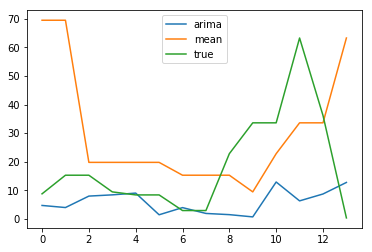

In [105]:
%matplotlib inline
unit = '5407c145046d1e8871eea3f527731fc7'

x = np.arange(14)

y_arima = arima_rp[unit]
y_mean = mean_rp[unit]
y = true_rp[unit]

arima = plt.plot(x, y_arima, label='arima')
mean = plt.plot(x, y_mean, label='mean')
true = plt.plot(x, y, label='true')

plt.legend()
plt.show()

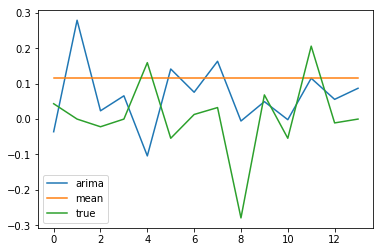

In [110]:
%matplotlib inline
unit = '5407c145046d1e8871eea3f527731fc7'
day = 6

x = np.arange(14)

y_arima = arima_pred[unit][day]
y_mean = mean_pred[unit][day]
y = true_pred[unit][day]

arima = plt.plot(x, y_arima, label='arima')
mean = plt.plot(x, y_mean, label='mean')
true = plt.plot(x, y, label='true')

plt.legend()
plt.show()

In [139]:
_2_ss = {}
_2_rp = {}

for unit in unit_list:
    _2_ss[unit] = []
    _2_rp[unit] = []
    for f in arima_pred[unit]:
        # _2_ss[unit].append(np.var(f) * 1.28 * np.sqrt(14))
        _2_ss[unit].append(np.var(f) * 1.28 * np.sqrt(14) + 14 * np.mean(f) * 1.28)
        _2_rp[unit].append(np.sum(f) + _2_ss[unit][-1])

In [52]:
arima_rp.keys()

dict_keys(['0efede250ca3d05f9d4cc3609242d804', 'fbb83aefc6f5d6f6bc22ae3ee757d327', '392aaa20e70b4d7539cc7a2e09562521', '2effa036807329a88056093fabb07ce6', '7dc25ea61b4d47f7de6c7a8d8d559487', '6580383fbec789022ae6accba82c2be0', '388744eae278a9988a6f4b950068cdef', '272e0dafe51e776feb91cd795fea9908', '1f051603fd6d1d9f1aed4e0cb9b22538', '6b1575e0ffecd14da93e5a5a6b22f308', '643c35dea3b4574d3fb98e283967a915', '6753297bd6aa3d9773e2a3ca36986cf4', '8dc96be31cc2d5dd0db5d607a2de4689', '33f817660553b40a58e3a6391b550f74', '77c89d1055313191b7847238ae3df9df', '6f6eabb1f2f8a416a97895fe77af056a', 'cd5e30e5f29ff9eb03d5be4380518e1a', 'b953b2d7bdbd29440515ff2ea4e968da', 'dbc5b761566051f252b1f4d873f424b9', '15bc6c90c33d176cd359fdca04f65b24', '2c8dfb69edf3b395ba3e1f6042c954cc', '4cc3b4484538964340d33e23cae29dc5', 'e9381006a678c5c392062fdc807d3270', '2ac971ea3fa8316c71d9826724e0d204', 'd490f1f82940df330d093c5bac07db05', '8d7b8b89034cdcbe0376fedfb8c51ab3', '2a24a4544798bfb68f108883510b11f4', '093bb5d4aea8b43a

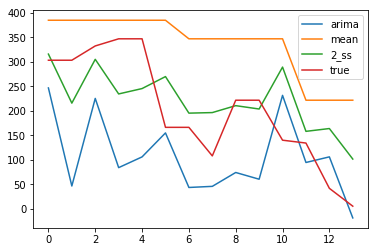

In [148]:
%matplotlib inline
unit = '9002b3384e884befb81dfb78b581932e'

x = np.arange(14)

y_arima = arima_rp[unit]
y_mean = mean_rp[unit]
y_2 = (np.array(y_arima)+np.array(y_mean)) / 2.0
y = true_rp[unit]

arima = plt.plot(x, y_arima, label='arima')
mean = plt.plot(x, y_mean, label='mean')
_2_ss = plt.plot(x, y_2, label='2_ss')
true = plt.plot(x, y, label='true')

plt.legend()
plt.show()

In [9]:
import statsmodels.api as sm
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 14) for x in list(itertools.product(p, d, q))]
print('Examples of parameter for SARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter for SARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 14)
SARIMAX: (0, 0, 1) x (0, 1, 0, 14)
SARIMAX: (0, 1, 0) x (0, 1, 1, 14)
SARIMAX: (0, 1, 0) x (1, 0, 0, 14)


In [10]:
for date in date_list:
    #按每日净需求与每日补货到达更新状态，并判断补货量
    if date.dayofweek == 0:
        for unit in unit_list:
            demand = demand_dict[unit]
            demand_hist = demand[demand["ts"] < date]
            series = np.array(demand_hist["diff"].values[-3 * 7:])
            break
    break

In [11]:
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(series,order=param,seasonal_order=param_seasonal,enforce_stationarity=False,enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param,param_seasonal,results.aic))
        except: 
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 14)12 - AIC:39.288558415646676
ARIMA(0, 0, 0)x(0, 0, 1, 14)12 - AIC:19.590382575009837
ARIMA(0, 0, 0)x(0, 1, 0, 14)12 - AIC:19.430098215486233
ARIMA(0, 0, 0)x(0, 1, 1, 14)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 0, 0, 14)12 - AIC:21.107190516244444
ARIMA(0, 0, 0)x(1, 0, 1, 14)12 - AIC:21.588210236380128
ARIMA(0, 0, 0)x(1, 1, 0, 14)12 - AIC:4.0
ARIMA(0, 0, 0)x(1, 1, 1, 14)12 - AIC:6.0
ARIMA(0, 0, 1)x(0, 0, 0, 14)12 - AIC:39.24416043975619
ARIMA(0, 0, 1)x(0, 0, 1, 14)12 - AIC:19.7629073944019
ARIMA(0, 0, 1)x(0, 1, 0, 14)12 - AIC:18.622739530091884
ARIMA(0, 0, 1)x(0, 1, 1, 14)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 0, 0, 14)12 - AIC:23.0639911639993
ARIMA(0, 0, 1)x(1, 0, 1, 14)12 - AIC:21.75037625592679
ARIMA(0, 0, 1)x(1, 1, 0, 14)12 - AIC:6.0
ARIMA(0, 0, 1)x(1, 1, 1, 14)12 - AIC:8.0
ARIMA(0, 1, 0)x(0, 0, 0, 14)12 - AIC:51.2159847680317
ARIMA(0, 1, 0)x(0, 0, 1, 14)12 - AIC:21.737767744778274
ARIMA(0, 1, 0)x(0, 1, 0, 14)12 - AIC:21.237278663935854


/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


ARIMA(0, 1, 0)x(0, 1, 1, 14)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 0, 0, 14)12 - AIC:24.13530007837891
ARIMA(0, 1, 0)x(1, 0, 1, 14)12 - AIC:23.68266866832351
ARIMA(0, 1, 0)x(1, 1, 0, 14)12 - AIC:4.0
ARIMA(0, 1, 0)x(1, 1, 1, 14)12 - AIC:6.0
ARIMA(0, 1, 1)x(0, 0, 0, 14)12 - AIC:40.877244587623906
ARIMA(0, 1, 1)x(0, 0, 1, 14)12 - AIC:15.013728015459806
ARIMA(0, 1, 1)x(0, 1, 0, 14)12 - AIC:11.875155049225546
ARIMA(0, 1, 1)x(0, 1, 1, 14)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 0, 0, 14)12 - AIC:22.75347855348872
ARIMA(0, 1, 1)x(1, 0, 1, 14)12 - AIC:15.856127039140443
ARIMA(0, 1, 1)x(1, 1, 0, 14)12 - AIC:6.0
ARIMA(0, 1, 1)x(1, 1, 1, 14)12 - AIC:8.0
ARIMA(1, 0, 0)x(0, 0, 0, 14)12 - AIC:41.286125307434176
ARIMA(1, 0, 0)x(0, 0, 1, 14)12 - AIC:21.555193079823567
ARIMA(1, 0, 0)x(0, 1, 0, 14)12 - AIC:21.190408712662013
ARIMA(1, 0, 0)x(0, 1, 1, 14)12 - AIC:6.0
ARIMA(1, 0, 0)x(1, 0, 0, 14)12 - AIC:21.546911869635892
ARIMA(1, 0, 0)x(1, 0, 1, 14)12 - AIC:23.546911860371267
ARIMA(1, 0, 0)x(1, 1, 0, 14)12 - AIC:6.0
ARI

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 14)12 - AIC:22.047935846945208
ARIMA(1, 1, 0)x(0, 1, 0, 14)12 - AIC:22.103034681671122
ARIMA(1, 1, 0)x(0, 1, 1, 14)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 0, 0, 14)12 - AIC:21.959673681950676
ARIMA(1, 1, 0)x(1, 0, 1, 14)12 - AIC:23.959673674523277
ARIMA(1, 1, 0)x(1, 1, 0, 14)12 - AIC:6.0
ARIMA(1, 1, 0)x(1, 1, 1, 14)12 - AIC:8.0
ARIMA(1, 1, 1)x(0, 0, 0, 14)12 - AIC:42.87724458804522
ARIMA(1, 1, 1)x(0, 0, 1, 14)12 - AIC:15.91456764461465
ARIMA(1, 1, 1)x(0, 1, 0, 14)12 - AIC:13.847385403796448
ARIMA(1, 1, 1)x(0, 1, 1, 14)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 0, 0, 14)12 - AIC:22.218367725131884
ARIMA(1, 1, 1)x(1, 0, 1, 14)12 - AIC:17.29243625522067
ARIMA(1, 1, 1)x(1, 1, 0, 14)12 - AIC:8.0
ARIMA(1, 1, 1)x(1, 1, 1, 14)12 - AIC:10.0


In [4]:
import statsmodels.api as sm
import itertools

mae = []
count = 0
len_error = 0
sarima_pred = {}
sarima_ss = {}

for date in date_list:
    #按每日净需求与每日补货到达更新状态，并判断补货量
    if date.dayofweek == 0:
        for unit in unit_list:
            demand = demand_dict[unit]
            demand_hist = demand[demand["ts"] < date]
            true = demand[demand["ts"] >= date]['diff'][:lead_time]
            
            if len(true) < 14:
                len_error += 1
            else:
                try:
                    series = np.array(demand_hist["diff"].values[-3 * 7:])
                    mod = sm.tsa.statespace.SARIMAX(series,order=(0, 0, 0),seasonal_order=(0, 1, 1, 14),enforce_stationarity=False,enforce_invertibility=False)
                    results = mod.fit()
                    print(results.get_forecast(steps=14).predicted_mean)
                    mae.append(mae_metric(output.values, true))
                except:
                    count += 1
                    continue
                    
print('****************************')
print(np.mean(np.array(mae)))

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)


[  7.96900712  14.37288887  14.83013526 -10.12426076   3.71318272
   0.87904954   3.45971674   7.96900712  14.37288887  14.83013526
 -10.12426076   3.71318272   0.87904954   3.45971674]
[ 0.07595486  0.02893519 -0.04340278 -0.01085069  0.          0.01085069
 -0.0072338   0.07595486  0.02893519 -0.04340278 -0.01085069  0.
  0.01085069 -0.0072338 ]
[ 0.27987261 -0.15303953  0.12004576  1.32404131  0.36507237 -0.04535048
  0.15836078  0.27987261 -0.15303953  0.12004576  1.32404131  0.36507237
 -0.04535048  0.15836078]
[ 37.42058983 -24.62069772 188.51456865 109.29801937  70.93187082
 -22.12315916 -30.4706841   37.42058983 -24.62069772 188.51456865
 109.29801937  70.93187082 -22.12315916 -30.4706841 ]
[ 321.56479831 -582.43408898  163.21890295   35.10194003  303.81732215
   53.17250805   41.33013781  321.56479831 -582.43408898  163.21890295
   35.10194003  303.81732215   53.17250805   41.33013781]
[-5.00004442e-01 -1.11111055e+00  7.77777469e-01  6.78827947e-08
 -3.33333422e-01 -9.9999946

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-1.64973023 -0.60083957  2.14995079 -6.46354055 -6.98740626 -4.62537804
 -6.14851752 -1.64973023 -0.60083957  2.14995079 -6.46354055 -6.98740626
 -4.62537804 -6.14851752]
[ 3.91344687 14.15811519 -1.86246682  3.14190751  0.59351541  0.39477278
  0.37867819  3.91344687 14.15811519 -1.86246682  3.14190751  0.59351541
  0.39477278  0.37867819]
[-0.24999899  3.83331783  2.49998988  3.44443051  0.11111066 -1.61110459
 -0.49999798 -0.24999899  3.83331783  2.49998988  3.44443051  0.11111066
 -1.61110459 -0.49999798]
[ 8.19773874  0.60225445  8.03863985 27.6548502   2.89494033 -0.09540734
  3.37330542  8.19773874  0.60225445  8.03863985 27.6548502   2.89494033
 -0.09540734  3.37330542]
[ 40.87634941   5.61516016  45.88474476  33.47494268  19.97105527
 -53.81351405  -3.65703745  40.87634941   5.61516016  45.88474476
  33.47494268  19.97105527 -53.81351405  -3.65703745]
[ 12.33099127   4.55496341  20.7750741   15.55353196  30.21829096
 -12.77611447   8.44334546  12.33099127   4.55496341  20.775

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.43501406  0.87548897  0.56186125 -0.492854    0.47387186  0.57500043
  0.09178243  1.43501406  0.87548897  0.56186125 -0.492854    0.47387186
  0.57500043  0.09178243]
[ 0.17049729 -0.27563558  0.01722722 -0.18490195  0.13494879  0.66685432
 -0.13486431  0.17049729 -0.27563558  0.01722722 -0.18490195  0.13494879
  0.66685432 -0.13486431]
[ -4.832176   -12.32820977   4.51805207  -8.60180543 -20.01668685
 -23.59080746  -9.4041744   -4.832176   -12.32820977   4.51805207
  -8.60180543 -20.01668685 -23.59080746  -9.4041744 ]
[-0.45193202  0.90313887 -3.12318948 -0.30924459 -0.88650115 -0.78812157
 -2.79405197 -0.45193202  0.90313887 -3.12318948 -0.30924459 -0.88650115
 -0.78812157 -2.79405197]
[ 0.62497486  5.20830344 -5.48607958 -0.83332854 -2.49998563 -1.11110473
 -3.12498203  0.62497486  5.20830344 -5.48607958 -0.83332854 -2.49998563
 -1.11110473 -3.12498203]
[ 2.9532853   1.46122647  2.35604683  3.19733712 25.41828753 -1.2876154
 -2.28208128  2.9532853   1.46122647  2.35604683  3.19

[-0.0349503  -0.25121668 -0.05771847  0.76821991  0.12130988  0.42004736
  0.40060357 -0.0349503  -0.25121668 -0.05771847  0.76821991  0.12130988
  0.42004736  0.40060357]
[ 3.9999971  -0.1333333   3.93333233  2.86666594  3.13333254  3.19999919
  3.19999919  3.9999971  -0.1333333   3.93333233  2.86666594  3.13333254
  3.19999919  3.19999919]
[ 6.84890201  2.68625579 -1.47772     4.99066421 -9.52049944  5.67522113
  0.          6.84890201  2.68625579 -1.47772     4.99066421 -9.52049944
  5.67522113  0.        ]
[ 7.83840353  1.32537889  1.58115393 13.89446799  1.98561372  4.16275325
 -9.66385327  7.83840353  1.32537889  1.58115393 13.89446799  1.98561372
  4.16275325 -9.66385327]
[-1.3271175   1.7379658   1.92609992  3.58878483 -0.36875532  2.85307666
  2.25577543 -1.3271175   1.7379658   1.92609992  3.58878483 -0.36875532
  2.85307666  2.25577543]
[2.4999898  3.11110689 1.6666644  1.1111096  0.         1.22222056
 0.         2.4999898  3.11110689 1.6666644  1.1111096  0.
 1.22222056 0.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.78318993e+01  2.77770043e+00  1.86661469e+01  1.32218540e+01
 -3.41606743e-11  6.22204895e+00 -1.11108017e-01  1.78318993e+01
  2.77770043e+00  1.86661469e+01  1.32218540e+01 -3.41606743e-11
  6.22204895e+00 -1.11108017e-01]
[ 6.43598001  7.22642842 -3.48762879  0.65781232 -2.83411236 -0.12685342
  0.53496028  6.43598001  7.22642842 -3.48762879  0.65781232 -2.83411236
 -0.12685342  0.53496028]
[ 0.00000000e+00 -3.40971081e-01  0.00000000e+00 -6.90104651e-01
  4.09147806e+00  0.00000000e+00  1.92405171e-03  0.00000000e+00
 -3.40971081e-01  0.00000000e+00 -6.90104651e-01  4.09147806e+00
  0.00000000e+00  1.92405171e-03]
[69.161591   -5.55524999  1.99996119 -0.11119943  8.11119766 -0.11112056
  4.66672248 69.161591   -5.55524999  1.99996119 -0.11119943  8.11119766
 -0.11112056  4.66672248]
[ 3.99998305 -0.77777646 -2.33332938  2.77777307  0.22222185  0.22222185
 -1.33333107  3.99998305 -0.77777646 -2.33332938  2.77777307  0.22222185
  0.22222185 -1.33333107]
[ 1.99882448e+00  3.887452

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 27.74562896 -32.05943371 -18.14063856 107.52430287 165.97006297
  97.36558274  12.26963113  27.74562896 -32.05943371 -18.14063856
 107.52430287 165.97006297  97.36558274  12.26963113]
[-0.26409113 -0.29460522  0.19508078  1.07460284  0.79569099  0.53034036
  0.74358502 -0.26409113 -0.29460522  0.19508078  1.07460284  0.79569099
  0.53034036  0.74358502]
[ -3.16735407  16.11014797 -21.88758035   1.7776715  -10.55492453
  -1.22214916  -3.99976088  -3.16735407  16.11014797 -21.88758035
   1.7776715  -10.55492453  -1.22214916  -3.99976088]
[8.16666013 0.6666665  1.22222188 1.66666613 0.66666646 0.1111111
 0.11111105 8.16666013 0.6666665  1.22222188 1.66666613 0.66666646
 0.1111111  0.11111105]
[-1.06103242  3.1493626   0.          1.05661283  2.11668415 -0.03898016
  0.88051069 -1.06103242  3.1493626   0.          1.05661283  2.11668415
 -0.03898016  0.88051069]
[ 0.16666434 -1.33333127  1.33333127 -0.55555469  4.44443756 -0.55555469
  1.22222033  0.16666434 -1.33333127  1.33333127 -0.55

[-59.7105135    6.30750806 -26.19665815 -46.32458948  -0.49026459
 -37.83142119 -29.21073766 -59.7105135    6.30750806 -26.19665815
 -46.32458948  -0.49026459 -37.83142119 -29.21073766]
[  0.62445657  20.4391149   10.46550508 -19.17681704  -8.37890704
  -0.32009174  -1.62398686   0.62445657  20.4391149   10.46550508
 -19.17681704  -8.37890704  -0.32009174  -1.62398686]
[ 0.         -1.88888629 -0.33333288 -0.77777672  4.44443834  0.11111096
  0.11111096  0.         -1.88888629 -0.33333288 -0.77777672  4.44443834
  0.11111096  0.11111096]
[5.83326167 1.66666348 0.2222218  0.66666539 5.22221224 0.2222218
 4.44443595 5.83326167 1.66666348 0.2222218  0.66666539 5.22221224
 0.2222218  4.44443595]
[ 3.26795343e+00  8.18141965e-01  7.85047364e-01  5.00650800e+00
  6.25723077e-02 -2.79043557e-01 -3.61689639e-03  3.26795343e+00
  8.18141965e-01  7.85047364e-01  5.00650800e+00  6.25723077e-02
 -2.79043557e-01 -3.61689639e-03]
[-1.76664311e+01 -1.05554977e+01  1.99998904e+00  5.55552512e-01
  4.5

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 6.25540228  5.0908643  -1.51605551  3.96259608 -2.36828594 -1.62772056
 -0.04040431  6.25540228  5.0908643  -1.51605551  3.96259608 -2.36828594
 -1.62772056 -0.04040431]
[ 0.         -0.83334567  0.83334567  0.         -2.70837342 -2.08336417
  0.          0.         -0.83334567  0.83334567  0.         -2.70837342
 -2.08336417  0.        ]
[-3.42210626 -0.31037773  0.10345924 -1.03459242  0.43648275  0.
  3.51822542 -3.42210626 -0.31037773  0.10345924 -1.03459242  0.43648275
  0.          3.51822542]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.32512262 -2.33482938  2.64322537  3.36023105 -4.64710853 -3.5258599
 -0.38786728  0.32512262 -2.33482938  2.64322537  3.36023105 -4.64710853
 -3.5258599  -0.38786728]
[ 14.44090052  34.39043408   5.62681604  27.50817477 -33.87072045
   2.15049929  -4.42706436  14.44090052  34.39043408   5.62681604
  27.50817477 -33.87072045   2.15049929  -4.42706436]
[ 0.61848902  1.79036377  3.2045703  -1.28399826 -1.00549723  0.26041655
 -0.02170138  0.61

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.04340278  0.         -0.49189814  0.         -0.33998842  0.
  0.          0.04340278  0.         -0.49189814  0.         -0.33998842
  0.          0.        ]
[ 16.49661216  -0.57554188   0.85399661 -11.53181     -0.95887382
   0.80859784  -0.10955264  16.49661216  -0.57554188   0.85399661
 -11.53181     -0.95887382   0.80859784  -0.10955264]
[ 1.92056836  0.79752549  0.14847357  1.01146487  3.53244113 -0.45247364
  0.26403338  1.92056836  0.79752549  0.14847357  1.01146487  3.53244113
 -0.45247364  0.26403338]
[-43.82357519   8.03803745  -3.57967449 -23.1511537    3.86883333
  19.30420165 -17.55206899 -43.82357519   8.03803745  -3.57967449
 -23.1511537    3.86883333  19.30420165 -17.55206899]
[ 23.91207472 -12.60476954  17.40090347  30.7106993   -3.84338052
   0.09438928   2.60384284  23.91207472 -12.60476954  17.40090347
  30.7106993   -3.84338052   0.09438928   2.60384284]
[-0.32820951  1.95411097  2.24194917  0.00796548  1.30755057  0.01608414
 -0.32080302 -0.32820951  1.95411

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.15073497e+01  6.41231229e+00  1.83725382e+00  1.06098878e+02
  5.50959233e-01 -4.46479432e-02 -1.62865574e-01  1.15073497e+01
  6.41231229e+00  1.83725382e+00  1.06098878e+02  5.50959233e-01
 -4.46479432e-02 -1.62865574e-01]
[  8.13788683 -23.04686939  13.89071119 -22.07214515  -0.38881638
   0.           0.           8.13788683 -23.04686939  13.89071119
 -22.07214515  -0.38881638   0.           0.        ]
[-7.83304342  0.11110961  5.88880949 -0.33332883  2.22219225 -1.7777538
  0.8888769  -7.83304342  0.11110961  5.88880949 -0.33332883  2.22219225
 -1.7777538   0.8888769 ]
[-81.6551266   -9.77015057  32.51106512  91.84298831  22.35834815
 -40.40700701 -36.83810678 -81.6551266   -9.77015057  32.51106512
  91.84298831  22.35834815 -40.40700701 -36.83810678]
[ 1.66665918e-01  4.56055160e-09 -3.33333258e-01  4.44444359e-01
  1.22222196e+00  1.11111087e-01 -3.33333257e-01  1.66665918e-01
  4.56055160e-09 -3.33333258e-01  4.44444359e-01  1.22

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.          1.22222079 -0.66666588  1.88888669  0.11111098  1.66666473
 -0.33333295 -1.          1.22222079 -0.66666588  1.88888669  0.11111098
  1.66666473 -0.33333295]
[ 0.83333139  0.38888898  0.77777749  0.66666659  1.11111079  0.72222205
 -0.22222222  0.83333139  0.38888898  0.77777749  0.66666659  1.11111079
  0.72222205 -0.22222222]
[  9.82670428  -1.44081954 165.5678988   18.21951258 154.33942251
  14.22859527  -1.55547586   9.82670428  -1.44081954 165.5678988
  18.21951258 154.33942251  14.22859527  -1.55547586]
[ -7.45987386  13.39749549   4.59245604  52.03794899  12.3034422
  -4.39700542 -10.40661335  -7.45987386  13.39749549   4.59245604
  52.03794899  12.3034422   -4.39700542 -10.40661335]
[-0.83332559  5.66665692 -5.88887876  1.77777472  3.8888822  -1.33333104
 -1.88888564 -0.83332559  5.66665692 -5.88887876  1.77777472  3.8888822
 -1.33333104 -1.88888564]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.20947031 0.05195519 0.07

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 3.80266354  4.76889547  7.04189986  1.92655947  4.11051792 -2.28941095
 -9.74221827  3.80266354  4.76889547  7.04189986  1.92655947  4.11051792
 -2.28941095 -9.74221827]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 1.36735601e-09
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 1.36735601e-09 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 0.75954557  0.66550837 -0.47742992 -5.18300812  0.8680544  -0.7595476
  0.          0.75954557  0.66550837 -0.47742992 -5.18300812  0.8680544
 -0.7595476   0.        ]
[  12.39869041   10.67991877   37.280085     83.89858565 -165.20265407
  -21.98875625    9.38338035   12.39869041   10.67991877   37.280085
   83.89858565 -165.20265407  -21.98875625    9.38338035]
[ 0.14328806  0.97899814  0.18040412  0.04790624  0.26385192 -0.44457583
 -0.0518901   0.14328806  0.97899814  0.18040412  0.04790624  0.26385192
 -0.44457583 -0.0518901 ]
[-16.19625392   0.19567219  -5.0507658    3.79915099  -3.09494812
  15.22

[  7.99476559   3.3658791  -12.16288228   5.75791021   1.09501386
  -1.80573301  -7.43958385   7.99476559   3.3658791  -12.16288228
   5.75791021   1.09501386  -1.80573301  -7.43958385]
[ 2.25077373 -3.84369297 -0.42456323  1.46274787  3.28617977  0.42615979
  2.72437461  2.25077373 -3.84369297 -0.42456323  1.46274787  3.28617977
  0.42615979  2.72437461]
[-14.91665024   7.50042885 -11.38177219  -7.60498808 -10.2047503
  -9.05733428 -11.41051533 -14.91665024   7.50042885 -11.38177219
  -7.60498808 -10.2047503   -9.05733428 -11.41051533]
[ -1.16557558  -1.77722323  -4.88736388  -1.55507032   1.33291742
 -85.86209721  -4.88736388  -1.16557558  -1.77722323  -4.88736388
  -1.55507032   1.33291742 -85.86209721  -4.88736388]
[-47.47952016   9.16423902  21.58181917  30.16446667 -53.22930453
  -8.87749224  12.37085459 -47.47952016   9.16423902  21.58181917
  30.16446667 -53.22930453  -8.87749224  12.37085459]
[ 0.01030816  1.03244348  0.21213106  0.74978292 -0.3609664   0.23419413
 -0.14467591

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.07681003 -2.02628443 -3.95761779 -3.24856077  2.78790216 -4.02632847
 -1.31721923  1.07681003 -2.02628443 -3.95761779 -3.24856077  2.78790216
 -4.02632847 -1.31721923]
[ 79.38671241  61.15559626 105.78175023  61.20686896  67.2350101
  38.1278416    5.82218701  79.38671241  61.15559626 105.78175023
  61.20686896  67.2350101   38.1278416    5.82218701]
[34.2258026  51.08495506 28.48570244 28.72378051 27.90700062 26.37432142
 28.35896926 34.2258026  51.08495506 28.48570244 28.72378051 27.90700062
 26.37432142 28.35896926]
[ 9.1661583   3.81939266 -7.0832373  -2.84718362  1.52775706 -0.27777401
  1.24998305  9.1661583   3.81939266 -7.0832373  -2.84718362  1.52775706
 -0.27777401  1.24998305]
[ -52.98474261 -116.67629195 -298.83043726   23.79321116 -601.78508718
  -27.90087541 -325.60627321  -52.98474261 -116.67629195 -298.83043726
   23.79321116 -601.78508718  -27.90087541 -325.60627321]
[ 1.22656979  0.15431123 -0.61716185  0.31966156  0.25467548 -0.54127218
  0.05034131  1.22656979  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-17.67187647  -0.7786112    2.44231577  -6.10700265   2.11236117
   2.77517121   0.99908828 -17.67187647  -0.7786112    2.44231577
  -6.10700265   2.11236117   2.77517121   0.99908828]
[14.16662369 -0.33333301  0.88888801 -0.222222   -0.333333   -0.222222
  1.44444302 14.16662369 -0.33333301  0.88888801 -0.222222   -0.333333
 -0.222222    1.44444302]
[ 11.93961267  97.62971618  24.88218671 -23.37259182 258.35826382
  89.15946375 -32.2355829   11.93961267  97.62971618  24.88218671
 -23.37259182 258.35826382  89.15946375 -32.2355829 ]
[-27.05072032  -0.31658285 -56.02929431  -3.96976832 -45.32167267
 -12.67173187   1.62958019 -27.05072032  -0.31658285 -56.02929431
  -3.96976832 -45.32167267 -12.67173187   1.62958019]
[0.29999999 0.26666666 0.2        0.13333333 0.33333333 0.2
 0.2        0.29999999 0.26666666 0.2        0.13333333 0.33333333
 0.2        0.2       ]
[  7.99997752   4.38888754  -0.05555982 -11.0555617   16.88889722
   0.88889722   0.           7.99997752   4.38888754  -0.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.01179737 -0.82828997 -8.02526794 -1.16928421 -0.5010259  -1.49997444
 -1.49833592  0.01179737 -0.82828997 -8.02526794 -1.16928421 -0.5010259
 -1.49997444 -1.49833592]
[0.         0.         0.06410318 0.         0.         0.12820635
 0.08013021 0.         0.         0.06410318 0.         0.
 0.12820635 0.08013021]
[ 7.65321618 10.40806101  8.91824375 11.28022561  7.48103519 15.27156147
 11.07064628  7.65321618 10.40806101  8.91824375 11.28022561  7.48103519
 15.27156147 11.07064628]
[ 0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
 -1.5710176e-11  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.5710176e-11
  0.0000000e+00  0.0000000e+00]
[-0.80563381  5.93760542 21.48404789 -2.8884346   7.903816    1.33183086
  4.01974059 -0.80563381  5.93760542 21.48404789 -2.8884346   7.903816
  1.33183086  4.01974059]
[-1.3333318   1.44444393 -0.33333325  0.33333322  1.55555504 -0.33333319
  0.88888853 -1.3333318   1.44444393 -0.33333325 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  2.51068533   9.99831782  -9.17659239   5.50464343 -15.45705817
   3.83095923 -16.60474296   2.51068533   9.99831782  -9.17659239
   5.50464343 -15.45705817   3.83095923 -16.60474296]
[-15.03103275  -0.62416793  -2.43249908   5.67344479  -8.1536536
  -0.13911279 -12.30576733 -15.03103275  -0.62416793  -2.43249908
   5.67344479  -8.1536536   -0.13911279 -12.30576733]
[ 86.83709065 -64.3328837  -41.44482556   3.00052671 -10.5556883
  -1.11111968 -20.2224192   86.83709065 -64.3328837  -41.44482556
   3.00052671 -10.5556883   -1.11111968 -20.2224192 ]
[ 8.99972625  2.99997067 10.99989246 14.44430329 12.66654279 -4.77773114
  3.99996089  8.99972625  2.99997067 10.99989246 14.44430329 12.66654279
 -4.77773114  3.99996089]
[  24.43971501   36.52655087   53.3593694   -85.29515161 -112.77323088
 -129.33991788  -20.69172555   24.43971501   36.52655087   53.3593694
  -85.29515161 -112.77323088 -129.33991788  -20.69172555]
[-5.99619416  0.2221694  -8.88677338 20.99500203 -4.22121747 11.77497548


/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.49999856e+00  2.33333237e+00  7.77777454e-01 -1.66666598e+00
  9.99999588e-01 -9.99999589e-01  4.62726579e-10  2.49999856e+00
  2.33333237e+00  7.77777454e-01 -1.66666598e+00  9.99999588e-01
 -9.99999589e-01  4.62726579e-10]
[ 17.30810517   2.62363229  -3.15408863   2.87474846 -19.35546804
 -25.67998949 -22.23620979  17.30810517   2.62363229  -3.15408863
   2.87474846 -19.35546804 -25.67998949 -22.23620979]
[-661.75461398   54.99197953  304.38552882   66.99823043  143.37324035
  -49.12369052 -963.80165095 -661.75461398   54.99197953  304.38552882
   66.99823043  143.37324035  -49.12369052 -963.80165095]
[ 4.17171397  6.01503992  1.22763454  0.85985513 -1.74928355 -2.71683744
 -0.38528126  4.17171397  6.01503992  1.22763454  0.85985513 -1.74928355
 -2.71683744 -0.38528126]
[10.17047921  2.47993103  0.          0.          1.51157437  0.
  0.06790221 10.17047921  2.47993103  0.          0.          1.51157437
  0.          0.06790221]
[137.77332642  51.50112578  20.47363584  45.09019

[-1.11274392  0.69765562  1.16490156 55.77446711  1.22763076 55.56905396
  2.39574867 -1.11274392  0.69765562  1.16490156 55.77446711  1.22763076
 55.56905396  2.39574867]
[ 104.89630044 -126.12978464  105.25541881   57.54257412  -74.33042503
   11.48642462   15.68338822  104.89630044 -126.12978464  105.25541881
   57.54257412  -74.33042503   11.48642462   15.68338822]
[ -12.1328055  -156.3845602   -45.49377718  -20.60844668  -78.14746927
  -12.48182606   -9.40042282  -12.1328055  -156.3845602   -45.49377718
  -20.60844668  -78.14746927  -12.48182606   -9.40042282]
[-191.7725419    -5.13016358  -17.12067773   24.11520459    1.81210325
  -13.63552994    0.26274683 -191.7725419    -5.13016358  -17.12067773
   24.11520459    1.81210325  -13.63552994    0.26274683]
[ 0.32379203  8.19616597  9.20075163 13.09966949  3.77716539  1.70310993
  7.20405406  0.32379203  8.19616597  9.20075163 13.09966949  3.77716539
  1.70310993  7.20405406]
[40.83711668 85.55451995 59.22199896 23.33780817  8.9997

[ 16.50382161  20.40730771   6.27326073   0.39570556 -14.17601843
 -24.07157014   0.13553963  16.50382161  20.40730771   6.27326073
   0.39570556 -14.17601843 -24.07157014   0.13553963]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -3.66941694   6.4441279   -0.99995088 -15.77700289   1.22216219
  -2.99985265  -3.11095831  -3.66941694   6.4441279   -0.99995088
 -15.77700289   1.22216219  -2.99985265  -3.11095831]
[ 1.09349327  0.22822493  0.3761553   3.9604868  -3.41705049  0.22695909
  0.30924297  1.09349327  0.22822493  0.3761553   3.9604868  -3.41705049
  0.22695909  0.30924297]
[-0.1953125  -0.04340278  0.01446759  0.13346354  0.06365741  0.09042245
 -0.05063657 -0.1953125  -0.04340278  0.01446759  0.13346354  0.06365741
  0.09042245 -0.05063657]
[  0.09064416  -3.67500205  12.12224985   6.7826737  -11.87378287
 -12.85143405 -10.9023898    0.09064416  -3.67500205  12.12224985
   6.7826737  -11.87378287 -12.85143405 -10.9023898 ]
[ 1.64332829 -0.00743908  0.60734049 -1.84212604  4.38

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-2.34225887 41.16779832 -4.98283097 24.54934933 -2.39675779  4.02091476
 -5.2775993  -2.34225887 41.16779832 -4.98283097 24.54934933 -2.39675779
  4.02091476 -5.2775993 ]
[-3.66195463e-01  1.48310259e+01  0.00000000e+00 -9.01555268e-02
 -3.92264045e-02 -2.81736021e-03  0.00000000e+00 -3.66195463e-01
  1.48310259e+01  0.00000000e+00 -9.01555268e-02 -3.92264045e-02
 -2.81736021e-03  0.00000000e+00]
[-18.78936848   3.11865138   7.12121156  23.21356978  31.07962686
 -16.8572764    1.55769972 -18.78936848   3.11865138   7.12121156
  23.21356978  31.07962686 -16.8572764    1.55769972]
[-2.60414695e+00 -8.32812373e-01 -2.01265377e+01 -2.00291002e+01
  1.07337674e-01  0.00000000e+00 -1.30240275e-03 -2.60414695e+00
 -8.32812373e-01 -2.01265377e+01 -2.00291002e+01  1.07337674e-01
  0.00000000e+00 -1.30240275e-03]
[14.16657803 -1.22222025 -1.49999758 -0.55555466  0.1666664  -0.66666559
 -2.72221784 14.16657803 -1.22222025 -1.49999758 -0.55555466  0.1666664
 -0.66666559 -2.72221784]
[-6.88203910e

[  23.69201732  -22.29164275 -112.12363596 -120.8406664  -117.11430224
  -12.50993683  -12.1772257    23.69201732  -22.29164275 -112.12363596
 -120.8406664  -117.11430224  -12.50993683  -12.1772257 ]
[52.30326511 29.39294306 30.54184337 37.67693161 20.64971017  2.00347181
 11.98111141 52.30326511 29.39294306 30.54184337 37.67693161 20.64971017
  2.00347181 11.98111141]
[-6.56739385e-01  2.64188405e+00  6.61739709e-01  3.99486977e+00
  2.57435463e-03 -7.39172887e-05  3.69586443e-05 -6.56739385e-01
  2.64188405e+00  6.61739709e-01  3.99486977e+00  2.57435463e-03
 -7.39172887e-05  3.69586443e-05]
[  3.51947197  51.1402238   19.15303285  22.64435768  -8.12490437
   8.93875343 -30.55392633   3.51947197  51.1402238   19.15303285
  22.64435768  -8.12490437   8.93875343 -30.55392633]
[ -6.93116817 -17.90758837   2.85625189   3.97552936   3.08320262
   3.70999097  -0.02639548  -6.93116817 -17.90758837   2.85625189
   3.97552936   3.08320262   3.70999097  -0.02639548]
[-1.27156575e-06  8.5826885

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.83333797 -0.05555551  1.44444333  4.22221896 -0.33333308 -2.44444256
 -1.38888782  0.83333797 -0.05555551  1.44444333  4.22221896 -0.33333308
 -2.44444256 -1.38888782]
[-8.16666479 -0.99999992 -0.22222221  0.         -0.44444441  0.
  0.         -8.16666479 -0.99999992 -0.22222221  0.         -0.44444441
  0.          0.        ]
[52.93240818  4.94326669  0.63364431  1.20053588 -8.56183633 -6.19714963
 -0.41001864 52.93240818  4.94326669  0.63364431  1.20053588 -8.56183633
 -6.19714963 -0.41001864]
[ 5.66659841  5.11108785 -4.11109236  1.6666591   4.77775613 -0.33333182
  0.88888483  5.66659841  5.11108785 -4.11109236  1.6666591   4.77775613
 -0.33333182  0.88888483]
[ 0.         -0.1111111  -0.1111111  -0.1111111   1.33333323  0.
  0.          0.         -0.1111111  -0.1111111  -0.1111111   1.33333323
  0.          0.        ]
[23.83485161  2.99997571  3.22219613  0.22222042  7.44438416 -0.44444085
  4.99995951 23.83485161  2.99997571  3.22219613  0.22222042  7.44438416
 -0.444440

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-1.54189785 -3.97745682  5.2175188  -0.0232158   1.62009581  0.01194421
  0.27671094 -1.54189785 -3.97745682  5.2175188  -0.0232158   1.62009581
  0.01194421  0.27671094]
[-13.08322096 -16.05550882 -30.50008728 -33.00007097 -18.0000389
 -31.88922887 -21.66689408 -13.08322096 -16.05550882 -30.50008728
 -33.00007097 -18.0000389  -31.88922887 -21.66689408]
[ 5.92694311 -1.17704278  0.85427581  1.59493233 -0.2398622   0.19321998
 -0.47409419  5.92694311 -1.17704278  0.85427581  1.59493233 -0.2398622
  0.19321998 -0.47409419]
[-125.69988221  -76.67593848 -105.94096865 -108.87428943  -93.20702078
 -102.94014565 -137.67208728 -125.69988221  -76.67593848 -105.94096865
 -108.87428943  -93.20702078 -102.94014565 -137.67208728]
[ 2.95388523e+01  4.48096604e+00  9.93873564e+00  5.40442347e+00
  9.68207787e+00 -1.34864639e-02  2.03760663e+00  2.95388523e+01
  4.48096604e+00  9.93873564e+00  5.40442347e+00  9.68207787e+00
 -1.34864639e-02  2.03760663e+00]
[-0.58525454  8.54702165 -7.72345659 10.552

[ 3.36038469  0.13852595  1.34710161 14.84976529  0.35626127 -0.60546331
  0.0672737   3.36038469  0.13852595  1.34710161 14.84976529  0.35626127
 -0.60546331  0.0672737 ]
[ 14.77884335   3.06055293  -1.40166088   0.05302468   5.41732414
  -2.32735526 -19.54477499  14.77884335   3.06055293  -1.40166088
   0.05302468   5.41732414  -2.32735526 -19.54477499]
[-1.35507297e+00  3.47566658e-03 -1.04252757e+01 -1.55796887e+00
 -9.11598096e-01 -1.96230765e-01  6.34944056e-03 -1.35507297e+00
  3.47566658e-03 -1.04252757e+01 -1.55796887e+00 -9.11598096e-01
 -1.96230765e-01  6.34944056e-03]
[ 5.15408113 -5.8557405   0.38266667 -0.39424071  0.09657089  1.79903973
 -1.25505988  5.15408113 -5.8557405   0.38266667 -0.39424071  0.09657089
  1.79903973 -1.25505988]
[ 0.65754891  0.00212063 -0.1825499  -0.54729513  0.77726625 -0.44667214
  0.16497142  0.65754891  0.00212063 -0.1825499  -0.54729513  0.77726625
 -0.44667214  0.16497142]
[ 3.08155838e+00 -5.25986916e-05  2.12533951e-02 -6.92055024e-01
 -5.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  0.54566127  15.32672721   6.63204561  13.91058638 -38.30795699
  -2.22593253  -6.12117882   0.54566127  15.32672721   6.63204561
  13.91058638 -38.30795699  -2.22593253  -6.12117882]
[ 0.44161473  0.84914154  1.12359886  0.43329918 -0.73831888  0.06511643
 -0.53183068  0.44161473  0.84914154  1.12359886  0.43329918 -0.73831888
  0.06511643 -0.53183068]
[ 1.1811173   0.83378984  3.78831292 13.72035655 -1.10034197 15.19364093
  8.37234276  1.1811173   0.83378984  3.78831292 13.72035655 -1.10034197
 15.19364093  8.37234276]
[-47.39855915 108.1824897   13.21587426  64.33414509  -9.64615936
   2.38725753   3.05604669 -47.39855915 108.1824897   13.21587426
  64.33414509  -9.64615936   2.38725753   3.05604669]
[ 0.56532166  1.34114563  0.75737835  0.4484953  -0.19278064  0.48538765
 -0.72952825  0.56532166  1.34114563  0.75737835  0.4484953  -0.19278064
  0.48538765 -0.72952825]
[  1.07663567   5.36042487 -10.45988764  -0.91561607  11.91586792
  -0.47019026  -0.03725561   1.07663567   5.36

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.12162551 -0.00497208 -0.13238603 -0.86275204  3.39369916  0.7326666
  1.0690573  -0.12162551 -0.00497208 -0.13238603 -0.86275204  3.39369916
  0.7326666   1.0690573 ]
[ 21.70560371  -4.84589532  13.12876904  18.27992396  11.15215657
 -21.85703691  -5.97672009  21.70560371  -4.84589532  13.12876904
  18.27992396  11.15215657 -21.85703691  -5.97672009]
[122.86182124  -8.16893676 496.3226788  -14.09819553  75.65272602
 -25.98193806  -1.1638561  122.86182124  -8.16893676 496.3226788
 -14.09819553  75.65272602 -25.98193806  -1.1638561 ]
[  3.47385306  -0.4252117  -10.31751866   1.08905253   6.74853554
  -1.85576402  -0.40543877   3.47385306  -0.4252117  -10.31751866
   1.08905253   6.74853554  -1.85576402  -0.40543877]
[ 9.99999530e-01  1.11111265e-01  4.57776825e-08  1.77777670e+00
  4.99999586e-01 -1.66666386e-01  1.11111070e+00  9.99999530e-01
  1.11111265e-01  4.57776825e-08  1.77777670e+00  4.99999586e-01
 -1.66666386e-01  1.11111070e+00]
[-23.53263851  13.50084448  -3.84736093  72

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  0.          -0.1111105  -11.44438135   0.           1.11110499
  -0.222221     0.           0.          -0.1111105  -11.44438135
   0.           1.11110499  -0.222221     0.        ]
[ 5.70355266 12.46831165  0.24309996 23.69291203 -6.49979722  0.04644168
 15.83106676  5.70355266 12.46831165  0.24309996 23.69291203 -6.49979722
  0.04644168 15.83106676]
[ 0.14758181  0.046943    0.01269512  0.27694138 -0.19486264 -0.57218935
 -0.21582407  0.14758181  0.046943    0.01269512  0.27694138 -0.19486264
 -0.57218935 -0.21582407]
[21.45727253 54.04883262 14.79602206 69.1008536   2.87096811  9.87813305
  7.91029995 21.45727253 54.04883262 14.79602206 69.1008536   2.87096811
  9.87813305  7.91029995]
[ 16.3143383  -16.24976675  -0.37357403   0.49810397   0.51873381
  -0.4219791    2.7727392   16.3143383  -16.24976675  -0.37357403
   0.49810397   0.51873381  -0.4219791    2.7727392 ]
[ -8.95785846   7.56936566   1.63192746  -0.93749024  -5.20827912
  -2.36108654 -14.86095643  -8.95785846   7.56

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.10940785  0.05647914 14.59740181  0.44931853  3.24778975 -2.21731538
  0.09562193  1.10940785  0.05647914 14.59740181  0.44931853  3.24778975
 -2.21731538  0.09562193]
[ 4.06915475 -5.46868529 -0.08861298 -5.87919842 -0.41232151  0.
  0.          4.06915475 -5.46868529 -0.08861298 -5.87919842 -0.41232151
  0.          0.        ]
[-4.99996570e+00  2.66665523e+00  5.99997428e+00  1.77777016e+00
  6.33330618e+00  1.33332762e+00  1.35970124e-11 -4.99996570e+00
  2.66665523e+00  5.99997428e+00  1.77777016e+00  6.33330618e+00
  1.33332762e+00  1.35970124e-11]
[154.78871476 -49.64361137  35.07349751 153.45087343  17.93341323
  45.44417451 -20.58056427 154.78871476 -49.64361137  35.07349751
 153.45087343  17.93341323  45.44417451 -20.58056427]
[ 1.49999897e+00  1.11111095e-01  6.66666548e-01  6.66666540e-01
  3.33333262e-01 -2.71096307e-09 -3.33333271e-01  1.49999897e+00
  1.11111095e-01  6.66666548e-01  6.66666540e-01  3.33333262e-01
 -2.710963

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 4.16665122e+00 -1.11110948e-01 -4.44443789e-01  1.22222042e+00
  4.39631664e-12 -1.11110950e-01 -3.33332843e-01  4.16665122e+00
 -1.11110948e-01 -4.44443789e-01  1.22222042e+00  4.39631664e-12
 -1.11110950e-01 -3.33332843e-01]
[ 1.05392737  2.9590874   0.23400777  0.68811365  0.38372932  0.19553486
 -0.29117001  1.05392737  2.9590874   0.23400777  0.68811365  0.38372932
  0.19553486 -0.29117001]
[-4.99789595  6.66602896 32.33024042  5.66612461 31.44143656 -1.44430627
  0.22220097 -4.99789595  6.66602896 32.33024042  5.66612461 31.44143656
 -1.44430627  0.22220097]
[ 51.40188832 -58.93928497  38.43044713  21.11375887 -31.65618017
 -62.71097436 -13.1018894   51.40188832 -58.93928497  38.43044713
  21.11375887 -31.65618017 -62.71097436 -13.1018894 ]
[ -0.49121288  -4.7931839    1.35136759 -11.06905253  -4.50251707
  -2.56226588   4.79834517  -0.49121288  -4.7931839    1.35136759
 -11.06905253  -4.50251707  -2.56226588   4.79834517]
[0. 0. 0. 0

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[101.58687144  71.03270715   8.11315107  29.23335605  72.31954673
 -41.75395734 -65.74557067 101.58687144  71.03270715   8.11315107
  29.23335605  72.31954673 -41.75395734 -65.74557067]
[14.1797033   2.60865017  1.87160556  4.46396029 -3.30461563 -2.26650307
  5.23607882 14.1797033   2.60865017  1.87160556  4.46396029 -3.30461563
 -2.26650307  5.23607882]
[ 81.68664469  52.51383444 -38.60673139   7.5054379   -0.13996071
 -33.01589805  -9.31733228  81.68664469  52.51383444 -38.60673139
   7.5054379   -0.13996071 -33.01589805  -9.31733228]
[ 5.843499    4.99930112 -4.1078543  -0.58565859 -4.08368465  1.05619965
  3.00245618  5.843499    4.99930112 -4.1078543  -0.58565859 -4.08368465
  1.05619965  3.00245618]
[ 7.46403341e-01  4.69655290e+00 -7.91726643e+01  7.48730155e-01
 -6.13142068e-02 -2.53592330e+00  2.05809459e+00  7.46403341e-01
  4.69655290e+00 -7.91726643e+01  7.48730155e-01 -6.13142068e-02
 -2.53592330e+00  2.05809459e+00]
[-0.04120489  0.01521537  0.00858797 -0.00276591  0.017

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.         0.         0.         0.00049002 0.         0.
 0.         0.         0.         0.         0.00049002 0.
 0.         0.        ]
[ 0.02110859  0.52919459  0.00117379  0.30276806 -0.24737811 -0.37721086
  0.          0.02110859  0.52919459  0.00117379  0.30276806 -0.24737811
 -0.37721086  0.        ]
[ 29.83989188   0.13922068   4.79334909   3.70417343 -33.62956304
   7.9934353   -6.75057454  29.83989188   0.13922068   4.79334909
   3.70417343 -33.62956304   7.9934353   -6.75057454]
[ 2.90361156e-01  1.64689577e+00  7.82157088e-01  2.01395609e+00
  2.20205005e+00 -1.62590584e-01 -3.93886942e-04  2.90361156e-01
  1.64689577e+00  7.82157088e-01  2.01395609e+00  2.20205005e+00
 -1.62590584e-01 -3.93886942e-04]
[-23.21765243  -5.78131621  -0.45108955  -7.95622005 -18.94679957
  11.48673181   7.46207795 -23.21765243  -5.78131621  -0.45108955
  -7.95622005 -18.94679957  11.48673181   7.46207795]
[ 36.82955934 -11.55512388   2.33324528   0.55553453   3.66652879
   0.77774856   1.2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[   3.05150551 -116.66650816  -20.86125157 -121.72431552   38.77364092
  -21.36965753  -12.23367748    3.05150551 -116.66650816  -20.86125157
 -121.72431552   38.77364092  -21.36965753  -12.23367748]
[ -5.07695098   3.17217347   5.10656163  10.39580992  -7.92394579
 -20.95879799  -6.45977832  -5.07695098   3.17217347   5.10656163
  10.39580992  -7.92394579 -20.95879799  -6.45977832]
[-19.64883052 -47.43348209  -7.33162243 -64.54069742 -25.66076177
  -1.77735492  -6.99839167 -19.64883052 -47.43348209  -7.33162243
 -64.54069742 -25.66076177  -1.77735492  -6.99839167]
[ 3.03196267 -1.86064377 -1.7951499   1.29553168 -0.7814525  -3.17415762
  0.08409545  3.03196267 -1.86064377 -1.7951499   1.29553168 -0.7814525
 -3.17415762  0.08409545]
[ 1.55613744 -0.16787759  1.12557481 -1.14963407 -0.09251753  0.1885035
 -0.03287505  1.55613744 -0.16787759  1.12557481 -1.14963407 -0.09251753
  0.1885035  -0.03287505]
[-0.02440338  2.06705666  0.22243917 -5.42028192 -0.02712673 -0.23871521
 -0.20797158 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  0.89388552   7.83309106 -17.2638678    4.89739975 -44.89144501
   7.41373223  -5.85691548   0.89388552   7.83309106 -17.2638678
   4.89739975 -44.89144501   7.41373223  -5.85691548]
[ 0.54684964 -1.93069337 -4.30332151 -2.30536023 -0.13648021 -2.61440252
 -2.02245981  0.54684964 -1.93069337 -4.30332151 -2.30536023 -0.13648021
 -2.61440252 -2.02245981]
[53.14483461 60.66357461 66.36893742 46.07681201 43.53864418 83.25017957
 11.42989665 53.14483461 60.66357461 66.36893742 46.07681201 43.53864418
 83.25017957 11.42989665]
[ 42.65394383  17.32776173  19.66417077 104.56184348 135.89122298
 118.94549208  14.72029805  42.65394383  17.32776173  19.66417077
 104.56184348 135.89122298 118.94549208  14.72029805]
[ 0.48869966  7.78984319 -2.86707789 -3.31945451 -1.57957688 -1.70074942
 -1.50014855  0.48869966  7.78984319 -2.86707789 -3.31945451 -1.57957688
 -1.70074942 -1.50014855]
[ -14.08376215 -155.3318701  -298.95443767   46.91834093 -672.12961699
    0.75762499 -341.32745132  -14.08376215

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[3.37019236e+00 4.33451388e-04 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 3.37019236e+00
 4.33451388e-04 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[51.71585849 67.21427787 65.82180442 51.66023009 59.46571769 33.50289347
 18.22935388 51.71585849 67.21427787 65.82180442 51.66023009 59.46571769
 33.50289347 18.22935388]
[ 20.16474673 -39.99191279   6.88749609   4.22136857  52.10057528
  -0.22217729  11.99757384  20.16474673 -39.99191279   6.88749609
   4.22136857  52.10057528  -0.22217729  11.99757384]
[12.06658583  8.55584048 17.20917596 24.32139815 22.25887602 -0.31121943
 -2.47997271 12.06658583  8.55584048 17.20917596 24.32139815 22.25887602
 -0.31121943 -2.47997271]
[-6.57961707 18.9672881  -4.66088102 25.55970196 15.75192377  0.84611295
 -0.42326979 -6.57961707 18.9672881  -4.66088102 25.55970196 15.75192377
  0.84611295 -0.42326979]
[-1.61656958  5.29563957  0.75507814 -4.04002624 -0.86998057 -2.99832118
 -2.717283

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 42.76320306  44.78784002   2.79102911 -16.03765794 -67.63908046
  16.79462346  48.7441152   42.76320306  44.78784002   2.79102911
 -16.03765794 -67.63908046  16.79462346  48.7441152 ]
[-17.21872937  14.04337342   0.69060002   3.10988859   6.40737803
  -1.01647042  -0.36270129 -17.21872937  14.04337342   0.69060002
   3.10988859   6.40737803  -1.01647042  -0.36270129]
[ 8.66666874 -0.11111089  4.1111023   1.66666312  0.33333263  0.33333261
  1.44444129  8.66666874 -0.11111089  4.1111023   1.66666312  0.33333263
  0.33333261  1.44444129]
[ 21.22558736  97.30171319  14.64518542  12.42621761  42.49322026
 -44.49029499 -13.42475099  21.22558736  97.30171319  14.64518542
  12.42621761  42.49322026 -44.49029499 -13.42475099]
[ -2.98548511   1.2794094   22.08958663   9.66250338 -18.79654298
 -13.23474425  -6.17055165  -2.98548511   1.2794094   22.08958663
   9.66250338 -18.79654298 -13.23474425  -6.17055165]
[0.053335   0.3578937  0.2        0.22679427 0.0459361  0.2421063
 0.2        0.0533

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -8.66648444  20.64901025  -1.90921176 -12.9582594   -0.08170524
  -1.4693335    0.49382152  -8.66648444  20.64901025  -1.90921176
 -12.9582594   -0.08170524  -1.4693335    0.49382152]
[  29.40964117 -148.01681074  164.07246649   75.90975091 -150.41574037
   24.83052343  111.20631333   29.40964117 -148.01681074  164.07246649
   75.90975091 -150.41574037   24.83052343  111.20631333]
[ -3.51932075   6.2178007    3.24518475  -1.61741094 -58.75411098
   0.57183584  19.34708426  -3.51932075   6.2178007    3.24518475
  -1.61741094 -58.75411098   0.57183584  19.34708426]
[-0.33333838 -1.16666569 -4.05555215 -2.4999979  -1.05555467 -1.61110976
 -1.66666527 -0.33333838 -1.16666569 -4.05555215 -2.4999979  -1.05555467
 -1.61110976 -1.66666527]
[0.00000000e+00 0.00000000e+00 3.53239738e-13 0.00000000e+00
 0.00000000e+00 7.06479477e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00 3.53239738e-13 0.00000000e+00 0.00000000e+00
 7.06479477e-13 0.00000000e+0

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.2         0.17333333 -0.13333333  0.01333333  0.          0.01333333
  0.04        0.2         0.17333333 -0.13333333  0.01333333  0.
  0.01333333  0.04      ]
[15.42638154 38.55327085 -2.4442996   6.99958519  3.44424034  4.1108675
  1.6665679  15.42638154 38.55327085 -2.4442996   6.99958519  3.44424034
  4.1108675   1.6665679 ]
[11.16705422 16.77754137  6.77768223  8.33321585  9.33320157  2.55551943
 -1.22220506 11.16705422 16.77754137  6.77768223  8.33321585  9.33320157
  2.55551943 -1.22220506]
[-0.1666801   2.33332916  1.11110912  4.11110375 12.7777549  -0.66666547
 -0.44444365 -0.1666801   2.33332916  1.11110912  4.11110375 12.7777549
 -0.66666547 -0.44444365]
[-11.80001918   9.26659262   1.33332268  12.93322999  -2.66664536
   7.59993927 -26.19979064 -11.80001918   9.26659262   1.33332268
  12.93322999  -2.66664536   7.59993927 -26.19979064]
[-11.24995462   4.44443846  -2.04860836   1.14583179  -3.81943931
  -0.97222092 -12.9166493  -11.24995462   4.44443846  -2.04860836
   1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  20.80937336  131.16996729  -18.3405174    89.32200913  -90.37388923
 -225.56334207 -206.48509092   20.80937336  131.16996729  -18.3405174
   89.32200913  -90.37388923 -225.56334207 -206.48509092]
[ 1.00000015  1.76983094  0.42497894 -0.10220133  1.33885956 -0.42857926
 -0.19937318  1.00000015  1.76983094  0.42497894 -0.10220133  1.33885956
 -0.42857926 -0.19937318]
[  9.0966286   -2.26660094  -3.19990744  -1.46662432  -3.13324234
 -11.79965926 -36.59894261   9.0966286   -2.26660094  -3.19990744
  -1.46662432  -3.13324234 -11.79965926 -36.59894261]
[ 330.00794884  208.76621942  233.02561838  112.50433248 1011.27241147
   94.44126381  261.04487989  330.00794884  208.76621942  233.02561838
  112.50433248 1011.27241147   94.44126381  261.04487989]
[  4.0003023   -0.5556933   -3.50000545  -4.27775712 -73.44472998
   7.55563732   1.27772364   4.0003023   -0.5556933   -3.50000545
  -4.27775712 -73.44472998   7.55563732   1.27772364]
[-6.83335099 -0.66666606  5.55555583  0.         -0.44444

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.00000000e+00 0.00000000e+00 2.07347756e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.07347756e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[146.44254136 516.16614212 443.08376368 387.54429734 275.97628593
 243.59821051 115.99889512 146.44254136 516.16614212 443.08376368
 387.54429734 275.97628593 243.59821051 115.99889512]
[ 31.65719321  -8.99903091 -15.33168232  -3.8884702  -23.21972188
  -0.11109915  -0.66659488  31.65719321  -8.99903091 -15.33168232
  -3.8884702  -23.21972188  -0.11109915  -0.66659488]
[-13.41666203  -0.16666665   1.27777762   0.16666665   0.77777768
  -0.2222222   -0.61111104 -13.41666203  -0.16666665   1.27777762
   0.16666665   0.77777768  -0.2222222   -0.61111104]
[ 0.50000358  8.11105304  2.99997852 -2.88886822  0.33333095  0.55555158
  0.          0.50000358  8.11105304  2.99997852 -2.88886822  0.33333095
  0.55555158  0.        ]
[-4.99999999e-01  6.89215468e-01 -8.46529442e-03 -1.405

[32.49971395 31.888652   28.22201255 46.77743025 53.33293707  7.88883028
  9.44437428 32.49971395 31.888652   28.22201255 46.77743025 53.33293707
  7.88883028  9.44437428]
[  2.57902402   6.43330101   4.50877216  -1.89866836   2.61661423
 -11.13756415  -2.98933109   2.57902402   6.43330101   4.50877216
  -1.89866836   2.61661423 -11.13756415  -2.98933109]
[-1.56249362 -3.54166417  0.24305538 -0.45138857 -1.80555429 -1.94444308
 -1.5277767  -1.56249362 -3.54166417  0.24305538 -0.45138857 -1.80555429
 -1.94444308 -1.5277767 ]
[ 2.60551799  3.08414555 47.01061807 14.6110085  -0.90132387 -2.39691937
 -1.09034188  2.60551799  3.08414555 47.01061807 14.6110085  -0.90132387
 -2.39691937 -1.09034188]
[  3.14177588  11.71899881 -11.15046963  -2.69779198   8.07565378
 -13.20722269  -5.5062497    3.14177588  11.71899881 -11.15046963
  -2.69779198   8.07565378 -13.20722269  -5.5062497 ]
[ -3.6519205   32.31929758 -72.7461857  -22.65682693  -0.11106287
  -0.22212576  -0.66637728  -3.6519205   32.31

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  0.49951828   3.11105661  10.77758898 -17.44413886  -2.11107413
  -2.33329246  -2.11107413   0.49951828   3.11105661  10.77758898
 -17.44413886  -2.11107413  -2.33329246  -2.11107413]
[ 0.52656569  0.43438368  5.48603808 -1.17728468 -3.22695356  0.23057419
 -0.09042125  0.52656569  0.43438368  5.48603808 -1.17728468 -3.22695356
  0.23057419 -0.09042125]
[ 6.94336344e-01  7.64739067e-01 -7.98557183e-01  9.76373252e-02
 -8.15014423e-01 -1.77793336e-03 -6.46887027e-04  6.94336344e-01
  7.64739067e-01 -7.98557183e-01  9.76373252e-02 -8.15014423e-01
 -1.77793336e-03 -6.46887027e-04]
[-10.21683985 -11.95533352   2.53445441  -1.73591162  31.87430688
  -3.34196885  -7.33789045 -10.21683985 -11.95533352   2.53445441
  -1.73591162  31.87430688  -3.34196885  -7.33789045]
[-1.06201334 -0.08861394  0.65682821 -0.35662589  0.84454508 -0.19892925
  0.8228437  -1.06201334 -0.08861394  0.65682821 -0.35662589  0.84454508
 -0.19892925  0.8228437 ]
[ 5.72890043 12.43041434 -0.93748935 -0.93748935 -0.486

[ 2.50000339 15.66664539  1.44444248  1.99999728  4.22221649  0.11111096
 -0.33333288  2.50000339 15.66664539  1.44444248  1.99999728  4.22221649
  0.11111096 -0.33333288]
[11.2714978  27.8084955   2.84045679  4.76854341 10.6254417  -6.93305561
 -2.79208978 11.2714978  27.8084955   2.84045679  4.76854341 10.6254417
 -6.93305561 -2.79208978]
[-0.02593784 -0.07284202  2.69063834  1.08516673  0.32903583  0.70379878
  1.38588198 -0.02593784 -0.07284202  2.69063834  1.08516673  0.32903583
  0.70379878  1.38588198]
[  2.4998271    0.26664959  -2.1998591    2.06653431   2.1998591
 -40.06410064  -1.53323513   2.4998271    0.26664959  -2.1998591
   2.06653431   2.1998591  -40.06410064  -1.53323513]
[ 71.83518327  21.11111671   7.55554272 -16.77778216   0.
   0.22222142  -3.33333573  71.83518327  21.11111671   7.55554272
 -16.77778216   0.           0.22222142  -3.33333573]
[ 7.00005273  9.44437805 14.61100839  7.72216793  2.66664792  6.83328529
 -4.2777477   7.00005273  9.44437805 14.61100839  

[ 1.38301243  2.23588684  6.19556697  1.36139122  2.48098795  0.24049413
 -0.27187397  1.38301243  2.23588684  6.19556697  1.36139122  2.48098795
  0.24049413 -0.27187397]
[ 1.25523462  0.38464978 -0.49012095  2.84904425  0.00692701 -0.47061215
 -0.01901811  1.25523462  0.38464978 -0.49012095  2.84904425  0.00692701
 -0.47061215 -0.01901811]
[-328.76823628 -333.99637534 -373.80522675 -283.80613608 -141.8765279
 -248.82513252 -312.36534264 -328.76823628 -333.99637534 -373.80522675
 -283.80613608 -141.8765279  -248.82513252 -312.36534264]
[1.31760143 2.18315944 1.28223725 1.84682008 0.99659285 0.46194622
 0.63708831 1.31760143 2.18315944 1.28223725 1.84682008 0.99659285
 0.46194622 0.63708831]
[ 1.50301671 -2.7775719  17.07516471 -6.19077611 10.60517762 -2.47655457
 -5.95737671  1.50301671 -2.7775719  17.07516471 -6.19077611 10.60517762
 -2.47655457 -5.95737671]
[ -0.8188854    1.11054727  10.32808958   2.22109453   3.22058707
 113.05371179   4.66429852  -0.8188854    1.11054727  10.3280

[ 0.95271492 -9.47572567  1.03296586 10.47505503  0.77671365 -0.62987046
 -0.30887705  0.95271492 -9.47572567  1.03296586 10.47505503  0.77671365
 -0.62987046 -0.30887705]
[ 2.66631673  0.8888857   1.2222177   1.33332856  3.88887487 -1.11110713
 -8.55552457  2.66631673  0.8888857   1.2222177   1.33332856  3.88887487
 -1.11110713 -8.55552457]
[-0.3333534  -2.11110954 -4.22221908 -0.7777772  -0.33333309 -0.88888823
 -0.11111103 -0.3333534  -2.11110954 -4.22221908 -0.7777772  -0.33333309
 -0.88888823 -0.11111103]
[-16.41035851  14.4599509   -0.81129266 132.1672534    0.90466211
 -13.02816443 -10.86025906 -16.41035851  14.4599509   -0.81129266
 132.1672534    0.90466211 -13.02816443 -10.86025906]
[ 0.56586385  1.21961835 -0.22605605  6.10731279 -0.24848088  1.11689834
 -0.49479169  0.56586385  1.21961835 -0.22605605  6.10731279 -0.24848088
  1.11689834 -0.49479169]
[-0.64182198  0.         -0.00231794 -0.34299143 -0.3208937  -0.3208937
 -0.00463588 -0.64182198  0.         -0.00231794 -0.34

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-165.51947025   30.80973649  -12.04153468   71.67673828    2.04298179
   -0.29897      15.42101232 -165.51947025   30.80973649  -12.04153468
   71.67673828    2.04298179   -0.29897      15.42101232]
[-0.25444695  1.54477496 -0.67870995 -0.89192579  0.43475053  0.01736109
  0.00705294 -0.25444695  1.54477496 -0.67870995 -0.89192579  0.43475053
  0.01736109  0.00705294]
[ -3.33023646 -40.76805901   8.10917795 -47.65530604  -5.10989295
   7.22050091  -3.22145425  -3.33023646 -40.76805901   8.10917795
 -47.65530604  -5.10989295   7.22050091  -3.22145425]
[ 25.14911852   5.71653863  19.15240284 -16.11992931   6.77770455
  11.2676177    0.58786995  25.14911852   5.71653863  19.15240284
 -16.11992931   6.77770455  11.2676177    0.58786995]
[12.17637413  3.38352518 -1.10276226  5.34781341  2.06302516 -8.1727219
  1.57132373 12.17637413  3.38352518 -1.10276226  5.34781341  2.06302516
 -8.1727219   1.57132373]
[ 0.21964964 -0.01430949  0.10659762 -0.05600894 -0.23163038 -0.33265472
  0.08398776

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.57271866  8.87829949  9.24631472 14.46182287 -2.60938166 -1.55778042
  4.69269144 -0.57271866  8.87829949  9.24631472 14.46182287 -2.60938166
 -1.55778042  4.69269144]
[ 0.91666682  1.00000061 -1.33333333  9.66666769  1.16666656  0.7222228
 -0.05555613  0.91666682  1.00000061 -1.33333333  9.66666769  1.16666656
  0.7222228  -0.05555613]
[42.9002795  27.57396296 85.57505023 37.90672928 14.11951247 71.44735687
 -3.52984711 42.9002795  27.57396296 85.57505023 37.90672928 14.11951247
 71.44735687 -3.52984711]
[ 7.21462337 -8.38318847  3.01177024 -1.93683555 -0.69335457 -0.0542531
  1.02249003  7.21462337 -8.38318847  3.01177024 -1.93683555 -0.69335457
 -0.0542531   1.02249003]
[ 55.91645001 -42.351206    10.55478801   5.52341804  22.88485621
   3.57717163  -0.54193268  55.91645001 -42.351206    10.55478801
   5.52341804  22.88485621   3.57717163  -0.54193268]
[ 5.5101588   6.29975619  2.61793946  1.21476812  2.14612501 -2.78662487
 -1.57669174  5.5101588   6.29975619  2.61793946  1.214

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.02453249 -3.13945218  2.59872871 -8.79082815  2.52639116 -2.99839407
  0.          0.02453249 -3.13945218  2.59872871 -8.79082815  2.52639116
 -2.99839407  0.        ]
[ 1.4509195   0.42456447  1.20356539  4.07419899 14.25470016  1.47678521
  0.03701919  1.4509195   0.42456447  1.20356539  4.07419899 14.25470016
  1.47678521  0.03701919]
[152.82122418 -27.07361368  48.26139974 100.48417424   5.76232849
   1.40279104 -38.25760834 152.82122418 -27.07361368  48.26139974
 100.48417424   5.76232849   1.40279104 -38.25760834]
[-0.30584684  0.15817909  0.13284522 -0.29349718 -0.12141471 -0.53689321
 -0.7850096  -0.30584684  0.15817909  0.13284522 -0.29349718 -0.12141471
 -0.53689321 -0.7850096 ]
[  7.7628587   11.71666704  -1.44087514 -11.72317635  34.62867583
 -23.86898211  13.65139733   7.7628587   11.71666704  -1.44087514
 -11.72317635  34.62867583 -23.86898211  13.65139733]
[ 5.52082627  1.24999957 -0.83333304 -0.41666652  5.20833152  0.6944442
  1.31944399  5.52082627  1.24999957 -0.

[ 4.66673357 13.6666207  19.99993301 11.33329536 10.44440925  8.33330522
  4.33331868  4.66673357 13.6666207  19.99993301 11.33329536 10.44440925
  8.33330522  4.33331868]
[-3.97849509 12.70120242  2.90850074 -1.11162583 -0.56816621 -3.44037897
  1.22789715 -3.97849509 12.70120242  2.90850074 -1.11162583 -0.56816621
 -3.44037897  1.22789715]
[10.33316389  4.99997078  6.77773818  4.44441848  5.11108125  0.77777323
  2.3333197  10.33316389  4.99997078  6.77773818  4.44441848  5.11108125
  0.77777323  2.3333197 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  0.33255451  -2.11104534   1.55550709 -29.4435271   -5.44427482
  -0.2222153    0.55553825   0.33255451  -2.11104534   1.55550709
 -29.4435271   -5.44427482  -0.2222153    0.55553825]
[ 8.34780278  6.95788752 24.45036202 10.36492455  7.00881104  7.05926697
 -2.18775205  8.34780278  6.95788752 24.45036202 10.36492455  7.00881104
  7.05926697 -2.18775205]
[0.00000000e+00 0.00000000e+00 0.00000000e+00 6.12361942e-11
 0.00000000e+00 0.000

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  2.83487784 -12.222129     2.22220527   0.22222053   4.66663107
   0.88888211  -0.22222053   2.83487784 -12.222129     2.22220527
   0.22222053   4.66663107   0.88888211  -0.22222053]
[-0.49999928  0.55555547  0.88888875  1.33333312  0.22222219  0.33333328
  0.22222219 -0.49999928  0.55555547  0.88888875  1.33333312  0.22222219
  0.33333328  0.22222219]
[ 3.1081708  -0.77661845 -1.89797856  2.8722113   0.81160634 -0.18145952
 -0.02704874  3.1081708  -0.77661845 -1.89797856  2.8722113   0.81160634
 -0.18145952 -0.02704874]
[ 7.63709278 -1.66790517 16.56037712 14.10591162  3.65054229 -5.79849535
  0.61656473  7.63709278 -1.66790517 16.56037712 14.10591162  3.65054229
 -5.79849535  0.61656473]
[ 3.91666383  2.77777532  2.99999735  1.55555417 -0.49999955 -0.38888855
  0.44444405  3.91666383  2.77777532  2.99999735  1.55555417 -0.49999955
 -0.38888855  0.44444405]
[ 27.16723829   3.60972547  22.56485144   1.09204795   7.34148325
 -19.63240387  23.15804328  27.16723829   3.60972547  22.564

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 5.87522483  6.4835613   3.18486728  0.59815079  4.26361677  4.73827112
 10.60894651  5.87522483  6.4835613   3.18486728  0.59815079  4.26361677
  4.73827112 10.60894651]
[-3.85613736e+01 -7.23555776e+00 -2.52629416e+01 -1.06162075e+01
 -1.11695210e-03 -1.86998674e+00 -9.92936970e+00 -3.85613736e+01
 -7.23555776e+00 -2.52629416e+01 -1.06162075e+01 -1.11695210e-03
 -1.86998674e+00 -9.92936970e+00]
[-60.90436728 -77.15566434 -22.47162541 -23.6864994   23.50364892
   6.72671361  -7.26516796 -60.90436728 -77.15566434 -22.47162541
 -23.6864994   23.50364892   6.72671361  -7.26516796]
[ 10.04206735   4.30545517  -1.25955535   9.92598381  -9.57352536
 -12.74293931   1.5783776   10.04206735   4.30545517  -1.25955535
   9.92598381  -9.57352536 -12.74293931   1.5783776 ]
[ 0.95216762 -6.10060605  0.91760464  1.04654672  2.44592093  0.0683592
  1.40823559  0.95216762 -6.10060605  0.91760464  1.04654672  2.44592093
  0.0683592   1.40823559]
[-35.03410421  -4.5280319   -9.45870932 -42.18260369  -9

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[52.2115036  15.87337275 22.53352914 71.37467599 28.08365946 -0.22200521
 10.87825544 52.2115036  15.87337275 22.53352914 71.37467599 28.08365946
 -0.22200521 10.87825544]
[ 2.43490007 -1.47262168  0.19534923  0.56843434 -0.78151137 -0.01065957
  0.          2.43490007 -1.47262168  0.19534923  0.56843434 -0.78151137
 -0.01065957  0.        ]
[ 5.62304375 37.60002279 17.64042103 -1.21320729  2.40706548  3.30761285
 -3.19423068  5.62304375 37.60002279 17.64042103 -1.21320729  2.40706548
  3.30761285 -3.19423068]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  22.73326421  216.44225833   26.78759167 -109.99564     -13.86805616
    0.53867838  -16.07321819   22.73326421  216.44225833   26.78759167
 -109.99564     -13.86805616    0.53867838  -16.07321819]
[-3.71679566 -6.45616936 -2.20406027 -0.37979815 -2.26149043 -1.91816877
 -5.10604065 -3.71679566 -6.45616936 -2.20406027 -0.37979815 -2.26149043
 -1.91816877 -5.10604065]
[38.008573   49.44036793 66.88337415 56.55089276 53.5511401  57.8841

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 4.04636911 -2.60134856 -0.56268915  2.0727201  -1.87826135 -1.67647652
 -2.08344322  4.04636911 -2.60134856 -0.56268915  2.0727201  -1.87826135
 -1.67647652 -2.08344322]
[-0.66666691  0.94444433 -0.38888884 -1.05555542  0.05555555 -0.1111111
 -0.1111111  -0.66666691  0.94444433 -0.38888884 -1.05555542  0.05555555
 -0.1111111  -0.1111111 ]
[ 15.67194523 -12.86033023   7.80429293   3.7594607    1.03592217
  -7.64496169  -1.34754227  15.67194523 -12.86033023   7.80429293
   3.7594607    1.03592217  -7.64496169  -1.34754227]
[ 46.9146379   26.86484796   3.27452515  37.68633085 -19.21862382
 -33.92451443  -3.38048162  46.9146379   26.86484796   3.27452515
  37.68633085 -19.21862382 -33.92451443  -3.38048162]
[ -5.99364975  22.62387265  27.81160526  17.06452522 -14.47464527
  -2.34777766 -10.16189023  -5.99364975  22.62387265  27.81160526
  17.06452522 -14.47464527  -2.34777766 -10.16189023]
[ 4.19525779e-05  1.10001174e-10  0.00000000e+00 -3.33329837e-01
  0.00000000e+00  0.00000000e+00  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.83080139  3.3332715  -6.2221068   5.9998887   3.88881675 -1.22219955
 -0.55554525  1.83080139  3.3332715  -6.2221068   5.9998887   3.88881675
 -1.22219955 -0.55554525]
[-1.01386516  1.17217963  6.30542636 -1.54958248  3.43905052 -0.41296599
  0.1032415  -1.01386516  1.17217963  6.30542636 -1.54958248  3.43905052
 -0.41296599  0.1032415 ]
[-95.73789291  78.20779777  -4.99313487  58.57509605  64.00813242
 -38.8275416  -13.75579707 -95.73789291  78.20779777  -4.99313487
  58.57509605  64.00813242 -38.8275416  -13.75579707]
[-8.83675704  6.77762762 12.22195043  6.77762712 -1.11108392 -4.88877901
  1.33330201 -8.83675704  6.77762762 12.22195043  6.77762712 -1.11108392
 -4.88877901  1.33330201]
[0.26665549 0.25000314 0.32499214 0.10001257 0.12499214 0.34999686
 0.07500786 0.26665549 0.25000314 0.32499214 0.10001257 0.12499214
 0.34999686 0.07500786]
[18.49973074  1.22221268  8.83326439 -3.2777522   3.11108683 -0.05555512
  0.66666146 18.49973074  1.22221268  8.83326439 -3.2777522   3.111

[-5.17601881 -0.61195939  0.52915398 -1.75006367 -0.48647568 -3.35987073
 -0.7361479  -5.17601881 -0.61195939  0.52915398 -1.75006367 -0.48647568
 -3.35987073 -0.7361479 ]
[ -0.93551599 -37.93836804  67.34763485  34.41951615  16.66783429
  70.49788703 -43.41312234  -0.93551599 -37.93836804  67.34763485
  34.41951615  16.66783429  70.49788703 -43.41312234]
[ -1.16707313  25.55592965  -8.44420349  -1.55528586   0.33377695
 -15.55526215 -32.77717945  -1.16707313  25.55592965  -8.44420349
  -1.55528586   0.33377695 -15.55526215 -32.77717945]
[  1.20000025  10.53333188   5.46666591   1.99999972 -10.26666525
  -6.86666572   0.79999989   1.20000025  10.53333188   5.46666591
   1.99999972 -10.26666525  -6.86666572   0.79999989]
[15.39985517 17.99985516 15.06654543 12.1332357  17.73319064 -0.33333065
  2.33331456 15.39985517 17.99985516 15.06654543 12.1332357  17.73319064
 -0.33333065  2.33331456]
[ 6.20282638 -8.41581796  6.02965294 -1.19423345  1.94351748 -8.59059243
  0.52527228  6.20282638 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[143.36772193 108.64131159 150.6138755  159.14125509 115.61827602
  28.01859988 -26.91114819 143.36772193 108.64131159 150.6138755
 159.14125509 115.61827602  28.01859988 -26.91114819]
[ 0.1         0.13333333 -0.06666667 -0.06666667  0.         -0.06666667
  0.26666667  0.1         0.13333333 -0.06666667 -0.06666667  0.
 -0.06666667  0.26666667]
[ 4.04972603  4.55277245  4.99861966 18.92578531 -3.70604185  0.3423259
  3.65854235  4.04972603  4.55277245  4.99861966 18.92578531 -3.70604185
  0.3423259   3.65854235]
[ 6.00050854 14.1108719  12.33312426  9.88872125 13.33310731  6.33322597
 -4.77769678  6.00050854 14.1108719  12.33312426  9.88872125 13.33310731
  6.33322597 -4.77769678]
[ 4.49752034 -0.60000023  0.14733027 44.68308199 -2.59530957  0.18950241
 -1.03349938  4.49752034 -0.60000023  0.14733027 44.68308199 -2.59530957
  0.18950241 -1.03349938]
[ -8.36091204 -72.74098536 101.01535323  -3.00866943  -4.70333696
 -28.00804469  -9.77975491

[0.         0.         6.27776747 0.         0.         0.
 0.         0.         0.         6.27776747 0.         0.
 0.         0.        ]
[ 2.16781972 13.9998975   7.33327965  3.99997072 16.44432405  3.77775012
  0.77777208  2.16781972 13.9998975   7.33327965  3.99997072 16.44432405
  3.77775012  0.77777208]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 38.09802275 -12.19913769  -5.86624848  49.52982875  13.86568967
  -4.46634627 -26.53145959  38.09802275 -12.19913769  -5.86624848
  49.52982875  13.86568967  -4.46634627 -26.53145959]
[ 4.56008135e-06 -3.57244546e+00  2.23783111e+00  8.52110825e-01
  1.57418071e+01  0.00000000e+00  0.00000000e+00  4.56008135e-06
 -3.57244546e+00  2.23783111e+00  8.52110825e-01  1.57418071e+01
  0.00000000e+00  0.00000000e+00]
[ 2.49933324  1.60001602  4.66668535 30.73339872 43.59995993 10.99999599
  3.86676544  2.49933324  1.60001602  4.66668535 30.73339872 43.59995993
 10.99999599  3.86676544]
[-174.34050979  -72.53517778  -79.13029541  -71.9660267

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[191.52923079 111.60036585 535.83738493 -47.17518152 329.66932827
 -22.71418616  94.02065356 191.52923079 111.60036585 535.83738493
 -47.17518152 329.66932827 -22.71418616  94.02065356]
[ 1.50010372e+00  3.44439681e+00  1.55553404e+00 -1.44442447e+00
 -1.51109021e+01  6.11102660e-01 -2.38419839e-11  1.50010372e+00
  3.44439681e+00  1.55553404e+00 -1.44442447e+00 -1.51109021e+01
  6.11102660e-01 -2.38419839e-11]
[2.66667279 1.11111089 1.1111109  0.66666655 0.44444436 0.
 0.         2.66667279 1.11111089 1.1111109  0.66666655 0.44444436
 0.         0.        ]
[  53.34177406   47.1996041    84.34897841 -180.46083342   -1.78694437
  -29.5782512    -6.53212839   53.34177406   47.1996041    84.34897841
 -180.46083342   -1.78694437  -29.5782512    -6.53212839]
[-207.71002871   29.64442839 -204.65304452 -100.29929933  -82.28659419
  -45.59660253  -96.11182194 -207.71002871   29.64442839 -204.65304452
 -100.29929933  -82.28659419  -45.59660253  -96.11182194]
[-38.4502946   68.99134813 -20.8509

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[278.86565133 327.74750369 302.59656368 357.50281515 251.903592
 250.64215692 139.61868551 278.86565133 327.74750369 302.59656368
 357.50281515 251.903592   250.64215692 139.61868551]
[ -4.15037167 -10.11040217 -14.66563845   2.77758324 -19.55418464
   0.33330998  -0.66661993  -4.15037167 -10.11040217 -14.66563845
   2.77758324 -19.55418464   0.33330998  -0.66661993]
[-3.61375031 -1.08807495  0.81376932 -0.33995532  0.01181336 -1.58288357
 -0.09450687 -3.61375031 -1.08807495  0.81376932 -0.33995532  0.01181336
 -1.58288357 -0.09450687]
[11.16559894  7.55529083 18.44379912 -4.66650328 -0.4444289   0.55553608
  0.4444289  11.16559894  7.55529083 18.44379912 -4.66650328 -0.4444289
  0.55553608  0.4444289 ]
[-0.25000003  0.22222221 -0.11111111  0.         -0.8333333   0.
  0.         -0.25000003  0.22222221 -0.11111111  0.         -0.8333333
  0.          0.        ]
[  0.85659804  17.0253606   71.70247425   3.38229451 -14.70421354
   2.49649851 -32.28455245   0.85659804  17.0253606   71.7

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 40.84672716  25.33034311  34.77367278  44.55029643 137.76151516
 -15.88701344 -17.44238539  40.84672716  25.33034311  34.77367278
  44.55029643 137.76151516 -15.88701344 -17.44238539]
[  10.20698211   20.98303135   26.68085131   -1.40867356  -49.60080295
 -362.46253053  -17.04459905   10.20698211   20.98303135   26.68085131
   -1.40867356  -49.60080295 -362.46253053  -17.04459905]
[  4.5585646   -5.23390436 -10.24870702 -10.80746687  -8.84647104
 -13.03382866 -17.43996482   4.5585646   -5.23390436 -10.24870702
 -10.80746687  -8.84647104 -13.03382866 -17.43996482]
[ 324.57799517  346.06618526  210.66189522  206.68536008  227.49549892
  129.88522481 -125.5439354   324.57799517  346.06618526  210.66189522
  206.68536008  227.49549892  129.88522481 -125.5439354 ]
[-2.84425989 30.08009474 -5.95420091 81.81219907 16.26263933 24.84441567
 42.75077923 -2.84425989 30.08009474 -5.95420091 81.81219907 16.26263933
 24.84441567 42.75077923]
[-2.5609339  69.89296132  0.72070072 10.09767166 16.8393

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.40690037 -0.79897263 -0.09078411  0.03616897 -0.2531828  -0.02170138
  0.00904224  0.40690037 -0.79897263 -0.09078411  0.03616897 -0.2531828
 -0.02170138  0.00904224]
[-12.80102233  12.75048949  -1.34781323 -10.51164067  78.62479965
 -12.08522165  -8.41991977 -12.80102233  12.75048949  -1.34781323
 -10.51164067  78.62479965 -12.08522165  -8.41991977]
[-1.46633266  1.6620154   0.70924145  0.10078507  0.49011868 -0.54863012
  0.75031631 -1.46633266  1.6620154   0.70924145  0.10078507  0.49011868
 -0.54863012  0.75031631]
[ 6.0000277   6.15454056 -1.4626583   7.58238619  4.38363741  0.41666664
 -1.23263743  6.0000277   6.15454056 -1.4626583   7.58238619  4.38363741
  0.41666664 -1.23263743]
[ -1.98471745  -4.373051   -38.23340963   2.82151572   1.78589305
  -0.27902319   0.30560543  -1.98471745  -4.373051   -38.23340963
   2.82151572   1.78589305  -0.27902319   0.30560543]
[ 0.03526447 -0.25137434 -2.55895462 -0.21882227 -0.92954253 -0.20435468
 -0.01446759  0.03526447 -0.25137434 -2.

[ 1.31718187e+01  8.27796740e+01  1.52227141e+02  2.77809695e+00
  7.78164543e+00 -1.10754385e-01 -1.66717359e+00  1.31718187e+01
  8.27796740e+01  1.52227141e+02  2.77809695e+00  7.78164543e+00
 -1.10754385e-01 -1.66717359e+00]
[  6.37467501  20.72625721   8.33502528   9.85696177  -3.37697738
 -22.97227089  -2.78129546   6.37467501  20.72625721   8.33502528
   9.85696177  -3.37697738 -22.97227089  -2.78129546]
[-0.95945545 -0.03746263 -0.66740203 -0.60022016  0.99909377  0.27474665
  2.92885062 -0.95945545 -0.03746263 -0.66740203 -0.60022016  0.99909377
  0.27474665  2.92885062]
[-4.48783987 -3.23686411  5.04865445 -2.94892602 -4.2464877  -9.65277935
 -3.68051188 -4.48783987 -3.23686411  5.04865445 -2.94892602 -4.2464877
 -9.65277935 -3.68051188]
[ 8.99219409  7.77759794 -4.99988519 -0.77775972 -4.11101647  3.66658227
 -1.55551969  8.99219409  7.77759794 -4.99988519 -0.77775972 -4.11101647
  3.66658227 -1.55551969]
[ 10.51571906  -0.76694709 -11.8092925   -8.60555871  -2.42270894
  -0

[ 0.17921259  1.77472894  8.48038888  2.59604388  0.13722648 -1.15776855
  0.          0.17921259  1.77472894  8.48038888  2.59604388  0.13722648
 -1.15776855  0.        ]
[1.16667171e+00 2.22222017e-01 4.33332936e+00 4.44444037e-01
 1.77777615e+00 3.05325543e-10 1.11111009e-01 1.16667171e+00
 2.22222017e-01 4.33332936e+00 4.44444037e-01 1.77777615e+00
 3.05325543e-10 1.11111009e-01]
[ 0.58333322  0.55555552 -0.49999997  1.2777777   0.1111111  -0.16666666
 -0.1111111   0.58333322  0.55555552 -0.49999997  1.2777777   0.1111111
 -0.16666666 -0.1111111 ]
[-109.76145441  -83.83769767    3.99840852  -20.41602115   -3.98067082
 -275.81712066 -341.19084186 -109.76145441  -83.83769767    3.99840852
  -20.41602115   -3.98067082 -275.81712066 -341.19084186]
[1.63716037 2.30801083 1.13610857 1.46794636 0.96989135 0.36843992
 2.96090269 1.63716037 2.30801083 1.13610857 1.46794636 0.96989135
 0.36843992 2.96090269]
[ 9.4244397  -2.79954028 10.39374603 -3.9751689   3.6421417   5.6157131
 -6.09231085

[ 0.00881085  1.385913   -1.12375199  0.27158593 -0.99820289  0.20826583
  0.20778968  0.00881085  1.385913   -1.12375199  0.27158593 -0.99820289
  0.20826583  0.20778968]
[ 0.05208356 -0.20326966  0.25390624  0.57743775  0.1913339   0.11628327
  0.16059027  0.05208356 -0.20326966  0.25390624  0.57743775  0.1913339
  0.11628327  0.16059027]
[-0.13436868  0.16017973  0.32416792 -0.04179152  0.10700466  0.09634044
  0.02023288 -0.13436868  0.16017973  0.32416792 -0.04179152  0.10700466
  0.09634044  0.02023288]
[ 8.83352157  2.99998811  5.99997622  6.77775092  3.99998415 -2.11110274
  0.11111067  8.83352157  2.99998811  5.99997622  6.77775092  3.99998415
 -2.11110274  0.11111067]
[-184.54602186 -157.73607776 -113.2407041  -107.63636429 -140.46944238
 -144.35222138 -123.25668259 -184.54602186 -157.73607776 -113.2407041
 -107.63636429 -140.46944238 -144.35222138 -123.25668259]
[ 4.18520938e-01  5.36163244e+00 -2.77690351e+00 -2.28376149e+00
  3.27253531e-03 -6.85458288e-02 -1.03836796e-01 

[-0.04069015  4.39453119 -0.08138021  0.08138021 -0.18627026  0.
  0.         -0.04069015  4.39453119 -0.08138021  0.08138021 -0.18627026
  0.          0.        ]
[ 2.64394851 13.86727482  3.0752533  13.15797007  6.35028038 -3.20315121
  1.2706583   2.64394851 13.86727482  3.0752533  13.15797007  6.35028038
 -3.20315121  1.2706583 ]
[-8.25793861e-01  3.42188374e+02 -1.34502455e+02  3.51403527e+00
 -2.72302414e+01  1.23367904e+01 -2.95262216e-01 -8.25793861e-01
  3.42188374e+02 -1.34502455e+02  3.51403527e+00 -2.72302414e+01
  1.23367904e+01 -2.95262216e-01]
[ 6.65261106e-06 -2.73081433e+01  1.26646548e+00  1.39253514e-01
 -1.61676373e+00  0.00000000e+00 -2.60421825e-01  6.65261106e-06
 -2.73081433e+01  1.26646548e+00  1.39253514e-01 -1.61676373e+00
  0.00000000e+00 -2.60421825e-01]
[ 3.54671745 -9.03598994  2.02050767  3.90912451  1.04490764  3.97178685
 -1.58706778  3.54671745 -9.03598994  2.02050767  3.90912451  1.04490764
  3.97178685 -1.58706778]
[ 35.36227705  67.84564746  23.429

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  -9.53219321  171.02148206   -3.51377899 -113.69240383   22.59065733
   -0.54583965  -97.60681437   -9.53219321  171.02148206   -3.51377899
 -113.69240383   22.59065733   -0.54583965  -97.60681437]
[ 2.42596561  6.29171727  1.66072663  0.41367983 -1.28869703 -7.53536198
  1.08030191  2.42596561  6.29171727  1.66072663  0.41367983 -1.28869703
 -7.53536198  1.08030191]
[ 0.54715867  0.00887573  0.12115976  0.14682863  0.51484462 -0.00441224
 -0.13044957  0.54715867  0.00887573  0.12115976  0.14682863  0.51484462
 -0.00441224 -0.13044957]
[ 6.07425379e+01  4.31605202e+01  3.02880558e+01 -1.18618564e-01
  6.82628112e+01 -3.20053080e-02 -1.54723084e+01  6.07425379e+01
  4.31605202e+01  3.02880558e+01 -1.18618564e-01  6.82628112e+01
 -3.20053080e-02 -1.54723084e+01]
[  0.           0.          -1.1327615  -32.85008353   0.
   0.           0.           0.           0.          -1.1327615
 -32.85008353   0.           0.           0.        ]
[-3.16663362  0.22222145  5.66664696 -2.66665739  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.00000000e+00 0.00000000e+00 1.54145119e-13 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.54145119e-13 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-8.12052836  4.03846557  5.73204743  8.78471416  6.43923945  0.0533486
 12.87155071 -8.12052836  4.03846557  5.73204743  8.78471416  6.43923945
  0.0533486  12.87155071]
[ 0.99990247  2.33321957 -1.99990251  1.66658539 16.99917138  0.88884554
  0.55552847  0.99990247  2.33321957 -1.99990251  1.66658539 16.99917138
  0.88884554  0.55552847]
[ 0.01856615 -0.44366269  0.45852389  0.18112396  1.54140946  0.03709806
 -1.9192502   0.01856615 -0.44366269  0.45852389  0.18112396  1.54140946
  0.03709806 -1.9192502 ]
[  4.00055692   9.88790502   3.93589058  31.01352051  25.40135464
 -40.83942305  -1.18241214   4.00055692   9.88790502   3.93589058
  31.01352051  25.40135464 -40.83942305  -1.18241214]
[  6.24596619   7.22187433  15.76312955   0.2083233   16.38809945
  -1.24993979 -18.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-6.96676547e+01 -3.29999138e+01  2.23334701e+01 -5.00007596e+00
 -1.35554304e+01  8.10778004e-05  2.22239111e-01 -6.96676547e+01
 -3.29999138e+01  2.23334701e+01 -5.00007596e+00 -1.35554304e+01
  8.10778004e-05  2.22239111e-01]
[-85.80583437 263.25387237 -50.03269895 -14.62658105  30.76506002
 -31.0247426   41.86499523 -85.80583437 263.25387237 -50.03269895
 -14.62658105  30.76506002 -31.0247426   41.86499523]
[ 0.29375776 -1.06376739 -0.26129847 -0.10476844 -0.58590984 -0.65466086
 -0.18116429  0.29375776 -1.06376739 -0.26129847 -0.10476844 -0.58590984
 -0.65466086 -0.18116429]
[  2.91569859  62.91040959 -13.8908189   23.72716861   3.0648041
 -10.98756804  -4.35762148   2.91569859  62.91040959 -13.8908189
  23.72716861   3.0648041  -10.98756804  -4.35762148]
[ 6.66864894  3.44256663 -0.05007382  0.04405833  5.45577546  2.29504442
  0.03477349  6.66864894  3.44256663 -0.05007382  0.04405833  5.45577546
  2.29504442  0.03477349]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.50150082 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-6.43819642e-01 -8.26219516e+01 -2.30032876e+00 -1.75436229e-01
  8.53174989e+00  4.90273760e-02  0.00000000e+00 -6.43819642e-01
 -8.26219516e+01 -2.30032876e+00 -1.75436229e-01  8.53174989e+00
  4.90273760e-02  0.00000000e+00]
[16.16649839  4.77768319 16.88855451 22.88843576  5.77766338  3.55548514
 -0.9999802  16.16649839  4.77768319 16.88855451 22.88843576  5.77766338
  3.55548514 -0.9999802 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.14474808 -0.39062498  0.04701967  0.23148147  0.27488425 -0.10850694
  0.          1.14474808 -0.39062498  0.04701967  0.23148147  0.27488425
 -0.10850694  0.        ]
[  1.35456762   7.31177841  -3.5549897  -20.45384843  18.68883041
 -17.0757041    4.32457445   1.35456762   7.31177841  -3.5549897
 -20.45384843  18.68883041 -17.0757041    4.32457445]
[ 0.8951817   0.37796573 -0.83369475  1.07783529  1.14655634 -0.43041074
 -0.02531828  0.8951817   0.37796573 -0.83369475  1.07783529  1.14655634
 -0.4304

[-30.84648918 -47.66226515 -19.66485084  -0.66660515 -20.55365755
  -4.55513488  -3.99963064 -30.84648918 -47.66226515 -19.66485084
  -0.66660515 -20.55365755  -4.55513488  -3.99963064]
[  3.50080936  13.26113851 -14.02162864   2.88507025  -3.98082586
 -11.02748037  -1.0851813    3.50080936  13.26113851 -14.02162864
   2.88507025  -3.98082586 -11.02748037  -1.0851813 ]
[ 0.03288479  0.71014614  0.82443717  1.0293774   1.14805701  0.10578942
 -1.38393845  0.03288479  0.71014614  0.82443717  1.0293774   1.14805701
  0.10578942 -1.38393845]
[-24.83313096  -5.88885484  -6.27774148 -19.88877389  -9.72216601
 -11.61104397 -12.49992772 -24.83313096  -5.88885484  -6.27774148
 -19.88877389  -9.72216601 -11.61104397 -12.49992772]
[-10.24552834   1.46756452   0.57830843  -2.15811738 -42.54827735
  -8.02296217  -0.05103073 -10.24552834   1.46756452   0.57830843
  -2.15811738 -42.54827735  -8.02296217  -0.05103073]
[-12.18208753   9.75325245  27.32238254 193.35598561  -6.2487134
 -20.38136609  -3.6

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 6.17330744e-09  0.00000000e+00  0.00000000e+00 -1.11111105e-01
  0.00000000e+00  0.00000000e+00  0.00000000e+00  6.17330744e-09
  0.00000000e+00  0.00000000e+00 -1.11111105e-01  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[71.49855235 73.10941762 68.99840167 61.2208041  63.88740893 33.22145266
 18.33290866 71.49855235 73.10941762 68.99840167 61.2208041  63.88740893
 33.22145266 18.33290866]
[  6.66451476  29.44772245 -26.22160462 -10.44482989 -92.21952148
   2.99993056   6.22262335   6.66451476  29.44772245 -26.22160462
 -10.44482989 -92.21952148   2.99993056   6.22262335]
[ 6.6916975  -1.96727313 -3.79847119 -5.00576481 58.04383269 17.52282763
  8.15866013  6.6916975  -1.96727313 -3.79847119 -5.00576481 58.04383269
 17.52282763  8.15866013]
[ 9.99922032  6.22204893 12.11077387  6.88869704 24.88819578  2.88880844
 -1.55551223  9.99922032  6.22204893 12.11077387  6.88869704 24.88819578
  2.88880844 -1.55551223]
[ 0.41659769  0.72221684  4.1666356   0.11111028  0.27777571 -1.99998

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1321.02301642    21.21197412     8.44036665   -11.88314783
   -85.73635651     6.99661972    12.1052627  -1321.02301642
    21.21197412     8.44036665   -11.88314783   -85.73635651
     6.99661972    12.1052627 ]
[-1.6593921  -7.77273078  2.81772978  1.73505749 -1.47538511 -0.16706918
 -0.25508885 -1.6593921  -7.77273078  2.81772978  1.73505749 -1.47538511
 -0.16706918 -0.25508885]
[-1.16666792e+00  1.33333266e+00  7.33332964e+00 -1.11111056e-01
  2.77777638e+00 -4.44444221e-01 -4.38444281e-11 -1.16666792e+00
  1.33333266e+00  7.33332964e+00 -1.11111056e-01  2.77777638e+00
 -4.44444221e-01 -4.38444281e-11]
[-169.94564653   58.28286082   23.98034413   52.95432456   25.53474274
  -65.16617824   -2.77529336 -169.94564653   58.28286082   23.98034413
   52.95432456   25.53474274  -65.16617824   -2.77529336]
[ -1.33921935   4.46750445  -1.88585514 -19.23688967   1.18832177
   0.28492973  -6.41685065  -1.33921935   4.46750445  -1.88585514
 -19.236

[-0.66666663  0.         -0.11111111 -0.11111111 -0.66666665  0.
  0.         -0.66666663  0.         -0.11111111 -0.11111111 -0.66666665
  0.          0.        ]
[  8.33338555   6.66649259   8.44422395   9.22198142   1.44440673
 -11.33303742  -1.44440673   8.33338555   6.66649259   8.44422395
   9.22198142   1.44440673 -11.33303742  -1.44440673]
[-1.66666001e-01  1.77777697e+00  1.44444380e+00  2.55891484e-08
  2.22222108e-01  1.66666593e+00  1.66666591e+00 -1.66666001e-01
  1.77777697e+00  1.44444380e+00  2.55891484e-08  2.22222108e-01
  1.66666593e+00  1.66666591e+00]
[-11.08336603  -6.66665189   2.49999446  -0.77777605  -4.88887805
  -1.16666408  -1.44444124 -11.08336603  -6.66665189   2.49999446
  -0.77777605  -4.88887805  -1.16666408  -1.44444124]
[  25.50389736   15.77805223   25.72417334    1.1693811   -13.60828519
 -101.55594998  -32.55638743   25.50389736   15.77805223   25.72417334
    1.1693811   -13.60828519 -101.55594998  -32.55638743]
[-7.94640628e-04 -1.66679432e+00 -1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[162.51807607 175.36377171 358.91263233 111.65912919 126.94068907
 -17.42667517  56.83153071 162.51807607 175.36377171 358.91263233
 111.65912919 126.94068907 -17.42667517  56.83153071]
[ 0.1         0.26666667 -0.06666667 -0.06666667 -0.06666667 -0.06666667
  0.2         0.1         0.26666667 -0.06666667 -0.06666667 -0.06666667
 -0.06666667  0.2       ]
[   8.50079672   23.44514078  -15.66889758   -5.11325923 -126.66751532
    5.77787216    1.11028481    8.50079672   23.44514078  -15.66889758
   -5.11325923 -126.66751532    5.77787216    1.11028481]
[16.64988302 22.22452281 31.29442109 43.74486442 23.49285146  2.55901438
 10.05512498 16.64988302 22.22452281 31.29442109 43.74486442 23.49285146
  2.55901438 10.05512498]
[ 7.16630499  0.66665683  2.33329889 12.77758914  2.22218942  0.55554735
 -4.11105042  7.16630499  0.66665683  2.33329889 12.77758914  2.22218942
  0.55554735 -4.11105042]
[-30.09972488  -7.93312545  29.73255422   4.79987422   9.86640813
  -6.66649198 -26.53263807 -30.0

[ 0.00000000e+00 -1.41633552e-08  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  1.66666653e-01  0.00000000e+00
 -1.41633552e-08  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  1.66666653e-01]
[0.00000000e+00 0.00000000e+00 1.36524128e-10 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.36524128e-10 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 6.00327296  4.77109513 14.60406668 -1.27867083 -0.48003201  1.76471324
  1.84808637  6.00327296  4.77109513 14.60406668 -1.27867083 -0.48003201
  1.76471324  1.84808637]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 46.89412502 -64.4267647   28.69817484  30.69725537  37.08068466
 -11.36205817 -59.42935281  46.89412502 -64.4267647   28.69817484
  30.69725537  37.08068466 -11.36205817 -59.42935281]
[0.16666495 1.5555502  0.44444291 0.55555364 8.5555261  0.11111073
 0.         0.16666495 1.5555502  0.44444291 0.55555364 8.5555261
 0.11111073 0.       

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.70054338 -2.46648794 -8.3327295  -2.1998406   1.19991303 -2.59981161
 -6.46619809  2.70054338 -2.46648794 -8.3327295  -2.1998406   1.19991303
 -2.59981161 -6.46619809]
[-289.32150637 -391.41115919 -292.69064405   39.83199142   38.36300928
  239.42688698  184.95157122 -289.32150637 -391.41115919 -292.69064405
   39.83199142   38.36300928  239.42688698  184.95157122]
[ 6.66667178e-01  2.66666530e+00  1.11111054e-01 -1.55555476e+00
  3.33333163e-01 -7.77777381e-01  3.07997738e-10  6.66667178e-01
  2.66666530e+00  1.11111054e-01 -1.55555476e+00  3.33333163e-01
 -7.77777381e-01  3.07997738e-10]
[ 15.48911299   6.07775993   3.87195912  -3.48898356  -6.0578436
 -23.52414156   0.04561631  15.48911299   6.07775993   3.87195912
  -3.48898356  -6.0578436  -23.52414156   0.04561631]
[ 657.00375442 -544.25720774  321.7861789    70.38908041  129.92445069
   -8.9154432  -130.08214241  657.00375442 -544.25720774  321.7861789
   70.38908041  129.92445069   -8.9154432  -130.08214241]
[-0.35708284 -2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  1.8714032    8.81838285  20.40477556  -2.61240036  -9.99065517
   3.17789166 -14.10128083   1.8714032    8.81838285  20.40477556
  -2.61240036  -9.99065517   3.17789166 -14.10128083]
[ 1.93877477e-08 -1.46122663e+00 -2.89351808e-02  5.96788105e-02
 -3.79774250e-02  1.60590253e+00  0.00000000e+00  1.93877477e-08
 -1.46122663e+00 -2.89351808e-02  5.96788105e-02 -3.79774250e-02
  1.60590253e+00  0.00000000e+00]
[ 0.77690744  0.21823245  1.42702585 -0.07890848  0.02019353 -0.76321648
  0.62188086  0.77690744  0.21823245  1.42702585 -0.07890848  0.02019353
 -0.76321648  0.62188086]
[304.00494076  42.10137892 117.71169399  22.87855021 212.73773201
   3.74984961  -3.20148366 304.00494076  42.10137892 117.71169399
  22.87855021 212.73773201   3.74984961  -3.20148366]
[-50.56244492  73.51272539 370.33137006 249.2125349  106.06205208
 -11.84617312  -1.21783428 -50.56244492  73.51272539 370.33137006
 249.2125349  106.06205208 -11.84617312  -1.21783428]
[-0.83333421 -0.99999824  1.333331    1.2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[23.24365042 27.38674865 12.38792386 -1.05548158 19.72068249 -2.66645928
  4.16634673 23.24365042 27.38674865 12.38792386 -1.05548158 19.72068249
 -2.66645928  4.16634673]
[-2.18749079  4.93055163 -1.45833217  1.38888778  0.          0.
  0.         -2.18749079  4.93055163 -1.45833217  1.38888778  0.
  0.          0.        ]
[ 73.47768272  18.50165141  83.64223123  32.18894798  32.26760993
  -0.7436735  -40.06603246  73.47768272  18.50165141  83.64223123
  32.18894798  32.26760993  -0.7436735  -40.06603246]
[-107.08400471   42.65740105   22.27162063  -30.7806472   -18.76184167
 -221.67094736  -22.78459579 -107.08400471   42.65740105   22.27162063
  -30.7806472   -18.76184167 -221.67094736  -22.78459579]
[-12.27313146 -22.46212349 -17.84853582 -22.68531059 -30.61201744
 -33.68497711 -26.20302933 -12.27313146 -22.46212349 -17.84853582
 -22.68531059 -30.61201744 -33.68497711 -26.20302933]
[230.41263318 166.36938237 208.23938047 127.27590934  90

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.0000000e+00 0.0000000e+00 9.5233164e-13 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 9.5233164e-13
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00]
[ 16.32378525  33.18701157  -0.79577225  16.76112244  22.7642214
 -47.23227418   4.455312    16.32378525  33.18701157  -0.79577225
  16.76112244  22.7642214  -47.23227418   4.455312  ]
[-0.38787904 -1.86478509  0.67872108 -4.42470425  1.3985739   3.54401192
  2.24020083 -0.38787904 -1.86478509  0.67872108 -4.42470425  1.3985739
  3.54401192  2.24020083]
[ 3.41492716 -1.74895105  3.04267649  2.17141699  2.02260252 -0.4197524
 -0.37701243  3.41492716 -1.74895105  3.04267649  2.17141699  2.02260252
 -0.4197524  -0.37701243]
[ 0.48034092  0.47093263  0.43235221  1.06732339  9.34913831 -0.50248076
 -0.22866181  0.48034092  0.47093263  0.43235221  1.06732339  9.34913831
 -0.50248076 -0.22866181]
[69.99545636  0.44443474  3.33326052 15.99965047 11.33308575 -1.88884763
  4.88878209 69.99545636  0.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 6.82504117e-08 -8.13440370e-01 -1.45037612e-01  8.68055531e-02
 -4.26793970e-01  0.00000000e+00  9.04224511e-03  6.82504117e-08
 -8.13440370e-01 -1.45037612e-01  8.68055531e-02 -4.26793970e-01
  0.00000000e+00  9.04224511e-03]
[ 0.07846038 -6.38831491 -2.22202258 -6.77716886 44.44045155 -0.61105621
 -9.33249482  0.07846038 -6.38831491 -2.22202258 -6.77716886 44.44045155
 -0.61105621 -9.33249482]
[ 0.7617647   2.27288274  0.8334776   1.17427592 -0.02477777 -1.01784656
  0.24239798  0.7617647   2.27288274  0.8334776   1.17427592 -0.02477777
 -1.01784656  0.24239798]
[13.7516159   3.05584902  0.48466652  4.92870091  1.94340902  0.8336073
  4.65671653 13.7516159   3.05584902  0.48466652  4.92870091  1.94340902
  0.8336073   4.65671653]
[ 2.52022142  0.08042529  2.1007445   0.08297798 -0.31953432 -0.88352438
 -0.28064817  2.52022142  0.08042529  2.1007445   0.08297798 -0.31953432
 -0.88352438 -0.28064817]
[ 1.47024580e+00  1.42776143e-03 -3.58159435e-01 -6.69607343e-02
 -6.80932124e-01 -1

[ 3.41678229  2.33331297  1.22221156 -6.77771864  7.94437512 -1.83331734
 -3.11108396  3.41678229  2.33331297  1.22221156 -6.77771864  7.94437512
 -1.83331734 -3.11108396]
[ 0.0221949   1.20780384  0.64697783  0.14734917  0.1358901   0.60291822
 -0.15286791  0.0221949   1.20780384  0.64697783  0.14734917  0.1358901
  0.60291822 -0.15286791]
[ 3.33333330e-01  2.80368204e-03 -2.38424915e+00  1.35386716e+00
 -3.07481295e+00 -1.35348648e+00  0.00000000e+00  3.33333330e-01
  2.80368204e-03 -2.38424915e+00  1.35386716e+00 -3.07481295e+00
 -1.35348648e+00  0.00000000e+00]
[-14.360024     3.0244052    5.21785095  -4.76581593  -1.01487322
  -0.99777587  -0.70073261 -14.360024     3.0244052    5.21785095
  -4.76581593  -1.01487322  -0.99777587  -0.70073261]
[ 0.62150695 -2.43099943  0.93002225  1.78561948  0.21306306 -1.00779227
  1.76635918  0.62150695 -2.43099943  0.93002225  1.78561948  0.21306306
 -1.00779227  1.76635918]
[-33.81327245 -23.12222615 -23.21137056 -13.85572289 -23.80282555
 -18

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.32197736  0.02748156  0.33995603 -0.74554784 -0.06352973 -0.04122235
 -0.86582246  1.32197736  0.02748156  0.33995603 -0.74554784 -0.06352973
 -0.04122235 -0.86582246]
[-149.38382773  -33.1380681   -26.21766834  -27.01617601    2.32898069
 -245.6076494  -289.5921133  -149.38382773  -33.1380681   -26.21766834
  -27.01617601    2.32898069 -245.6076494  -289.5921133 ]
[3.77567674 0.84601255 0.55823893 0.90323313 0.92703205 0.78420745
 2.49445494 3.77567674 0.84601255 0.55823893 0.90323313 0.92703205
 0.78420745 2.49445494]
[-19.97798897  -0.22690153   4.83330097 -15.35164645 -27.4377312
 -11.7160777   -6.69459076 -19.97798897  -0.22690153   4.83330097
 -15.35164645 -27.4377312  -11.7160777   -6.69459076]
[ 2.83093683  6.85311391 10.34084369  5.80863463  4.02810773  1.27576442
  2.69089784  2.83093683  6.85311391 10.34084369  5.80863463  4.02810773
  1.27576442  2.69089784]
[ 4.27094765  0.55554975  3.05552362  7.56936534  0.97221206  0.97221206
 -2.22219899  4.27094765  0.55554975  3.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 4.16671695 -3.81940055  3.95828784  0.76388011  4.30550607 -1.38887293
  3.05552044  4.16671695 -3.81940055  3.95828784  0.76388011  4.30550607
 -1.38887293  3.05552044]
[ 0.41666713  0.77777765 -0.49999992 -1.11111092  0.38888882  0.11111109
 -1.05555538  0.41666713  0.77777765 -0.49999992 -1.11111092  0.38888882
  0.11111109 -1.05555538]
[-0.54971417 -0.1072751  12.41771777  2.21204462  1.92325702 -1.1082855
 -0.18086786 -0.54971417 -0.1072751  12.41771777  2.21204462  1.92325702
 -1.1082855  -0.18086786]
[ 4.93759249e+00 -2.96945875e+00 -1.29744917e+01 -1.69735243e+03
 -1.23753928e+01 -7.87865901e+00  5.75599423e-01  4.93759249e+00
 -2.96945875e+00 -1.29744917e+01 -1.69735243e+03 -1.23753928e+01
 -7.87865901e+00  5.75599423e-01]
[-5.75444063  1.39247071  3.33024079  8.09933782 -1.14186594  1.17260691
 -0.92031416 -5.75444063  1.39247071  3.33024079  8.09933782 -1.14186594
  1.17260691 -0.92031416]
[ 3.00274919  0.8409929   3.04144726 -7.07743604  0.         -1.6819858
 -0.30829459

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 7.58331448  1.49999246  9.38884169  8.8888442  -0.38888693 -0.77777387
  3.88886934  7.58331448  1.49999246  9.38884169  8.8888442  -0.38888693
 -0.77777387  3.88886934]
[ 8.67513078 -0.12116605 -0.40690093  5.11338977 -0.77763323 -0.33637153
  0.15190973  8.67513078 -0.12116605 -0.40690093  5.11338977 -0.77763323
 -0.33637153  0.15190973]
[ 1.16970466  1.02756067 -0.23907694  0.95739285 -0.48357924 -0.81199356
 -0.03978588  1.16970466  1.02756067 -0.23907694  0.95739285 -0.48357924
 -0.81199356 -0.03978588]
[-4.93713504  6.59374814  7.92077121  7.03772361 -8.71886716 -4.36669907
  5.60533147 -4.93713504  6.59374814  7.92077121  7.03772361 -8.71886716
 -4.36669907  5.60533147]
[ 8.07558756 55.19690674 66.26486995 39.92789737 31.89418134  5.3100332
 -6.00259167  8.07558756 55.19690674 66.26486995 39.92789737 31.89418134
  5.3100332  -6.00259167]
[ 2.87543159  0.02893517  0.66550904  1.40407951 -0.10145395 -0.05063656
 -0.03255207  2.87543159  0.02893517  0.66550904  1.40407951 -0.1014

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-2.59686366  0.59961443 -3.09816212  0.78424201 -0.56912682  0.04300984
  0.77735139 -2.59686366  0.59961443 -3.09816212  0.78424201 -0.56912682
  0.04300984  0.77735139]
[ 9.46723145e-01 -3.95688596e-01 -6.57190291e-01  1.17910861e+00
  1.08506930e-03 -2.35098343e-01 -1.83376707e-01  9.46723145e-01
 -3.95688596e-01 -6.57190291e-01  1.17910861e+00  1.08506930e-03
 -2.35098343e-01 -1.83376707e-01]
[0.13104602 0.02511636 1.81512421 1.78798872 1.53970953 2.16987115
 2.99126639 0.13104602 0.02511636 1.81512421 1.78798872 1.53970953
 2.16987115 2.99126639]
[113.13861956 -23.62544376   1.78210494  -5.46089366  11.85577135
 -17.56307696   4.83330474 113.13861956 -23.62544376   1.78210494
  -5.46089366  11.85577135 -17.56307696   4.83330474]
[ 0.08912817 -2.98854562 -0.13010264 -0.14528594 -0.32146918 -0.06761025
  0.07860557  0.08912817 -2.98854562 -0.13010264 -0.14528594 -0.32146918
 -0.06761025  0.07860557]
[  2.16662288 -10.55574878 -19.11117227 -27.6664623  -14.88878601
 -22.55556529  -7

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 73.02334804  21.14695326 -85.35094594   8.44181629  -2.0676263
  -2.72600745  -0.56351388  73.02334804  21.14695326 -85.35094594
   8.44181629  -2.0676263   -2.72600745  -0.56351388]
[  6.73937324   6.17615549  -2.74085902  17.83640309  -0.3778432
 -21.12137483 -10.35837067   6.73937324   6.17615549  -2.74085902
  17.83640309  -0.3778432  -21.12137483 -10.35837067]
[  9.18004299   5.7232032   -5.76109773   7.31600565  -6.72495345
  -0.14720196 -11.11927135   9.18004299   5.7232032   -5.76109773
   7.31600565  -6.72495345  -0.14720196 -11.11927135]
[ 1.13356722  0.50411855  1.64978061 -2.99787752  0.29891654 -0.29280192
 -0.79185679  1.13356722  0.50411855  1.64978061 -2.99787752  0.29891654
 -0.29280192 -0.79185679]
[  6.40568664   7.31515279  12.81639298  -7.04872364 -10.096787
  -1.97343733  -0.79369731   6.40568664   7.31515279  12.81639298
  -7.04872364 -10.096787    -1.97343733  -0.79369731]
[ 0.         -0.22179917  0.          0.         -0.22211635  0.
  0.          0.       

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-3.49961056e+00  3.22218108e+00 -1.77775508e+00  1.99997446e+00
  1.67775635e+01 -1.59542601e-10  4.44438769e-01 -3.49961056e+00
  3.22218108e+00 -1.77775508e+00  1.99997446e+00  1.67775635e+01
 -1.59542601e-10  4.44438769e-01]
[-0.39944624 -0.57680694  0.57645806  0.18201184  1.39144774  0.01660245
  0.05156995 -0.39944624 -0.57680694  0.57645806  0.18201184  1.39144774
  0.01660245  0.05156995]
[  7.82855354  12.41928684   0.66091777  26.03365043  27.91875789
 -41.72732824  -2.32704536   7.82855354  12.41928684   0.66091777
  26.03365043  27.91875789 -41.72732824  -2.32704536]
[  7.70794053   2.7082332   13.74949163   2.22214006   9.09688587
  -0.55553502 -13.81893351   7.70794053   2.7082332   13.74949163
   2.22214006   9.09688587  -0.55553502 -13.81893351]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.16666643  0.55555554  0.33333332  0.          0.          0.
 -0.11111111 -0.16666643  0.55555554  0.33333332  0.          0.
  0.         -0.11111111]
[ 4.11446352 14.03025801 14

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[4.19616699e-05 5.72204590e-05 5.21341960e-05 7.87436788e-14
 5.72204590e-05 8.26517740e-05 2.11927637e-06 4.19616699e-05
 5.72204590e-05 5.21341960e-05 7.87436788e-14 5.72204590e-05
 8.26517740e-05 2.11927637e-06]
[12.21081308 40.62628164 -0.66031495  0.66672296  0.33133971 -2.6421324
  0.         12.21081308 40.62628164 -0.66031495  0.66672296  0.33133971
 -2.6421324   0.        ]
[ 9.7626585  10.53102565 -5.56444104 13.62700323  0.23418756 -5.4557563
 -0.50255384  9.7626585  10.53102565 -5.56444104 13.62700323  0.23418756
 -5.4557563  -0.50255384]
[ 2.99999394 -2.22221998  0.77777699  0.55555499  0.99999899  0.88888799
  1.55555398  2.99999394 -2.22221998  0.77777699  0.55555499  0.99999899
  0.88888799  1.55555398]
[ -0.5833302   -1.50001039  -1.88890688 -13.50001015   0.11110975
  42.11120046  -2.38889648  -0.5833302   -1.50001039  -1.88890688
 -13.50001015   0.11110975  42.11120046  -2.38889648]
[ 2.29577025e+00  7.59890438e-01  1.12440920e+02 -1.14592469e+02
  3.71782405e+00  8.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 6.96599317 -1.22310616  1.08429338  3.90024316 -0.46750514 -0.67050684
  0.13958789  6.96599317 -1.22310616  1.08429338  3.90024316 -0.46750514
 -0.67050684  0.13958789]
[ 0.          0.          0.00827322  0.          0.00517534 -0.00517534
  0.          0.          0.          0.00827322  0.          0.00517534
 -0.00517534  0.        ]
[0.74120964 6.64499892 3.88982489 1.9429421  1.11716053 0.54219831
 1.49311998 0.74120964 6.64499892 3.88982489 1.9429421  1.11716053
 0.54219831 1.49311998]
[-1.83338777 10.66666634 -0.66664931 -0.22217964 -7.55554384  6.55556634
 21.66666795 -1.83338777 10.66666634 -0.66664931 -0.22217964 -7.55554384
  6.55556634 21.66666795]
[ 1.57877751e+00  3.79774376e-01  1.37237771e+01  6.02204032e-02
  1.08510670e-02  3.00202489e-01 -1.80844941e-01  1.57877751e+00
  3.79774376e-01  1.37237771e+01  6.02204032e-02  1.08510670e-02
  3.00202489e-01 -1.80844941e-01]
[-0.54177988 -0.96071889  0.13245202  0.19557462  0.47037434  0.51352073
  1.08633329 -0.54177988

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.0078737  0.0090749  0.01626761 0.00171455 0.01072838 0.00640571
 0.0144884  0.0078737  0.0090749  0.01626761 0.00171455 0.01072838
 0.00640571 0.0144884 ]
[ 2.97902974e-01 -2.83695243e-01 -1.31115277e-05  1.75215313e-01
 -6.49960363e-02  5.41641768e-02  5.41641768e-02  2.97902974e-01
 -2.83695243e-01 -1.31115277e-05  1.75215313e-01 -6.49960363e-02
  5.41641768e-02  5.41641768e-02]
[ 0.17904481 -1.69885575  0.43402744  0.26041647  0.09765617 -0.1591434
  0.01085069  0.17904481 -1.69885575  0.43402744  0.26041647  0.09765617
 -0.1591434   0.01085069]
[ 61.73786198  -1.46844092  72.54759231  11.80368357  11.3861676
 -11.61078885   1.34930272  61.73786198  -1.46844092  72.54759231
  11.80368357  11.3861676  -11.61078885   1.34930272]
[-15.04301369   3.03220758   7.86627322  -0.19225205 -16.77784825
   0.57735878   0.38716001 -15.04301369   3.03220758   7.86627322
  -0.19225205 -16.77784825   0.57735878   0.38716001]
[ 2.18863282e-12 -5.10784311e+00 -5.20007160e-01 -4.87973830e-02
 -2.16

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-60.9339343    1.10901279  -0.10650091  10.63691008 -95.2738113
   0.           7.05923107 -60.9339343    1.10901279  -0.10650091
  10.63691008 -95.2738113    0.           7.05923107]
[ 0.75873692  0.4301954   0.16952854  0.33579583  4.45120065 -2.51714984
 -0.06060029  0.75873692  0.4301954   0.16952854  0.33579583  4.45120065
 -2.51714984 -0.06060029]
[14.99974911 12.55550555 19.11103499  8.77774281  7.11108278  2.88887738
 -8.33330014 14.99974911 12.55550555 19.11103499  8.77774281  7.11108278
  2.88887738 -8.33330014]
[-1.50000933  9.22219763  1.55555141 -1.66666222 -1.22221896 -0.33333244
 -0.66666489 -1.50000933  9.22219763  1.55555141 -1.66666222 -1.22221896
 -0.33333244 -0.66666489]
[ 6.39293373 11.72912709 13.14104692  5.60914939 -0.74610794 -0.62402461
 -0.12087577  6.39293373 11.72912709 13.14104692  5.60914939 -0.74610794
 -0.62402461 -0.12087577]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -0.16676125 -23.99909197  -0.11110691

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 5.40609870e-07 -2.44382041e-01  1.79816673e-02  1.94145419e+00
  3.35417252e-01  0.00000000e+00  0.00000000e+00  5.40609870e-07
 -2.44382041e-01  1.79816673e-02  1.94145419e+00  3.35417252e-01
  0.00000000e+00  0.00000000e+00]
[ 25.70276188 -17.11383663  19.9653894    7.27398133  14.06375257
 -36.16794241   4.29278769  25.70276188 -17.11383663  19.9653894
   7.27398133  14.06375257 -36.16794241   4.29278769]
[ 1.09886727  0.67036679  3.0501597   5.24037837 -1.15707916 -1.21581367
  0.0076304   1.09886727  0.67036679  3.0501597   5.24037837 -1.15707916
 -1.21581367  0.0076304 ]
[ -7.47862944 -10.37517324  -5.2385836    7.08026185  -2.47461951
   7.91556348   9.91837048  -7.47862944 -10.37517324  -5.2385836
   7.08026185  -2.47461951   7.91556348   9.91837048]
[1.50000301 3.33332933 4.88888301 1.22222075 5.4444379  1.66666466
 1.33333173 1.50000301 3.33332933 4.88888301 1.22222075 5.4444379
 1.66666466 1.33333173]
[ 0.99999979  2.22222225 -1.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 4.48108069e-02 -1.08636507e+01 -8.45391791e+00  1.99099055e+00
 -4.94579290e+01 -1.65193422e+00  3.36567971e-01  4.48108069e-02
 -1.08636507e+01 -8.45391791e+00  1.99099055e+00 -4.94579290e+01
 -1.65193422e+00  3.36567971e-01]
[ 21.20324551  35.85750048  21.75873094 170.4063877   -3.99650161
 -21.75873094  -1.88723687  21.20324551  35.85750048  21.75873094
 170.4063877   -3.99650161 -21.75873094  -1.88723687]
[ 0.09457581  1.38703501  0.46328409  0.36673414  0.93023904 -0.47421949
 -0.21149056  0.09457581  1.38703501  0.46328409  0.36673414  0.93023904
 -0.47421949 -0.21149056]
[ 1.75699214  1.52705025  1.11472498  7.14028007  0.39550674 -0.25499063
 -0.03327537  1.75699214  1.52705025  1.11472498  7.14028007  0.39550674
 -0.25499063 -0.03327537]
[ 0.00000000e+00 -2.80125785e+00 -2.74881338e-01  1.46193470e+01
  1.08505791e-02 -1.26590090e-01  0.00000000e+00  0.00000000e+00
 -2.80125785e+00 -2.74881338e-01  1.46193470e+01  1.08505791e-02
 -1.26590090e-01  0.00000000e+00]
[ 231.126426

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.66315601 17.77588612 19.77567331 -7.66585088  2.88858149 -1.55539004
 -8.88794306  2.66315601 17.77588612 19.77567331 -7.66585088  2.88858149
 -1.55539004 -8.88794306]
[0.09999999 0.2        0.33333334 0.         0.26666666 0.33333332
 0.13333334 0.09999999 0.2        0.33333334 0.         0.26666666
 0.33333332 0.13333334]
[ 2.833328    2.61110897 -1.38888775 -0.83333265  1.33333224 -0.44444408
  0.5555551   2.833328    2.61110897 -1.38888775 -0.83333265  1.33333224
 -0.44444408  0.5555551 ]
[-0.6000094   9.93331109  2.33332811 11.13330841  9.93331109  2.6666607
  1.26666383 -0.6000094   9.93331109  2.33332811 11.13330841  9.93331109
  2.6666607   1.26666383]
[ 4.39567967  4.78380494  4.16969462  4.24449864  0.32550028  5.70737045
 -1.9870136   4.39567967  4.78380494  4.16969462  4.24449864  0.32550028
  5.70737045 -1.9870136 ]
[-18.93597517 -10.92426288 -17.90395161 -12.00161121 -23.59206285
 -19.55029445 -18.76379804 -18.93597517 -10.92426288 -17.90395161
 -12.00161121 -23.59206

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.33333334 -0.22222222  0.          0.          0.          0.
  0.          1.33333334 -0.22222222  0.          0.          0.
  0.          0.        ]
[12.73693233 12.77202789 13.81052595  9.4992199  12.98782696 -0.76788335
 -2.2543428  12.73693233 12.77202789 13.81052595  9.4992199  12.98782696
 -0.76788335 -2.2543428 ]
[-0.66666666  0.          0.          0.         -1.11111111  0.
  0.         -0.66666666  0.          0.          0.         -1.11111111
  0.          0.        ]
[  6.66647333   0.44443939   9.77766657   7.33324993   7.99990901
 -10.7776552   -1.33331817   6.66647333   0.44443939   9.77766657
   7.33324993   7.99990901 -10.7776552   -1.33331817]
[-0.65743124 -0.36953514 -2.43500092 -3.80504822  0.70389278 -0.40752947
 -0.99411027 -0.65743124 -0.36953514 -2.43500092 -3.80504822  0.70389278
 -0.40752947 -0.99411027]
[-3.78291022 -7.38483574 -5.00358072 -6.56508973 -6.39514214 -4.81301781
 -5.41834124 -3.78291022 -7.38483574 -5.00358072 -6.56508973 -6.39514214
 -4.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-8.37200742e-28  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.37200742e-28
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[123.82724368 114.73383757 287.05543346 131.67808979  81.73096991
 -69.7707428  -35.77154782 123.82724368 114.73383757 287.05543346
 131.67808979  81.73096991 -69.7707428  -35.77154782]
[ 0.2         0.05818221  0.         -0.34181779 -0.02666683 -0.00484855
 -0.15393895  0.2         0.05818221  0.         -0.34181779 -0.02666683
 -0.00484855 -0.15393895]
[  6.1658073   12.99828081   4.11056744   9.10990621 -16.10898049
  -4.22166385  -0.22219284   6.1658073   12.99828081   4.11056744
   9.10990621 -16.10898049  -4.22166385  -0.22219284]
[19.99895482 12.11081672 23.8883082  25.44382595 13.99965969  5.11098687
 -1.22219251 19.99895482 12.11081672 23.8883082  25.44382595 13.99965969
  5.11098687 -1.22219251]
[ 5.40044804 -4.96069706  5.06788844  1.91349996  0.117

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  4.36769636  -1.41671752  -2.27386213  12.47788872  -1.17855327
 -14.41640513  -5.64737007   4.36769636  -1.41671752  -2.27386213
  12.47788872  -1.17855327 -14.41640513  -5.64737007]
[ 73.42450632  74.32881517 144.68366298  26.68999337  30.4291502
 -12.06021995   1.67343957  73.42450632  74.32881517 144.68366298
  26.68999337  30.4291502  -12.06021995   1.67343957]
[  27.76052203   16.00318022 -143.55744799  -69.22099143    8.89123619
   13.66876789  -10.11131923   27.76052203   16.00318022 -143.55744799
  -69.22099143    8.89123619   13.66876789  -10.11131923]
[-15.88374488 -23.12427086 -13.91825164 -17.63764957 -26.25370484
 -19.42565267 -20.03779661 -15.88374488 -23.12427086 -13.91825164
 -17.63764957 -26.25370484 -19.42565267 -20.03779661]
[-9.80022578 -0.13333148 -1.5999777  11.66650406  5.06659605  4.53327015
 -7.59989407 -9.80022578 -0.13333148 -1.5999777  11.66650406  5.06659605
  4.53327015 -7.59989407]
[ 0.24999976  0.11111111  0.22222221  0.22222221 -0.05555556 -0.4444444

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 9.99999538e-01  2.77777731e+00  3.68074066e-09 -1.55555528e+00
 -4.44444394e-01 -7.77777651e-01  1.11111097e-01  9.99999538e-01
  2.77777731e+00  3.68074066e-09 -1.55555528e+00 -4.44444394e-01
 -7.77777651e-01  1.11111097e-01]
[  2.99809272   0.06666405   3.59985871   0.99996075   6.66640502
 -30.79879118 -12.73283358   2.99809272   0.06666405   3.59985871
   0.99996075   6.66640502 -30.79879118 -12.73283358]
[ 462.90372747 -228.26788605  262.99718188  137.48877358 -124.41003683
  -51.10473529  -46.48886042  462.90372747 -228.26788605  262.99718188
  137.48877358 -124.41003683  -51.10473529  -46.48886042]
[ 0.23073021  1.24459236  1.20244217 -2.26821312 -1.26485583  0.74949613
  0.97161298  0.23073021  1.24459236  1.20244217 -2.26821312 -1.26485583
  0.74949613  0.97161298]
[ 0.69231016 -3.69044805  3.73807107 -1.83331711  0.         -0.19049208
  0.61507467  0.69231016 -3.69044805  3.73807107 -1.83331711  0.
 -0.19049208  0.61507467]
[  -4.81419808   64.77054854   98.7667541  -115.3

[-31.54835768 -33.98714365 -45.89586646 -29.24161668 -25.28668292
 -30.87271765 -38.02848076 -31.54835768 -33.98714365 -45.89586646
 -29.24161668 -25.28668292 -30.87271765 -38.02848076]
[ 74.1410535  169.79148445 414.41154936 106.38278295 112.58903531
   8.18094219 -47.96087885  74.1410535  169.79148445 414.41154936
 106.38278295 112.58903531   8.18094219 -47.96087885]
[ -7.81194292  19.31524804  81.67427823 -85.00147465  28.11405353
   8.72923583  -8.99940757  -7.81194292  19.31524804  81.67427823
 -85.00147465  28.11405353   8.72923583  -8.99940757]
[ 2.6095162  13.45666533  3.96251166 -1.11186483 -2.65473811 -9.98246822
  5.24154957  2.6095162  13.45666533  3.96251166 -1.11186483 -2.65473811
 -9.98246822  5.24154957]
[ 1.57040106  0.7251927  -5.76616123  0.61696838  7.74427158  3.17223265
  2.0616717   1.57040106  0.7251927  -5.76616123  0.61696838  7.74427158
  3.17223265  2.0616717 ]
[ 2.00536104 40.54410722 49.20832853 23.32674629 17.77275821 -3.22131225
 -1.66619596  2.00536104 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.06184744  2.41154692 -1.98439475  4.33318922 -1.19754511 -2.67196148
 -0.45843806 -0.06184744  2.41154692 -1.98439475  4.33318922 -1.19754511
 -2.67196148 -0.45843806]
[ 2.33831656e-01 -5.56639983e-01 -1.44169394e+00 -7.96801743e-01
  2.65841708e-02 -8.43966040e+00 -5.78703040e-03  2.33831656e-01
 -5.56639983e-01 -1.44169394e+00 -7.96801743e-01  2.65841708e-02
 -8.43966040e+00 -5.78703040e-03]
[-49.84641164  17.77065836  31.89976233  34.68237524  12.79879034
 -26.84505498  17.95131861 -49.84641164  17.77065836  31.89976233
  34.68237524  12.79879034 -26.84505498  17.95131861]
[ 0.00000000e+00  1.15131460e-05 -2.20690986e-01 -1.15131460e-06
 -1.45840397e-01 -3.50234419e-01  0.00000000e+00  0.00000000e+00
  1.15131460e-05 -2.20690986e-01 -1.15131460e-06 -1.45840397e-01
 -3.50234419e-01  0.00000000e+00]
[ 3.93310256  1.6245294   1.43536567  0.6723812   0.64453109 -0.92086204
  0.0370732   3.93310256  1.6245294   1.43536567  0.6723812   0.64453109
 -0.92086204  0.0370732 ]
[ 3.14384372

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.00000000e+00 -1.78527742e-03  8.21360859e-02 -3.67463856e-01
 -2.73096262e-01 -4.23911094e-02  1.47300117e-05  0.00000000e+00
 -1.78527742e-03  8.21360859e-02 -3.67463856e-01 -2.73096262e-01
 -4.23911094e-02  1.47300117e-05]
[-95.88127611 -52.32103497 -12.08451031   3.62530176   1.27786798
  -1.21244618  -1.60899124 -95.88127611 -52.32103497 -12.08451031
   3.62530176   1.27786798  -1.21244618  -1.60899124]
[ 0.8824306   2.80888092  0.71795374  1.18941624  2.21914667 -0.30942527
  1.21166019  0.8824306   2.80888092  0.71795374  1.18941624  2.21914667
 -0.30942527  1.21166019]
[12.18745087  5.13887683 -0.97221994  2.91665982  2.15277273  0.13888856
  4.44443401 12.18745087  5.13887683 -0.97221994  2.91665982  2.15277273
  0.13888856  4.44443401]
[-0.24569164  0.57409618 -7.48252029  1.17785594  1.77871547 -0.09205158
 -0.31530317 -0.24569164  0.57409618 -7.48252029  1.17785594  1.77871547
 -0.09205158 -0.31530317]
[ 0.04706317 -0.50463736  0.10901426  0.07501855  0.08847935  0.01187

[ -0.68823102  -0.71995786  -7.93510737  -2.68207966 145.32013408
   2.33741011  -0.54997885  -0.68823102  -0.71995786  -7.93510737
  -2.68207966 145.32013408   2.33741011  -0.54997885]
[-14.13350285  -0.06845002  11.0045543   -3.59421767   7.32218664
  -3.38679078  -1.89687611 -14.13350285  -0.06845002  11.0045543
  -3.59421767   7.32218664  -3.38679078  -1.89687611]
[ 0.09389929 -0.0416038   0.70702701 -0.04050008  0.3774009   0.91465694
 -0.04693394  0.09389929 -0.0416038   0.70702701 -0.04050008  0.3774009
  0.91465694 -0.04693394]
[ 0.83331898  0.44444022 -0.4444402   3.11108165  6.66660369 -0.44444017
  0.          0.83331898  0.44444022 -0.4444402   3.11108165  6.66660369
 -0.44444017  0.        ]
[-1.04763398  1.84027989 -1.84721278 -0.01389751  0.92360788 -2.14583161
  4.31943641 -1.04763398  1.84027989 -1.84721278 -0.01389751  0.92360788
 -2.14583161  4.31943641]
[-0.36726822 -0.35128405  2.21900639  0.60508151 -2.5543157  -2.00784104
 -2.03790883 -0.36726822 -0.35128405  2.2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.01905726e-42 -1.27156576e-06 -5.08626302e-06  0.00000000e+00
  3.48820133e-16  3.81469727e-06 -1.19611869e-25  2.01905726e-42
 -1.27156576e-06 -5.08626302e-06  0.00000000e+00  3.48820133e-16
  3.81469727e-06 -1.19611869e-25]
[-0.66666661 -0.49999998 -0.66666663 -0.05555555 -0.72222217 -0.99999993
 -0.27777776 -0.66666661 -0.49999998 -0.66666663 -0.05555555 -0.72222217
 -0.99999993 -0.27777776]
[ 0.24775771  0.69426444  2.06194804  1.33196289  1.08020855  0.2784023
 -1.11497927  0.24775771  0.69426444  2.06194804  1.33196289  1.08020855
  0.2784023  -1.11497927]
[ 2.40048425 -0.61183622 11.41954395  0.73464645 12.54964518 -0.45535231
  2.95590835  2.40048425 -0.61183622 11.41954395  0.73464645 12.54964518
 -0.45535231  2.95590835]
[-0.66666666 -0.17347588 -1.86896723  0.85986791 -1.35724194 -1.17466674
 -1.50781686 -0.66666666 -0.17347588 -1.86896723  0.85986791 -1.35724194
 -1.17466674 -1.50781686]
[-7.11245135e-10  0.00000000e+00  4.41922064e-02  1.76809788e-02
  0.00000000e+00  0

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -0.70485187 -32.61066802  11.33427666   1.88296225   3.61146268
  -0.21990688  -0.47812967  -0.70485187 -32.61066802  11.33427666
   1.88296225   3.61146268  -0.21990688  -0.47812967]
[-0.58196253  3.94411165 -3.49970469 12.94335227 14.10992054 -3.22195035
 -3.61080644 -0.58196253  3.94411165 -3.49970469 12.94335227 14.10992054
 -3.22195035 -3.61080644]
[ 2.58314638 -5.27772371  5.61105363 -2.88885929 -6.27771347 -0.94443477
 -0.22221995  2.58314638 -5.27772371  5.61105363 -2.88885929 -6.27771347
 -0.94443477 -0.22221995]
[  1.00349866  11.77788882  -3.54643836   1.88694355 286.47189537
  -6.22577939  13.1132229    1.00349866  11.77788882  -3.54643836
   1.88694355 286.47189537  -6.22577939  13.1132229 ]
[28.68109052 66.0954713  10.99739775 43.98959098 37.32450144 -0.99976343
 30.6594119  28.68109052 66.0954713  10.99739775 43.98959098 37.32450144
 -0.99976343 30.6594119 ]
[-29.1279163  -53.01948559  17.24057711  55.48178926 -41.77637053
  23.19068671  40.41472236 -29.1279163  -53.01

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-205.01209107 -163.19823248  -81.61311379 -219.61438647  -28.33263414
  -67.42861406 -177.21594413 -205.01209107 -163.19823248  -81.61311379
 -219.61438647  -28.33263414  -67.42861406 -177.21594413]
[ 2.08712747 -0.91473592 -5.24515874  0.11017186  1.56344953  0.98492278
  0.81497453  2.08712747 -0.91473592 -5.24515874  0.11017186  1.56344953
  0.98492278  0.81497453]
[-13.6662303   -3.11109301   4.11108718  -7.55551159  -9.33327903
  -1.22221511 -10.66660461 -13.6662303   -3.11109301   4.11108718
  -7.55551159  -9.33327903  -1.22221511 -10.66660461]
[ 0.41054525  3.35190365  6.89440527  1.53992337  0.45932896 -2.07437051
  1.76791888  0.41054525  3.35190365  6.89440527  1.53992337  0.45932896
 -2.07437051  1.76791888]
[ 0.62503806  0.5555545   2.56943955  8.54165041 -0.62499881  1.45833056
 -1.80555212  0.62503806  0.5555545   2.56943955  8.54165041 -0.62499881
  1.45833056 -1.80555212]
[3.66626174 0.11110874 6.33319835 9.99978688 0.11110874 0.33332623
 2.99993606 3.66626174 0.111108

[-117.4636443    24.85676985 -187.76687156  579.39006168  883.48770449
  340.87743091  220.95199157 -117.4636443    24.85676985 -187.76687156
  579.39006168  883.48770449  340.87743091  220.95199157]
[ 1.49715885e+00  1.12545774e+00 -7.95803541e-01 -1.12755601e+01
  2.93912790e-01 -4.49213019e-01  4.56928302e-03  1.49715885e+00
  1.12545774e+00 -7.95803541e-01 -1.12755601e+01  2.93912790e-01
 -4.49213019e-01  4.56928302e-03]
[ 3.05539656  1.05985131 -0.14036591  1.71594123 -1.69239544  0.47393305
  1.92031665  3.05539656  1.05985131 -0.14036591  1.71594123 -1.69239544
  0.47393305  1.92031665]
[15.1649087   6.88862272 19.88812038  2.44435     4.99980678 22.2213634
  0.99996136 15.1649087   6.88862272 19.88812038  2.44435     4.99980678
 22.2213634   0.99996136]
[ 0.55772394  2.30956789 -0.17849373  0.92248891  0.46585599  0.2705437
 -1.27332767  0.55772394  2.30956789 -0.17849373  0.92248891  0.46585599
  0.2705437  -1.27332767]
[ 2.46776301 -7.60631116 -3.78663622 -5.0120496   1.27871

[-0.04483108  0.13515039  0.30722509  0.22659401 -0.04178716 -0.27728888
  0.00663744 -0.04483108  0.13515039  0.30722509  0.22659401 -0.04178716
 -0.27728888  0.00663744]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 3.75605292e-03  1.06526421e-01  2.32855815e-02 -4.21655881e-07
  6.77688531e-01  2.00836694e-01 -2.11348399e-04  3.75605292e-03
  1.06526421e-01  2.32855815e-02 -4.21655881e-07  6.77688531e-01
  2.00836694e-01 -2.11348399e-04]
[ 0.98198772  0.48773869 -0.45464408  1.91442411 -0.20941839 -0.25318286
 -0.13635705  0.98198772  0.48773869 -0.45464408  1.91442411 -0.20941839
 -0.25318286 -0.13635705]
[ 0.12039819  0.68836118  1.02937501  0.11729394  1.13452219 -0.00691791
  0.39796502  0.12039819  0.68836118  1.02937501  0.11729394  1.13452219
 -0.00691791  0.39796502]
[ 45.66511687  -6.66648216   4.88875358  -3.77767322  10.99969556
 -11.22191163   1.77772858  45.66511687  -6.66648216   4.88875358
  -3.77767322  10.99969556 -11.22191163   1.77772858]
[-0.04340277 -1.59143506 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  8.68608108  18.25059563  12.77780438  19.98407374 -15.90366023
 -11.90580123  35.74684819   8.68608108  18.25059563  12.77780438
  19.98407374 -15.90366023 -11.90580123  35.74684819]
[ 4.40875938  1.3009836   4.3065921  18.46279108  3.82500753 -0.35427118
 -2.99964068  4.40875938  1.3009836   4.3065921  18.46279108  3.82500753
 -0.35427118 -2.99964068]
[-0.01941637  0.04833787  0.37482383  0.04829632  0.34024797  0.10302128
 -0.02124631 -0.01941637  0.04833787  0.37482383  0.04829632  0.34024797
  0.10302128 -0.02124631]
[ -0.78928103  38.24260611  24.0497351    8.50920499  46.62055235
  70.91986488 -33.59598345  -0.78928103  38.24260611  24.0497351
   8.50920499  46.62055235  70.91986488 -33.59598345]
[ 0.          0.          0.          0.         -0.24594907  0.
  0.          0.          0.          0.          0.         -0.24594907
  0.          0.        ]
[  1.99996161   2.22220801   1.4444352    0.6666624  -24.44428806
  -0.8888832    0.4444416    1.99996161   2.22220801   

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  0.26879079  -3.2141972   12.80344189  -2.41290836  19.84758637
 -10.39849037  -3.8791349    0.26879079  -3.2141972   12.80344189
  -2.41290836  19.84758637 -10.39849037  -3.8791349 ]
[15.50824613  9.3414129  -1.03043984  2.35456772 -6.0907712  -5.2453331
 -4.13948196 15.50824613  9.3414129  -1.03043984  2.35456772 -6.0907712
 -5.2453331  -4.13948196]
[19.43579618 21.43836471 29.48294917 -9.79876523  7.44647569 -2.01221815
 -4.91494154 19.43579618 21.43836471 29.48294917 -9.79876523  7.44647569
 -2.01221815 -4.91494154]
[ -1.85463452   9.12873902  54.25893358   9.73893352 -36.53749993
 -20.5519613  101.41691482  -1.85463452   9.12873902  54.25893358
   9.73893352 -36.53749993 -20.5519613  101.41691482]
[ 3.26066533 -1.47723875  5.04025027  2.19689623  5.79389905  5.11498185
 -0.83023883  3.26066533 -1.47723875  5.04025027  2.19689623  5.79389905
  5.11498185 -0.83023883]
[-1.66655875  2.44442246  1.22221123 -8.77769884 -9.11102917 -0.11111011
  0.         -1.66655875  2.44442246  1.2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -3.53393023 -13.91061658  12.9217263    0.28159453   7.02994196
   3.25181778   0.95954861  -3.53393023 -13.91061658  12.9217263
   0.28159453   7.02994196   3.25181778   0.95954861]
[-2.64655301e-02  3.76840949e-02 -3.11546338e-01 -5.99204138e-01
 -3.22990097e-01  6.44107676e-01  1.71554504e-04 -2.64655301e-02
  3.76840949e-02 -3.11546338e-01 -5.99204138e-01 -3.22990097e-01
  6.44107676e-01  1.71554504e-04]
[-0.39220606  0.12537016  0.96393165  0.05298473  1.61729694  0.1470033
 -0.08894403 -0.39220606  0.12537016  0.96393165  0.05298473  1.61729694
  0.1470033  -0.08894403]
[  11.33531801   11.77694744   -1.16636597   23.15209607   25.14337597
 -133.34906097    1.54883323   11.33531801   11.77694744   -1.16636597
   23.15209607   25.14337597 -133.34906097    1.54883323]
[ 1.03133399 -2.43155298  9.10596279 19.97455952  2.03758203 -0.40303906
 -3.02604002  1.03133399 -2.43155298  9.10596279 19.97455952  2.03758203
 -0.40303906 -3.02604002]

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[9.88556887e-15 1.44110786e-05 3.17891439e-05 2.89347869e-24
 6.06113010e-05 5.93397354e-06 4.99270817e-16 9.88556887e-15
 1.44110786e-05 3.17891439e-05 2.89347869e-24 6.06113010e-05
 5.93397354e-06 4.99270817e-16]
[6.16651603e+00 1.47776742e+01 1.22221366e+00 6.66661996e-01
 2.22220665e-01 7.68323183e-11 1.77776532e+00 6.16651603e+00
 1.47776742e+01 1.22221366e+00 6.66661996e-01 2.22220665e-01
 7.68323183e-11 1.77776532e+00]
[ 7.88373036  8.68757888 -5.1675836  10.05020845 -0.72159136 -1.98799242
  4.24942617  7.88373036  8.68757888 -5.1675836  10.05020845 -0.72159136
 -1.98799242  4.24942617]
[ 1.25585785 -0.37647984  0.42828283  0.72644306  0.35848215  0.48860475
  0.80862638  1.25585785 -0.37647984  0.42828283  0.72644306  0.35848215
  0.48860475  0.80862638]
[-1.41665181 -2.33332267  0.1666659  -2.94443098  0.55555302  8.38885053
 -0.55555302 -1.41665181 -2.33332267  0.1666659  -2.94443098  0.55555302
  8.38885053 -0.55555302]
[  0.7393738    0.38482044  23.13533955 -23.34402507  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.24985099 -1.65843033  0.34119033 -0.28136193  4.93662244 -0.332954
 -1.31752451 -0.24985099 -1.65843033  0.34119033 -0.28136193  4.93662244
 -0.332954   -1.31752451]
[0.00000000e+00 0.00000000e+00 1.03435867e-17 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.03435867e-17 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[-0.37375818  0.42537094  3.49510868  0.29652011  1.07880528 -4.30397933
 -0.08342696 -0.37375818  0.42537094  3.49510868  0.29652011  1.07880528
 -4.30397933 -0.08342696]
[-0.16665879 -0.55555476  1.66666428  0.66666571 -0.55555476  0.66666571
  4.22221618 -0.16665879 -0.55555476  1.66666428  0.66666571 -0.55555476
  0.66666571  4.22221618]
[ 5.26257611e-01  1.62760306e-01  2.88465516e+00 -2.15386139e-01
 -1.59143411e-01 -3.63221953e-11 -3.61689570e-02  5.26257611e-01
  1.62760306e-01  2.88465516e+00 -2.15386139e-01 -1.59143411e-01
 -3.63221953e-11 -3.61689570e-02]
[-0.03234564 -2.27188097 -5.20127013 -0.17

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.99998897  7.99997793 12.1110777   5.77776184  5.55554023  0.77777563
 -0.22222161  2.99998897  7.99997793 12.1110777   5.77776184  5.55554023
  0.77777563 -0.22222161]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 2.18213172 -0.35423281 -0.32481203 -0.04685803 -0.56998975 -0.11714506
  0.          2.18213172 -0.35423281 -0.32481203 -0.04685803 -0.56998975
 -0.11714506  0.        ]
[  0.48820184   5.36352563   7.24390881   0.39285851   4.70741235
 -42.54297135   7.68291293   0.48820184   5.36352563   7.24390881
   0.39285851   4.70741235 -42.54297135   7.68291293]
[ 0.          0.          0.          0.          0.          0.
 -2.08334124  0.          0.          0.          0.          0.
  0.         -2.08334124]
[ 0.          0.06872104  0.42679383  0.89861803  0.99102975 -1.08669667
  0.          0.          0.06872104  0.42679383  0.89861803  0.99102975
 -1.08669667  0.        ]
[ 15.90902895 -12.250952    -0.71046213  39.39590055 -16.34242971
 -27.24360935   0.68923239  15.9

[-1.64779094 -7.16800214 -1.36736289  0.09542562  0.28190637  5.06616906
  1.88177777 -1.64779094 -7.16800214 -1.36736289  0.09542562  0.28190637
  5.06616906  1.88177777]
[ -3.83486518  -1.77774477  -8.49984216  -8.16651502  -6.61098835
  -5.94433406 -12.83309503  -3.83486518  -1.77774477  -8.49984216
  -8.16651502  -6.61098835  -5.94433406 -12.83309503]
[ -2.33210741  21.33132287 -34.66338584   7.55483928 -29.21946165
   1.44430975 -16.44289113  -2.33210741  21.33132287 -34.66338584
   7.55483928 -29.21946165   1.44430975 -16.44289113]
[ -5.48675502  11.85041516  15.55244372  -4.45956102  -2.05420525
  -1.50079586 -16.08235178  -5.48675502  11.85041516  15.55244372
  -4.45956102  -2.05420525  -1.50079586 -16.08235178]
[-1.69813137  0.31720182 -3.48126289  0.52662013  0.35481755  0.11971927
 -0.02170138 -1.69813137  0.31720182 -3.48126289  0.52662013  0.35481755
  0.11971927 -0.02170138]
[-13.58333427 -12.16665145  -7.27776869 -10.99998624 -12.77776177
 -13.33331663 -16.77775678 -13.5

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 25.894212   -15.43997522 -59.98263747  37.65576679 -63.42608496
 -12.32976437 -13.66271185  25.894212   -15.43997522 -59.98263747
  37.65576679 -63.42608496 -12.32976437 -13.66271185]
[ 3.99831003 -2.66645201  3.55526952 -2.22204338 -0.33330649 -0.3333065
  0.11110217  3.99831003 -2.66645201  3.55526952 -2.22204338 -0.33330649
 -0.3333065   0.11110217]
[ 2.78735738e-01  9.35497851e-03  1.32696148e+00  1.71219859e+00
  2.48593358e-04 -3.51794697e-01 -4.66343495e+00  2.78735738e-01
  9.35497851e-03  1.32696148e+00  1.71219859e+00  2.48593358e-04
 -3.51794697e-01 -4.66343495e+00]
[ -3.74586272 -42.18630329   4.44066348 -40.96512082  18.42875356
 -17.20757107 -23.64653317  -3.74586272 -42.18630329   4.44066348
 -40.96512082  18.42875356 -17.20757107 -23.64653317]
[-4.4993464  16.7772677  16.7772677  -4.44430932 -3.55544746 -3.55544746
 -8.44418772 -4.4993464  16.7772677  16.7772677  -4.44430932 -3.55544746
 -3.55544746 -8.44418772]
[0.2        

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  -0.21416006   28.94536789   94.12037522    5.20473533 -112.89843164
  -22.31657485   -4.35842159   -0.21416006   28.94536789   94.12037522
    5.20473533 -112.89843164  -22.31657485   -4.35842159]
[-28.26793264 112.95685975  14.42090747 -99.25236524 140.75397308
  42.61295157 -74.91332437 -28.26793264 112.95685975  14.42090747
 -99.25236524 140.75397308  42.61295157 -74.91332437]
[ -0.77384783  -2.58030668 -11.64705462   4.94741398  12.76656462
  -5.69171267  -0.22548498  -0.77384783  -2.58030668 -11.64705462
   4.94741398  12.76656462  -5.69171267  -0.22548498]
[ 1.91664979 -1.77777699 -1.22222168 -3.55555399 -0.66666637 -2.4999989
 -3.44444293  1.91664979 -1.77777699 -1.22222168 -3.55555399 -0.66666637
 -2.4999989  -3.44444293]
[-1.33031207  0.3335714   0.          0.          0.          0.
  0.         -1.33031207  0.3335714   0.          0.          0.
  0.          0.        ]
[ 4.13741171 15.02719418  7.63884077 -0.069006   -9.89619

[-3.22723318 -2.4470143  -0.67842286  5.67971467  4.86751905  8.09159449
 -2.52454847 -3.22723318 -2.4470143  -0.67842286  5.67971467  4.86751905
  8.09159449 -2.52454847]
[ 0.22327638  0.23043286  0.69552141  0.0713247  -0.11283769 -0.41160182
 -0.47651737  0.22327638  0.23043286  0.69552141  0.0713247  -0.11283769
 -0.41160182 -0.47651737]
[46.93348785 20.87108125 54.14525188 41.87672023 22.77652041 27.19568469
 22.88425434 46.93348785 20.87108125 54.14525188 41.87672023 22.77652041
 27.19568469 22.88425434]
[-249.97971737 -364.2922791  -310.46943217 -133.3090063  -146.53657052
 -286.06796169 -334.76446966 -249.97971737 -364.2922791  -310.46943217
 -133.3090063  -146.53657052 -286.06796169 -334.76446966]
[ -9.33329371 -11.11109751  30.11113506  16.44450395   5.00000707
   1.88889734  -7.44442376  -9.33329371 -11.11109751  30.11113506
  16.44450395   5.00000707   1.88889734  -7.44442376]
[ 0.72181766  0.18563605  6.45049168  1.10229074  0.99190498  0.83075025
 -4.98458619  0.72181766 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.95996931  0.22167697  1.42528481  1.57853494  0.05473269  0.784889
  0.         -0.95996931  0.22167697  1.42528481  1.57853494  0.05473269
  0.784889    0.        ]
[-74.6325806  -83.56025567 -65.52511774 -41.97812025 -15.66079821
  -5.722054    -7.53952592 -74.6325806  -83.56025567 -65.52511774
 -41.97812025 -15.66079821  -5.722054    -7.53952592]
[ 405.28421689  103.92482362   57.52149111  -70.03774147 -109.38403918
   12.58282614   46.80278728  405.28421689  103.92482362   57.52149111
  -70.03774147 -109.38403918   12.58282614   46.80278728]
[-0.23277453  0.51266955  0.32311796  0.57170165 -0.09477579  0.57510678
  0.00681025 -0.23277453  0.51266955  0.32311796  0.57170165 -0.09477579
  0.57510678  0.00681025]
[-27.29513786   2.73325629   2.86658586  -4.53320555  -0.93330703
 -18.26615176  -8.06643929 -27.29513786   2.73325629   2.86658586
  -4.53320555  -0.93330703 -18.26615176  -8.06643929]
[ 3.60697593e+01  6.08151041e+01  6.77834067e+01  2.43241531e+02
  9.23544989e+01 -1.2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.16666666  0.11111111  0.05555556  0.          0.         -0.05555556
 -0.05555556  0.16666666  0.11111111  0.05555556  0.          0.
 -0.05555556 -0.05555556]
[449.99924753  12.9245463   83.25437638   3.15078944 463.27456378
  12.65893181  10.36346564 449.99924753  12.9245463   83.25437638
   3.15078944 463.27456378  12.65893181  10.36346564]
[ 1.23572855  0.06529893 -0.07819887  0.34272219  0.73999577  0.05834043
  0.06473428  1.23572855  0.06529893 -0.07819887  0.34272219  0.73999577
  0.05834043  0.06473428]
[ 0.40340635 -0.4072664   0.38952073  1.91600894  0.91590224 -0.66344547
  0.02382969  0.40340635 -0.4072664   0.38952073  1.91600894  0.91590224
 -0.66344547  0.02382969]
[ 21.61437969  32.41276502  35.4706968   14.20351532 -71.60926388
  15.90038957  -0.08898032  21.61437969  32.41276502  35.4706968
  14.20351532 -71.60926388  15.90038957  -0.08898032]
[ 57.15475575  42.5255812  282.06420676 102.32717981  86.15859945
   2.10413032 -27.46443787  57.15475575  42.5255812  28

[-11.83230143 -27.44359902   0.44443075  -0.77775382   1.11107688
  -0.44443075   0.9999692  -11.83230143 -27.44359902   0.44443075
  -0.77775382   1.11107688  -0.44443075   0.9999692 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.70192895  2.33922742 -1.28255129  0.44415482  0.45970747  0.23799175
 -0.10850688  1.70192895  2.33922742 -1.28255129  0.44415482  0.45970747
  0.23799175 -0.10850688]
[ 4.33335867  5.88888011  4.66665971  4.55554877  0.22222189  1.2222204
 -2.11110797  4.33335867  5.88888011  4.66665971  4.55554877  0.22222189
  1.2222204  -2.11110797]
[  3.96084237 -17.15942887   4.77904432  -5.31189755 -19.07260158
 -31.43834034  -3.60828605   3.96084237 -17.15942887   4.77904432
  -5.31189755 -19.07260158 -31.43834034  -3.60828605]
[ 4.48383489  2.02027758  3.56442965  1.99815008 -2.30651445  0.33695413
  1.50864647  4.48383489  2.02027758  3.56442965  1.99815008 -2.30651445
  0.33695413  1.50864647]
[ -8.94476491  -3.41357408  28.59749824   5.14333909 -13.78248896
 -1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 6.99974132e+00  7.88876948e+00 -3.88882749e+00 -2.77775680e+00
 -3.11104014e+00  2.21178235e-07 -2.22217943e-01  6.99974132e+00
  7.88876948e+00 -3.88882749e+00 -2.77775680e+00 -3.11104014e+00
  2.21178235e-07 -2.22217943e-01]
[10.95692201 20.3023309  22.25237227  6.99142224  5.7785253  -3.89615345
 -5.7214932  10.95692201 20.3023309  22.25237227  6.99142224  5.7785253
 -3.89615345 -5.7214932 ]
[-0.08029191 -0.73477229  1.57606215  5.97276014 -0.92972295 -2.8531879
 -1.02502814 -0.08029191 -0.73477229  1.57606215  5.97276014 -0.92972295
 -2.8531879  -1.02502814]
[-0.14713117 -0.79446897  0.27761357 -0.7273565  -0.74728843  0.06583936
 -0.56725348 -0.14713117 -0.79446897  0.27761357 -0.7273565  -0.74728843
  0.06583936 -0.56725348]
[-10.06258285   9.91136159  18.84443522  31.24328578  39.4951621
  11.03080434  20.48538452 -10.06258285   9.91136159  18.84443522
  31.24328578  39.4951621   11.03080434  20.48538452]
[ 0.         -0.01808449  0.04701968  0.05425347 -0.02260561 -0.16999421

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.03255203  0.          0.          0.17361062  0.02170118 -0.18084432
  0.         -0.03255203  0.          0.          0.17361062  0.02170118
 -0.18084432  0.        ]
[ 0.01085069  0.06148727  0.04701968 -0.13020833 -0.0072338  -0.02893518
  0.          0.01085069  0.06148727  0.04701968 -0.13020833 -0.0072338
 -0.02893518  0.        ]
[-1.3942062  -0.75410963  1.66490253  6.16436024 -1.88427965 -2.35720262
 -1.58418039 -1.3942062  -0.75410963  1.66490253  6.16436024 -1.88427965
 -2.35720262 -1.58418039]
[ 0.          0.          1.66666661 -0.13888888 -0.41666665  0.
  0.          0.          0.          1.66666661 -0.13888888 -0.41666665
  0.          0.        ]
[ 4.11517902e-07  0.00000000e+00 -3.11111106e+00 -6.66666733e-01
  2.22222227e+00  0.00000000e+00  0.00000000e+00  4.11517902e-07
  0.00000000e+00 -3.11111106e+00 -6.66666733e-01  2.22222227e+00
  0.00000000e+00  0.00000000e+00]
[-35.94181475  51.85532629 -11.94955188  16.10361123  -2.25170806
 -14.57830571  -0.61937951

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.66666657 0.         0.         0.         0.         0.
 0.         0.66666657 0.         0.         0.         0.
 0.         0.        ]
[-15.16478263  -2.55549499 -10.11087145  -2.88882041   7.99981045
  11.99971562   3.22214587 -15.16478263  -2.55549499 -10.11087145
  -2.88882041   7.99981045  11.99971562   3.22214587]
[ 0.66189191  0.81380122  1.09682321  0.50057817  0.39152881  2.0301628
 -0.68069952  0.66189191  0.81380122  1.09682321  0.50057817  0.39152881
  2.0301628  -0.68069952]
[ 1.74166436e-02  8.62141801e-02  4.09779478e-04 -1.51292889e-01
  3.58023516e-01 -4.72713076e-01  0.00000000e+00  1.74166436e-02
  8.62141801e-02  4.09779478e-04 -1.51292889e-01  3.58023516e-01
 -4.72713076e-01  0.00000000e+00]
[-28.24853805 -67.83675371  17.65745803 -10.12939236   6.81807912
   3.59910057  -4.48515983 -28.24853805 -67.83675371  17.65745803
 -10.12939236   6.81807912   3.59910057  -4.48515983]
[ 0.30789356  8.94351963 -0.34993143  3.82469576 31.92763456 -9.00157613
 -1.79127905 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  8.74046827  51.27067407   9.31746415  40.66430708 -28.46106723
   3.84671419 -22.90268493   8.74046827  51.27067407   9.31746415
  40.66430708 -28.46106723   3.84671419 -22.90268493]
[ 0.16666639  3.55555361  0.11111105  0.33333315  0.         -0.11111105
  0.          0.16666639  3.55555361  0.11111105  0.33333315  0.
 -0.11111105  0.        ]
[  22.76296605  -12.9912472  -101.08905485   -5.89293835   -0.30682041
   -5.90856134   10.93014116   22.76296605  -12.9912472  -101.08905485
   -5.89293835   -0.30682041   -5.90856134   10.93014116]
[ 0.62499942  0.          2.49999923  0.69444423 -0.83333308  0.
  0.          0.62499942  0.          2.49999923  0.69444423 -0.83333308
  0.          0.        ]
[-0.23302545 -2.52582751 -0.61206648 -2.7996326  -1.06271404 -0.0165954
 -0.22717656 -0.23302545 -2.52582751 -0.61206648 -2.7996326  -1.06271404
 -0.0165954  -0.22717656]
[-9.99993159e-01  1.55555455e+00  1.88888782e+00 -6.66666246e-01
 -1.13210410e-08  0.00000000e+00 -2.22222082e-01 -

[-4.99973832 26.77761044 20.33320592 31.88868922  2.33331814  0.66666227
 -3.55553334 -4.99973832 26.77761044 20.33320592 31.88868922  2.33331814
  0.66666227 -3.55553334]
[ 4.99999343e+00  3.84553500e-11  1.44444371e+00  3.11110954e+00
  1.88888793e+00  8.88888439e-01 -1.11111055e-01  4.99999343e+00
  3.84553500e-11  1.44444371e+00  3.11110954e+00  1.88888793e+00
  8.88888439e-01 -1.11111055e-01]
[  2.62149469  28.06102697  17.15563954  -3.61312972  -4.31760156
  13.49576728 -19.00337146   2.62149469  28.06102697  17.15563954
  -3.61312972  -4.31760156  13.49576728 -19.00337146]
[ 3.66668236 -0.22222172  1.33333034  7.99998205  5.99998654  0.
  0.          3.66668236 -0.22222172  1.33333034  7.99998205  5.99998654
  0.          0.        ]
[ 2.54313151e-06 -1.85814129e-15 -7.43256515e-15 -1.27156575e-06
  5.43060537e-24 -2.54313150e-06 -2.54313151e-06  2.54313151e-06
 -1.85814129e-15 -7.43256515e-15 -1.27156575e-06  5.43060537e-24
 -2.54313150e-06 -2.54313151e-06]
[ 0.09106055 -0.7089

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.00000000e+00  0.00000000e+00  2.39615371e-14 -2.39615371e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  2.39615371e-14 -2.39615371e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[-6.82822493 -1.99978487 18.77575788 49.21692746 -2.55528066  1.33318991
  8.22133777 -6.82822493 -1.99978487 18.77575788 49.21692746 -2.55528066
  1.33318991  8.22133777]
[-0.7150352  -0.49829567  1.75634497 -2.34212759 -0.96303925 24.65658071
 12.38300097 -0.7150352  -0.49829567  1.75634497 -2.34212759 -0.96303925
 24.65658071 12.38300097]
[ 0.          0.         -5.77782283  5.4444902  -0.11111212  0.
  0.          0.          0.         -5.77782283  5.4444902  -0.11111212
  0.          0.        ]
[ -2.29085086   2.50285913   0.53893953  15.75512088  60.16248213
 -12.8609905   -0.56671343  -2.29085086   2.50285913   0.53893953
  15.75512088  60.16248213 -12.8609905   -0.56671343]
[12.51830063 -0.04411774 -0.20252801  0.20975229  1.8811916   0.
  0.        

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-2.16967856e+00  4.68906977e+00  1.15384157e+01  7.37245430e+00
 -1.52076939e-03  0.00000000e+00  1.79362067e+00 -2.16967856e+00
  4.68906977e+00  1.15384157e+01  7.37245430e+00 -1.52076939e-03
  0.00000000e+00  1.79362067e+00]
[21.28940319 39.6116291  21.60779022 34.8287648  20.59197899 11.57389532
 11.17646496 21.28940319 39.6116291  21.60779022 34.8287648  20.59197899
 11.57389532 11.17646496]
[-0.08334512 -0.11103751  0.11116368 -0.22213811  0.          0.
 -0.22213811 -0.08334512 -0.11103751  0.11116368 -0.22213811  0.
  0.         -0.22213811]
[-167.44119091 -121.98891523  -92.25787228 -129.41811712  -35.2240476
 -108.68632227 -154.67387654 -167.44119091 -121.98891523  -92.25787228
 -129.41811712  -35.2240476  -108.68632227 -154.67387654]
[ 0.78503566 -0.34122737 -2.61470529  1.64454571  1.0527402   2.4629643
 -1.06550897  0.78503566 -0.34122737 -2.61470529  1.64454571  1.0527402
  2.4629643  -1.06550897]
[-20.66789003  -1.44390396  -2.00198114 -14.89111452 -12.55328707
  -6.333

[ 0.59999725  2.06666192  1.99999541  2.39999449 -1.99999541  5.79998669
  5.26665458  0.59999725  2.06666192  1.99999541  2.39999449 -1.99999541
  5.79998669  5.26665458]
[-11.16471381   4.21893147  -9.65471315   7.34063518   0.34667622
  -8.6440793   -6.27731924 -11.16471381   4.21893147  -9.65471315
   7.34063518   0.34667622  -8.6440793   -6.27731924]
[-1.47433654  0.42968742 -1.19321448  0.88650157 -0.40635843  0.13780379
  1.09519656 -1.47433654  0.42968742 -1.19321448  0.88650157 -0.40635843
  0.13780379  1.09519656]
[-2.70643223 -0.80566376  0.00488281 -0.04937064 -0.01121238 -0.11284718
  2.00828194 -2.70643223 -0.80566376  0.00488281 -0.04937064 -0.01121238
 -0.11284718  2.00828194]
[ 0.13203999  0.05790541 -0.00943814  0.22943421 -0.01701465 -0.10451433
  0.19590728  0.13203999  0.05790541 -0.00943814  0.22943421 -0.01701465
 -0.10451433  0.19590728]
[-11.33761665  15.20165306  94.20588016  -1.33153463   0.55480541
  -1.55345403  -5.10420571 -11.33761665  15.20165306  94.205

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 5.59949272  1.46011732 39.08194587 47.04701535 37.80292949  3.81516437
 -3.56123926  5.59949272  1.46011732 39.08194587 47.04701535 37.80292949
  3.81516437 -3.56123926]
[ 0.6944437   1.64785814  0.5425345   0.15552656 -0.09765621 -0.14105897
 -1.48654457  0.6944437   1.64785814  0.5425345   0.15552656 -0.09765621
 -0.14105897 -1.48654457]
[ 0.09936248  0.71176491  0.15103769 -0.19765371 -1.62942369 -0.12787061
 -0.03771718  0.09936248  0.71176491  0.15103769 -0.19765371 -1.62942369
 -0.12787061 -0.03771718]
[-2.75738705e+02  1.17050775e+01  3.83325477e+01  9.44769247e+01
 -5.71367409e+00  4.79894198e-02  1.30550032e+00 -2.75738705e+02
  1.17050775e+01  3.83325477e+01  9.44769247e+01 -5.71367409e+00
  4.79894198e-02  1.30550032e+00]
[ 0.45138895 -0.06510416  1.06264462  0.46296294 -0.08680555 -0.47706884
 -0.14793113  0.45138895 -0.06510416  1.06264462  0.46296294 -0.08680555
 -0.47706884 -0.14793113]
[ 1.14801536  0.18247243  1.50046947 -1.17603385  0.3038193  -2.17845668
  0.509982

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.15925165 0.0864166  0.30714995 0.10328773 0.26680416 0.19251972
 0.08385241 0.15925165 0.0864166  0.30714995 0.10328773 0.26680416
 0.19251972 0.08385241]
[ 0.02170138 -0.0486433  -0.26837129  1.1310064   0.06401642  0.20254408
 -0.24233148  0.02170138 -0.0486433  -0.26837129  1.1310064   0.06401642
  0.20254408 -0.24233148]
[-0.16437148  2.94163198  1.1547952   0.98139441  1.06029457  1.33191412
  0.56287003 -0.16437148  2.94163198  1.1547952   0.98139441  1.06029457
  1.33191412  0.56287003]
[-7.58979457 20.86899835  6.95452658  4.86427654 13.66999186 -0.79919143
 -7.90909443 -7.58979457 20.86899835  6.95452658  4.86427654 13.66999186
 -0.79919143 -7.90909443]
[ 1.85342375 -1.4208368   2.11368973  0.9724044  -2.20802358 -2.14193724
  0.13905785  1.85342375 -1.4208368   2.11368973  0.9724044  -2.20802358
 -2.14193724  0.13905785]
[-24.99792504  -3.22213424 -26.66593857  -3.11102616  -3.4443504
  -6.66648464  -3.33324232 -24.99792504  -3.2

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -6.43510562   1.73930261  17.91884002 -17.67605629  -4.7201602
 -13.75573608   5.19889793  -6.43510562   1.73930261  17.91884002
 -17.67605629  -4.7201602  -13.75573608   5.19889793]
[11.1656102   1.22218249 10.88853489  9.22192243 10.88853492  1.77771998
  0.99996749 11.1656102   1.22218249 10.88853489  9.22192243 10.88853492
  1.77771998  0.99996749]
[  0.62634962  15.83322813 -17.70821567  12.22214101   3.61108712
  -4.86107881  -4.72219085   0.62634962  15.83322813 -17.70821567
  12.22214101   3.61108712  -4.86107881  -4.72219085]
[  6.81172831   5.74513078   5.53132309   7.86138089   2.49034045
 -24.56263247  -6.26055192   6.81172831   5.74513078   5.53132309
   7.86138089   2.49034045 -24.56263247  -6.26055192]
[ 1.87466151  8.20204157 -5.36147664  6.63522869 -5.09118758 -6.62651844
  1.00241565  1.87466151  8.20204157 -5.36147664  6.63522869 -5.09118758
 -6.62651844  1.00241565]
[-14.74993466   1.77777535   0.5555548    1.11110959   2.66666302
  -0.72222123  -0.77777671 -14.74

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-1.74150641  2.43958536  1.87535212 -0.8897524   3.85921063 -3.19008789
  0.79571353 -1.74150641  2.43958536  1.87535212 -0.8897524   3.85921063
 -3.19008789  0.79571353]
[-4.15203613 12.08011772  9.58785426  4.6816288  14.44380768 -6.52433409
 -2.35048905 -4.15203613 12.08011772  9.58785426  4.6816288  14.44380768
 -6.52433409 -2.35048905]
[  5.70527189   8.50513218  -0.80040218   2.34460332 -21.60850799
  -2.94987808  -1.49139557   5.70527189   8.50513218  -0.80040218
   2.34460332 -21.60850799  -2.94987808  -1.49139557]
[ 61.40307464   3.94519528  23.86562785   8.63155467   5.013295
 -21.09942977  -2.21888263  61.40307464   3.94519528  23.86562785
   8.63155467   5.013295   -21.09942977  -2.21888263]
[-12.53255927 -18.36039934  11.29321534  14.21190819  -4.333214
 -34.12220789  16.2463895  -12.53255927 -18.36039934  11.29321534
  14.21190819  -4.333214   -34.12220789  16.2463895 ]
[ 6.33306654 -1.11109856  2.66662418  5.11095384 -3.11119261  1.11108678
 -1.66661692  6.33306654 -1.1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.82235909 -3.52545352  6.45587359  2.81055104  4.47166786  4.34403003
  2.22451755 -0.82235909 -3.52545352  6.45587359  2.81055104  4.47166786
  4.34403003  2.22451755]
[ 2.16661974  2.2222145  -2.88887899  4.55553978  1.55555021 -0.4444429
  0.          2.16661974  2.2222145  -2.88887899  4.55553978  1.55555021
 -0.4444429   0.        ]
[ 2.03737112 -0.41888554 -1.4003307   2.21373758  0.20612818  2.7504485
 -7.16923931  2.03737112 -0.41888554 -1.4003307   2.21373758  0.20612818
  2.7504485  -7.16923931]
[  5.03300546  13.76662774  -1.16009994  -1.05072477   3.50072857
 -99.59811408  -0.88223277   5.03300546  13.76662774  -1.16009994
  -1.05072477   3.50072857 -99.59811408  -0.88223277]
[ 0.41684468  1.31943274  7.56937708 12.95127355 -2.11803667  2.43053393
 -0.69443826  0.41684468  1.31943274  7.56937708 12.95127355 -2.11803667
  2.43053393 -0.69443826]
[ 0.          0.          0.          0.          0.          0.
 -0.34722222  0.   

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  1.16652776   0.66666145  -9.99992117   0.22222079 -16.11098317
  -0.44444088  -0.88888181   1.16652776   0.66666145  -9.99992117
   0.22222079 -16.11098317  -0.44444088  -0.88888181]
[ 36.85409252  44.02272116   0.69241475  44.32584924  33.0289068
 -54.76696091  -4.04038339  36.85409252  44.02272116   0.69241475
  44.32584924  33.0289068  -54.76696091  -4.04038339]
[-6.66666884e-01 -9.99999784e-01 -1.33333304e+00 -2.22222174e-01
  2.83242474e-09  3.33333263e-01 -6.66666520e-01 -6.66666884e-01
 -9.99999784e-01 -1.33333304e+00 -2.22222174e-01  2.83242474e-09
  3.33333263e-01 -6.66666520e-01]
[  3.10631584  13.20719901   7.05217011  15.11956917   1.26478646
 -15.65412862  -4.17068491   3.10631584  13.20719901   7.05217011
  15.11956917   1.26478646 -15.65412862  -4.17068491]
[12.51241822  0.          9.34127104  5.08303534 10.21801987  0.20758956
 -0.41629005 12.51241822  0.          9.34127104  5.08303534 10.21801987
  0.20758956 -0.41629005]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.87076123e+01  1.24042331e+01 -3.20875842e+00  1.32687279e+02
 -9.59570675e+01 -5.75863376e+01  3.95039599e-02  2.87076123e+01
  1.24042331e+01 -3.20875842e+00  1.32687279e+02 -9.59570675e+01
 -5.75863376e+01  3.95039599e-02]
[ 9.89540048 17.22181787 -9.37477989 -0.45137829 16.8398824   6.66651014
  1.31941347  9.89540048 17.22181787 -9.37477989 -0.45137829 16.8398824
  6.66651014  1.31941347]
[ 0.8120967   0.21893419 -0.28851137 -0.23566269  1.6808827   0.33734669
  0.2517161   0.8120967   0.21893419 -0.28851137 -0.23566269  1.6808827
  0.33734669  0.2517161 ]
[-2.45478078 16.74284488 -5.98397794  4.8688971  79.78323899  0.73760212
  0.80268465 -2.45478078 16.74284488 -5.98397794  4.8688971  79.78323899
  0.73760212  0.80268465]
[ 1.4228396   7.03216096  1.42407035  3.25663577 -0.41105728  3.09021401
  0.6839386   1.4228396   7.03216096  1.42407035  3.25663577 -0.41105728
  3.09021401  0.6839386 ]
[ 0.62764059 -0.22509057  0.61029273  0.25266037  0.08240791 -0.05991886
 -0.65022992

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.          0.          0.          0.          0.          0.
 -0.69444443  0.          0.          0.          0.          0.
  0.         -0.69444443]
[ 0.10850684  0.05425346  0.50636559  2.35261068  0.26765038 -1.08669671
  0.          0.10850684  0.05425346  0.50636559  2.35261068  0.26765038
 -1.08669671  0.        ]
[ -0.12277328 -16.69297719  32.66010201  31.6369648  -28.070451
 -30.06084888   0.249184    -0.12277328 -16.69297719  32.66010201
  31.6369648  -28.070451   -30.06084888   0.249184  ]
[ 1.62967836  0.4219272   1.2324581   0.8791631   0.20330755 -0.69609759
 -0.03545714  1.62967836  0.4219272   1.2324581   0.8791631   0.20330755
 -0.69609759 -0.03545714]
[-15.60920352  -0.76594487  -1.21568227  59.75758192   2.05578629
   9.95283722   2.06883451 -15.60920352  -0.76594487  -1.21568227
  59.75758192   2.05578629   9.95283722   2.06883451]
[ 3.88056483  1.20961071  7.30772389  3.42285832  3.56045762 -0.05467954
 -0.45655316  3.88056483  1.20961071  7.30772389  3.42285

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.39351517 -0.05117999  0.06471596  1.07760117  0.23609065 -0.23350499
 -0.06341366  0.39351517 -0.05117999  0.06471596  1.07760117  0.23609065
 -0.23350499 -0.06341366]
[-18.33355695 -10.66682728  -9.38899022 -83.16741761   0.94396462
 -10.94483632  -4.00043589 -18.33355695 -10.66682728  -9.38899022
 -83.16741761   0.94396462 -10.94483632  -4.00043589]
[ 1.33686584e+00  6.67013629e+00  1.43629706e+01 -2.10445038e+01
 -2.33567147e+00 -3.08563767e-01  1.49743695e-06  1.33686584e+00
  6.67013629e+00  1.43629706e+01 -2.10445038e+01 -2.33567147e+00
 -3.08563767e-01  1.49743695e-06]
[-72.80896291   8.10649416  35.53531696  15.54670119 -27.9840621
  -7.1070634   -4.44191462 -72.80896291   8.10649416  35.53531696
  15.54670119 -27.9840621   -7.1070634   -4.44191462]
[ 0.14105903  0.42010271  0.45138888 -0.05099826  0.28049045  0.03110532
  0.          0.14105903  0.42010271  0.45138888 -0.05099826  0.28049045
  0.03110532  0.        ]
[ 4.01339852  3.13403788 -0.56911813  0.63566897  1.5863

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[126.08165576  -6.75538761   9.56476356  -8.39586385  -5.78000534
  -2.73799082   5.73606328 126.08165576  -6.75538761   9.56476356
  -8.39586385  -5.78000534  -2.73799082   5.73606328]
[-0.499984   -2.66666477  0.3333331  -0.55555517 -0.99999929 -1.22222135
 -1.99999858 -0.499984   -2.66666477  0.3333331  -0.55555517 -0.99999929
 -1.22222135 -1.99999858]
[10.51778769 41.65789193 51.65578583 59.43192546 38.21417257 -1.22196485
 -1.44414034 10.51778769 41.65789193 51.65578583 59.43192546 38.21417257
 -1.22196485 -1.44414034]
[ -6.07585032   2.18458441  68.88449174  11.49213053 -22.42909321
  -2.86827504  -6.46397608  -6.07585032   2.18458441  68.88449174
  11.49213053 -22.42909321  -2.86827504  -6.46397608]
[ 8.04782251  0.60023641 12.34204645 -4.5532346  -6.91088181  4.00834098
  1.3229817   8.04782251  0.60023641 12.34204645 -4.5532346  -6.91088181
  4.00834098  1.3229817 ]
[   5.27957084 -111.47805899 -309.87740728 -760.03429026 -439.16239172
   39.78414535  -98.33423803    5.2795708

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-82.50522493 -23.54713618 -36.09820394  40.6521312   -7.55285502
 -17.10499515 -21.10356544 -82.50522493 -23.54713618 -36.09820394
  40.6521312   -7.55285502 -17.10499515 -21.10356544]
[ 0.68613801  2.17661643  3.42301457 -3.82290014 -1.4794452  -0.67321236
  0.10275361  0.68613801  2.17661643  3.42301457 -3.82290014 -1.4794452
 -0.67321236  0.10275361]
[ 1.10770649 -0.07107282  0.74921479  0.81990892  0.         -0.02738985
 -2.53729467  1.10770649 -0.07107282  0.74921479  0.81990892  0.
 -0.02738985 -2.53729467]
[ -5.30275086 -55.07275247 -15.54472852 -13.10198547 -58.9589346
 -13.65715434 -30.64532194  -5.30275086 -55.07275247 -15.54472852
 -13.10198547 -58.9589346  -13.65715434 -30.64532194]
[ 5.31608365 11.02947676 -0.0966444   2.35868755  1.42950025 -1.5965207
 -0.17448912  5.31608365 11.02947676 -0.0966444   2.35868755  1.42950025
 -1.5965207  -0.17448912]
[ 0.29999976 -0.99999974  0.2666666   0.19999995  0.1333333   1.39999963
  0.2666666   0.29999976 -0.99999974  0.2666666   

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[453.1385831  -33.06843818  20.92069332   0.50851844  31.98876181
  -2.05137527  12.90990659 453.1385831  -33.06843818  20.92069332
   0.50851844  31.98876181  -2.05137527  12.90990659]
[-1824.20404024  1857.9243246     46.18873666   -30.14973061
    52.28432025    51.63052253   -37.6192045  -1824.20404024
  1857.9243246     46.18873666   -30.14973061    52.28432025
    51.63052253   -37.6192045 ]
[ 0.43211015 -8.81995144 -1.75700975  0.10390242  1.41179073  2.43669337
  0.14109813  0.43211015 -8.81995144 -1.75700975  0.10390242  1.41179073
  2.43669337  0.14109813]
[-5.04355662 -1.06624384 -0.3598535  -0.18809327 -2.07390265 -3.53300952
 -1.99362303 -5.04355662 -1.06624384 -0.3598535  -0.18809327 -2.07390265
 -3.53300952 -1.99362303]
[2.63435142e-05 1.11110745e-01 0.00000000e+00 4.44442989e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.63435142e-05
 1.11110745e-01 0.00000000e+00 4.44442989e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00]
[ 5.00014346 13.88873562  8.77768091 -3.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 9.37139782 -1.96288259 -2.0624832  62.90615665 56.84566023 77.83858729
 48.91639706  9.37139782 -1.96288259 -2.0624832  62.90615665 56.84566023
 77.83858729 48.91639706]
[ 15.60325065 -96.48698909 -39.79487914  -5.50650269 -28.39759511
  -2.19713365 -11.74121058  15.60325065 -96.48698909 -39.79487914
  -5.50650269 -28.39759511  -2.19713365 -11.74121058]
[-2.41819110e-05  4.99995167e+00  1.09443385e+01 -2.88886096e+00
  1.16665538e+00 -5.11106165e+00 -6.61104712e+00 -2.41819110e-05
  4.99995167e+00  1.09443385e+01 -2.88886096e+00  1.16665538e+00
 -5.11106165e+00 -6.61104712e+00]
[-1.66666426 -0.33333317  0.66666635 -4.66666442 -2.1111101  -1.33333269
 -0.7777774  -1.66666426 -0.33333317  0.66666635 -4.66666442 -2.1111101
 -1.33333269 -0.7777774 ]
[ 4.75040785e-05 -1.11109801e-01  0.00000000e+00  5.33349574e+00
  0.00000000e+00  0.00000000e+00 -2.22228989e-01  4.75040785e-05
 -1.11109801e-01  0.00000000e+00  5.33349574e+00  0.00000000e+00
  0.00000000e+00 -2.22228989e-01]
[-6.83307494 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.          0.         -0.05555555  0.          0.
  0.          0.          0.          0.         -0.05555555  0.
  0.          0.        ]
[ 0.14242328  0.42538607  3.38227119 -3.46305029 -0.82786171  0.5594841
  1.65812794  0.14242328  0.42538607  3.38227119 -3.46305029 -0.82786171
  0.5594841   1.65812794]
[0.00000000e+00 0.00000000e+00 1.33333096e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 4.22698579e-12 0.00000000e+00
 0.00000000e+00 1.33333096e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 4.22698579e-12]
[  47.72375993  664.05689674  -11.90732117  276.78868803  -45.96034295
 -678.96609337  -78.08143656   47.72375993  664.05689674  -11.90732117
  276.78868803  -45.96034295 -678.96609337  -78.08143656]
[ 1.87032884e-06  5.55555495e-01  1.11111100e+00 -4.58109528e-09
  1.11111102e-01  2.22222199e-01  0.00000000e+00  1.87032884e-06
  5.55555495e-01  1.11111100e+00 -4.58109528e-09  1.11111102e-01
  2.22222199e-01  0

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -76.61205456   82.27431588   71.08234418   -1.53223423 -127.77501048
 -228.10304269 -117.31584642  -76.61205456   82.27431588   71.08234418
   -1.53223423 -127.77501048 -228.10304269 -117.31584642]
[  2.10216871 -16.27088415  28.20940382   8.91311353  -1.7855674
   0.05286661   0.           2.10216871 -16.27088415  28.20940382
   8.91311353  -1.7855674    0.05286661   0.        ]
[ -0.43571252  -3.95264784 -11.31211613 -15.52367445  -0.74574735
  -0.01777778   2.11923418  -0.43571252  -3.95264784 -11.31211613
 -15.52367445  -0.74574735  -0.01777778   2.11923418]
[168.5778409    2.10996835  45.08669202  26.31907884  59.19016463
   2.33207028  -1.88786641 168.5778409    2.10996835  45.08669202
  26.31907884  59.19016463   2.33207028  -1.88786641]
[ 2.40478957e-08  1.11111076e-01 -1.66666748e-01  2.77777873e-01
  0.00000000e+00 -5.55555501e-02 -5.55555501e-02  2.40478957e-08
  1.11111076e-01 -1.66666748e-01  2.77777873e-01  0.00000000e+00
 -5.55555501e-02 -5.55555501e-02]
[152.00171589 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 12.95588775 138.86283212  66.10400578  50.79802442  57.00917775
 -28.7264064  -31.83197648  12.95588775 138.86283212  66.10400578
  50.79802442  57.00917775 -28.7264064  -31.83197648]
[  29.16968033   74.73047302   15.65528316   25.65079343   19.45406865
  -61.8776052  -116.02498283   29.16968033   74.73047302   15.65528316
   25.65079343   19.45406865  -61.8776052  -116.02498283]
[-38.89817702 -32.39819354 -38.39785901 -40.99771405 -44.33086153
 -43.73089498 -62.59650975 -38.89817702 -32.39819354 -38.39785901
 -40.99771405 -44.33086153 -43.73089498 -62.59650975]
[ 166.87533369  402.67619867  451.94604873   59.48825728  127.69720263
 -120.81582567 -154.5856158   166.87533369  402.67619867  451.94604873
   59.48825728  127.69720263 -120.81582567 -154.5856158 ]
[ 89.15214466  12.53742954  28.92257084  24.34955817 -79.69465756
 -10.93726856   2.4542608   89.15214466  12.53742954  28.92257084
  24.34955817 -79.69465756 -10.93726856   2.4542608 ]
[ 2.20058649e+01  6.13636529e+00 -2.889871

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-3.08840019e-09  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -3.08840019e-09
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 1.83593672  2.6379843  -1.71893061  0.4947916   0.39641198 -0.05750867
  0.08969906  1.83593672  2.6379843  -1.71893061  0.4947916   0.39641198
 -0.05750867  0.08969906]
[ 2.76456587  4.41431108  2.67253563  2.61417176 -5.83267188  0.41431952
 -3.64504983  2.76456587  4.41431108  2.67253563  2.61417176 -5.83267188
  0.41431952 -3.64504983]
[ 25.67945303 -24.86937366   4.78904461  -6.44489842 -17.63261169
  19.24967155 -10.97922962  25.67945303 -24.86937366   4.78904461
  -6.44489842 -17.63261169  19.24967155 -10.97922962]
[ 5.35496222  3.11584385  8.42242299  1.99810309  4.42617019  4.56356078
 -6.4629323   5.35496222  3.11584385  8.42242299  1.99810309  4.42617019
  4.56356078 -6.4629323 ]
[ 2.50129791 -5.82185485  9.20378594  6.73366152 -1.8058908  -4.43370

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-1.49208571e+01 -4.79990633e+01  1.66663415e+00  7.42364836e-10
  3.11105040e+00  2.16662439e+00 -7.55540812e+00 -1.49208571e+01
 -4.79990633e+01  1.66663415e+00  7.42364836e-10  3.11105040e+00
  2.16662439e+00 -7.55540812e+00]
[ 1.95608026  0.56640211  1.21020528  2.47520617  9.45884295 -1.83465819
  1.27802163  1.95608026  0.56640211  1.21020528  2.47520617  9.45884295
 -1.83465819  1.27802163]
[ 2.39590048  5.55561373 10.55556572  4.96526598 -6.14583927 -1.45836277
 30.83332452  2.39590048  5.55561373 10.55556572  4.96526598 -6.14583927
 -1.45836277 30.83332452]
[-0.31276753 -4.06336298 -1.70806281  1.96793431 -0.73205276  0.07902842
  5.69619507 -0.31276753 -4.06336298 -1.70806281  1.96793431 -0.73205276
  0.07902842  5.69619507]
[ 0.13020834 -0.22967303 -0.32552085 -0.02712674 -0.01989293 -0.28030962
 -0.15552661  0.13020834 -0.22967303 -0.32552085 -0.02712674 -0.01989293
 -0.28030962 -0.15552661]
[16.24928018 16.72154399 -5.44422365  3.22209152  6.22196983 -2.44434539
 -8.332995

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.60394538e+00  1.41030597e+02  3.14487386e+00  3.96152804e+00
  5.12166351e-02 -2.41090963e-01 -2.83644563e+00  2.60394538e+00
  1.41030597e+02  3.14487386e+00  3.96152804e+00  5.12166351e-02
 -2.41090963e-01 -2.83644563e+00]
[-15.49156056 -49.74411687  -9.32702922  10.21531861 -19.65336538
 -24.31688065  14.21261037 -15.49156056 -49.74411687  -9.32702922
  10.21531861 -19.65336538 -24.31688065  14.21261037]
[ 16.66633152  -3.11121936 -15.66698479  32.77691214  26.00034077
 -37.22238616  20.00008809  16.66633152  -3.11121936 -15.66698479
  32.77691214  26.00034077 -37.22238616  20.00008809]
[ -9.95181007 -10.71227181  -5.75347421  -5.13772855  -5.34523809
  -3.85948456  -4.41051014  -9.95181007 -10.71227181  -5.75347421
  -5.13772855  -5.34523809  -3.85948456  -4.41051014]
[  -1.58899316    5.89987617  423.13674661   27.52972278   64.55075168
  417.81035011 -253.40273437   -1.58899316    5.89987617  423.13674661
   27.52972278   64.55075168  417.81035011 -253.40273437]
[2.33333212 0

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-4.44146728e-16 -3.87841997e-26  6.35782878e-06  2.22073576e-16
  0.00000000e+00  4.44147152e-16 -1.27156575e-06 -4.44146728e-16
 -3.87841997e-26  6.35782878e-06  2.22073576e-16  0.00000000e+00
  4.44147152e-16 -1.27156575e-06]
[-1.44794478 -1.47505015  0.06680575 -0.84750307 -0.53846627 -0.56478427
 -0.64844427 -1.44794478 -1.47505015  0.06680575 -0.84750307 -0.53846627
 -0.56478427 -0.64844427]
[  3.83415118  -1.84199084   2.07576166   0.3673139    0.3673139
 -11.67060277  -1.42034128   3.83415118  -1.84199084   2.07576166
   0.3673139    0.3673139  -11.67060277  -1.42034128]
[-0.72744656 -0.20285912 14.11664458 -1.87353216 13.3159222   6.0829606
  6.1581743  -0.72744656 -0.20285912 14.11664458 -1.87353216 13.3159222
  6.0829606   6.1581743 ]
[-0.99999402 -1.05554926 -5.88885383 -1.38888056 -1.61110149 -0.55555222
 -2.55554032 -0.99999402 -1.05554926 -5.88885383 -1.38888056 -1.61110149
 -0.55555222 -2.55554032]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 65.59813017  30.2916739   

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.30701822 -0.35083178  7.42936301 -0.33951351 -0.23744892 -3.89426506
 -3.68925959  1.30701822 -0.35083178  7.42936301 -0.33951351 -0.23744892
 -3.89426506 -3.68925959]
[-13.20720372  -4.01662035  -3.87930025 -23.1217019    9.76258243
 -11.71083183  -5.03782951 -13.20720372  -4.01662035  -3.87930025
 -23.1217019    9.76258243 -11.71083183  -5.03782951]
[ 0.83333548  2.77778583  1.66668049 11.88889287  7.44444253  9.44444247
 -1.11110933  0.83333548  2.77778583  1.66668049 11.88889287  7.44444253
  9.44444247 -1.11110933]
[ 0.          2.08331732 -1.66665386  1.59720995  1.45832213  8.47215711
  0.41666346  0.          2.08331732 -1.66665386  1.59720995  1.45832213
  8.47215711  0.41666346]
[-2.67854728 -9.41645138 -5.04437061 -0.67006656 -0.67260745 -0.04794976
  0.01196097 -2.67854728 -9.41645138 -5.04437061 -0.67006656 -0.67260745
 -0.04794976  0.01196097]
[-2.5770623   5.33798415  1.08362304 -1.50803324 -0.24954951 -5.59897707
 -0.53205087 -2.5770623   5.33798415  1.08362304 -1.5

[ -72.25002344 -132.49502986 -104.74332172 -192.63253812  -68.67323717
   -2.7934348  -122.0932956   -72.25002344 -132.49502986 -104.74332172
 -192.63253812  -68.67323717   -2.7934348  -122.0932956 ]
[-3.08691315  4.47478123 -2.56802286  1.5133126   1.41639568 -0.64517205
 -0.11825782 -3.08691315  4.47478123 -2.56802286  1.5133126   1.41639568
 -0.64517205 -0.11825782]
[ 3.49992467e+00 -1.17776933e+01  1.22221345e+00 -4.33330224e+00
  1.78063786e-10 -4.44441256e-01  6.66661884e-01  3.49992467e+00
 -1.17776933e+01  1.22221345e+00 -4.33330224e+00  1.78063786e-10
 -4.44441256e-01  6.66661884e-01]
[-15.50018754  -4.33333119  -6.55555722 -12.88888697  -5.66666166
   1.66666738   4.44444634 -15.50018754  -4.33333119  -6.55555722
 -12.88888697  -5.66666166   1.66666738   4.44444634]
[ 1.50706032  6.0891948  -0.1273059  -0.397022    1.35703814 -0.48615651
  0.230246    1.50706032  6.0891948  -0.1273059  -0.397022    1.35703814
 -0.48615651  0.230246  ]
[-2.33309398 -5.22217014 -1.44443004 -2.4

[0.17483577 0.08250983 0.46748532 0.09488405 0.34428253 0.25954174
 0.31397855 0.17483577 0.08250983 0.46748532 0.09488405 0.34428253
 0.25954174 0.31397855]
[ 3.57801745 -3.93970629  1.49287433  1.65654026 -0.60040508 -1.88440398
 -4.41623273  3.57801745 -3.93970629  1.49287433  1.65654026 -0.60040508
 -1.88440398 -4.41623273]
[-0.11813755  2.7428278   0.8557872   0.98139421  0.66983072 -0.07358744
  1.67874004 -0.11813755  2.7428278   0.8557872   0.98139421  0.66983072
 -0.07358744  1.67874004]
[ -2.67096034   0.49390392   0.52244392   2.986099    13.40012268
  -0.09663419 -18.86155428  -2.67096034   0.49390392   0.52244392
   2.986099    13.40012268  -0.09663419 -18.86155428]
[ 1.5706357  -0.82573748  1.37333562  0.35988121 -1.08832417 -2.08477917
  0.18807862  1.5706357  -0.82573748  1.37333562  0.35988121 -1.08832417
 -2.08477917  0.18807862]
[ -2.56479055 -16.59853261  -1.62776225   4.26481795 -10.14825898
  -5.07642287   5.12665641  -2.56479055 -16.59853261  -1.62776225
   4.264

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.79111075e-11  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -1.79111075e-11]
[ -0.50000092  -1.77777862   0.77777786   4.11110841  -3.77777544
  -1.11111034 -18.33332066  -0.50000092  -1.77777862   0.77777786
   4.11110841  -3.77777544  -1.11111034 -18.33332066]
[5.8482344  5.14774507 5.96805675 6.19664448 2.473775   0.05190244
 3.7707934  5.8482344  5.14774507 5.96805675 6.19664448 2.473775
 0.05190244 3.7707934 ]
[-0.19459668  0.01519956 -0.05193915 -0.30795044  0.1526062   0.
 -1.72511785 -0.19459668  0.01519956 -0.05193915 -0.30795044  0.1526062
  0.         -1.72511785]
[18.36419977 45.41756574 24.27880381 68.31912335  4.9781712  -9.34096544
 18.75975403 18.36419977 45.41756574 24.27880381 68.31912335  4.9781712
 -9.34096544 18.75975403]
[ 2.49420943 -0.26746953  0.46214469  2.41266273 -1.1305767   1.73663431
  0.38787204  2.494209

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.00000000e+00  2.29115622e-12  2.78948269e-11  1.31741482e-11
  1.43197264e-12  3.57993159e-11 -3.72312885e-11  0.00000000e+00
  2.29115622e-12  2.78948269e-11  1.31741482e-11  1.43197264e-12
  3.57993159e-11 -3.72312885e-11]
[8.28636867e-04 8.47286616e-04 1.68355299e-03 1.50075302e-11
 2.81439876e-04 1.94549561e-04 3.43746607e-04 8.28636867e-04
 8.47286616e-04 1.68355299e-03 1.50075302e-11 2.81439876e-04
 1.94549561e-04 3.43746607e-04]
[0.16666598 3.88888355 2.99999588 0.22222192 1.3333315  0.88888767
 2.22221917 0.16666598 3.88888355 2.99999588 0.22222192 1.3333315
 0.88888767 2.22221917]
[ 2.50195843  2.32416003 -3.23252106  3.39762828  2.63176945 -6.97139506
  3.3869587   2.50195843  2.32416003 -3.23252106  3.39762828  2.63176945
 -6.97139506  3.3869587 ]
[ 2.33332881  1.22222155  0.66666629  1.88888781  1.11111048  0.33333314
 -0.11111105  2.33332881  1.22222155  0.66666629  1.88888781  1.11111048
  0.33333314 -0.11111105]
[ 0.4895543  -2.13023205  0.1153304   0.53582175 -0.174

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 59.94282329   5.77216769  21.41904593  14.79190303  60.81336706
 -40.53953223  14.38484947  59.94282329   5.77216769  21.41904593
  14.79190303  60.81336706 -40.53953223  14.38484947]
[ 4.33332374e+00  2.93527081e-10  7.77777246e-01  2.33333173e+00
  1.77777656e+00 -3.33333105e-01 -4.44444140e-01  4.33332374e+00
  2.93527081e-10  7.77777246e-01  2.33333173e+00  1.77777656e+00
 -3.33333105e-01 -4.44444140e-01]
[ 0.          0.          0.          0.          0.          0.
 -0.10850694  0.          0.          0.          0.          0.
  0.         -0.10850694]
[  0.15956273  -2.16884308   0.90107598   0.075563    -0.23515386
 -26.0454201    0.3928144    0.15956273  -2.16884308   0.90107598
   0.075563    -0.23515386 -26.0454201    0.3928144 ]
[ 0.21059981  0.71502796 -0.55629064  1.84607519  0.34527521 -0.13134992
  0.4798375   0.21059981  0.71502796 -0.55629064  1.84607519  0.34527521
 -0.13134992  0.4798375 ]
[ 0.21157851  0.01075924 -0.2318798   0.09487771 -0.005945    0.3109007

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 3.66662658 12.77776679 -0.66664706 -7.33332798  1.33333334 11.88889808
  3.33333511  3.66662658 12.77776679 -0.66664706 -7.33332798  1.33333334
 11.88889808  3.33333511]
[ 3.53386796e-02 -2.90014817e-01  7.39786354e-01 -2.67454732e+00
  3.50639730e-01 -3.78905704e-03 -4.76148689e+00  3.53386796e-02
 -2.90014817e-01  7.39786354e-01 -2.67454732e+00  3.50639730e-01
 -3.78905704e-03 -4.76148689e+00]
[ 0.71888762  0.18802865 -0.2627133   1.16834682 -0.05789751 -0.20061922
  0.39813865  0.71888762  0.18802865 -0.2627133   1.16834682 -0.05789751
 -0.20061922  0.39813865]
[ 9.33315077  3.99998192  8.33329581  5.83330699 10.83328455  1.94443568
  4.49997974  9.33315077  3.99998192  8.33329581  5.83330699 10.83328455
  1.94443568  4.49997974]
[ 1.99569508  3.03017438  2.72841849 -1.1147935  -0.40667889 -3.89967055
  1.01874391  1.99569508  3.03017438  2.72841849 -1.1147935  -0.40667889
 -3.89967055  1.01874391]
[ 18.98160416   4.86939728  13.78035761   0.13795816   1.52624431
 -16.07232693  12

[  1.23689233   2.31113564  -1.27673064   4.12496118 -19.77847454
  -2.30028524   3.54808147   1.23689233   2.31113564  -1.27673064
   4.12496118 -19.77847454  -2.30028524   3.54808147]
[-2.33600625  4.98803588 -6.5788417  -2.72967037  4.91399203 -9.48156437
 -6.11172411 -2.33600625  4.98803588 -6.5788417  -2.72967037  4.91399203
 -9.48156437 -6.11172411]
[211.48441014 170.43729635  46.04906654  36.06234536  99.19971238
 -42.83136691  15.31278369 211.48441014 170.43729635  46.04906654
  36.06234536  99.19971238 -42.83136691  15.31278369]
[ 9.46158507 16.27112428 19.71817498 -5.72533021 -8.19571809  2.48396509
 -2.35255062  9.46158507 16.27112428 19.71817498 -5.72533021 -8.19571809
  2.48396509 -2.35255062]
[15.31690006  4.61125493  1.68652375  0.72462791 11.16130703 -4.48737953
 -8.46805116 15.31690006  4.61125493  1.68652375  0.72462791 11.16130703
 -4.48737953 -8.46805116]
[ -83.08818786   40.97114072   -9.3616858   -52.20516372   -3.85481078
    0.77096233 -234.15227963  -83.0881878

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.          0.          0.          0.          0.         -0.66666654
  0.          0.          0.          0.          0.          0.
 -0.66666654  0.        ]
[-39.87229861  33.99409062  10.47881093 127.67849014 -18.30528411
  -3.01687298  31.43818662 -39.87229861  33.99409062  10.47881093
 127.67849014 -18.30528411  -3.01687298  31.43818662]
[-109.97958353   19.57991797   -2.98417069    1.40278226   -9.93049072
   -2.96156357   22.80117524 -109.97958353   19.57991797   -2.98417069
    1.40278226   -9.93049072   -2.96156357   22.80117524]
[-0.82222147  0.          1.42857093 -1.10714235  0.          0.35416657
  0.00297627 -0.82222147  0.          1.42857093 -1.10714235  0.
  0.35416657  0.00297627]
[-20.31597928  -8.54314686 -51.59173108  14.75634459  25.74039055
 -49.37273191  16.42059401 -20.31597928  -8.54314686 -51.59173108
  14.75634459  25.74039055 -49.37273191  16.42059401]
[ 16.66552201   9.44479164  16.00032993 -67.3329      12.66664601
 -17.88913976   2.11090143  16.665

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-114.68118625   23.2849142     5.50109904    8.08776424   96.70827928
   16.78694762   -3.68844345 -114.68118625   23.2849142     5.50109904
    8.08776424   96.70827928   16.78694762   -3.68844345]
[-1429.10310402  1089.61651811    14.50889654    37.86454868
   -56.78960053   157.98984424  -136.41859716 -1429.10310402
  1089.61651811    14.50889654    37.86454868   -56.78960053
   157.98984424  -136.41859716]
[ 0.49999863 -3.28767006 -4.9510446   1.09718384  0.96414725  5.54692311
  0.94723457  0.49999863 -3.28767006 -4.9510446   1.09718384  0.96414725
  5.54692311  0.94723457]
[-1.72535658 -2.04308616  1.14264134 -1.34291696  2.13030686 -2.31742806
 -0.08502801 -1.72535658 -2.04308616  1.14264134 -1.34291696  2.13030686
 -2.31742806 -0.08502801]
[0.         0.22222191 0.22222191 3.77777245 0.22222191 0.
 0.11111095 0.         0.22222191 0.22222191 3.77777245 0.22222191
 0.         0.11111095]
[ 6.16654124 14.7776166   6.88881375 -2.5555276

[-5.39984715 -0.66028879 -1.01803638 -1.32947912 -1.00098752 -0.66072769
  0.70317832 -5.39984715 -0.66028879 -1.01803638 -1.32947912 -1.00098752
 -0.66072769  0.70317832]
[ 0.00000000e+00 -1.30490063e-12  0.00000000e+00  5.33331574e+00
  3.55554383e+00  0.00000000e+00 -2.22221489e-01  0.00000000e+00
 -1.30490063e-12  0.00000000e+00  5.33331574e+00  3.55554383e+00
  0.00000000e+00 -2.22221489e-01]
[-6.66616551 17.11065975  0.44443272  9.11087079 11.44414259  0.
  0.         -6.66616551 17.11065975  0.44443272  9.11087079 11.44414259
  0.          0.        ]
[ -0.33333196   1.50688543   1.45773015   0.25745614   0.11108085
 -37.06861268  -0.12494307  -0.33333196   1.50688543   1.45773015
   0.25745614   0.11108085 -37.06861268  -0.12494307]
[18.70748708 26.72745205 28.87153382 21.04229346 18.78566328 21.87010698
 17.95533878 18.70748708 26.72745205 28.87153382 21.04229346 18.78566328
 21.87010698 17.95533878]
[ 22.16951496  -0.88066431  -6.89967886   2.2576835  -11.47971236
 -13.352755

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.         0.         0.44444444 0.         0.         0.
 0.         0.         0.         0.44444444 0.         0.
 0.         0.        ]
[  37.532195    694.29253842  -31.78807678  173.46420244 -476.35121444
 -993.12566417  386.63522269   37.532195    694.29253842  -31.78807678
  173.46420244 -476.35121444 -993.12566417  386.63522269]
[1.16666635 0.88888881 1.33333321 0.1111111  0.2222222  0.3333333
 0.         1.16666635 0.88888881 1.33333321 0.1111111  0.2222222
 0.3333333  0.        ]
[ 0.6342528   0.03995283 -1.62959943 -2.6387101  -0.19883352  0.86700924
 -0.23498984  0.6342528   0.03995283 -1.62959943 -2.6387101  -0.19883352
  0.86700924 -0.23498984]
[-2.18296650e+02 -1.61083876e+02 -5.90712220e+01 -2.76694891e+02
 -8.53772170e+01 -9.74356433e+01 -1.33093755e-01 -2.18296650e+02
 -1.61083876e+02 -5.90712220e+01 -2.76694891e+02 -8.53772170e+01
 -9.74356433e+01 -1.33093755e-01]
[ 0.6666639   1.44444311  1.22222109 -0.66666605 -1.44444311 -1.11111008
 -0.44444403  0.6666639   1.

[-33.37928868   3.62361069  33.12423926  -0.86037924   2.92886983
   7.57271164 -34.56941597 -33.37928868   3.62361069  33.12423926
  -0.86037924   2.92886983   7.57271164 -34.56941597]
[ 2.32225451 25.39087232 13.22831187 20.08485949 -1.56373904  0.04426893
 -1.20944663  2.32225451 25.39087232 13.22831187 20.08485949 -1.56373904
  0.04426893 -1.20944663]
[ 0.          0.06944444 -0.27777777  0.13888889 -0.03472222 -0.03472222
  0.          0.          0.06944444 -0.27777777  0.13888889 -0.03472222
 -0.03472222  0.        ]
[-19.34058899 -11.222735    27.1664501  -63.77759593  20.83382528
 -13.05487952 -19.6117392  -19.34058899 -11.222735    27.1664501
 -63.77759593  20.83382528 -13.05487952 -19.6117392 ]
[ 0.          0.76620546  0.81689696  0.          0.28817362  0.
 -0.5776529   0.          0.76620546  0.81689696  0.          0.28817362
  0.         -0.5776529 ]
[  0.8272528   97.35329618  32.41409633  22.53445739  38.07546248
 -36.85438351 -31.74805326   0.8272528   97.35329618  3

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 28.53801706 -49.64965977  -8.18461595  -5.34965739  -2.34326676
   3.52249523 -15.19506682  28.53801706 -49.64965977  -8.18461595
  -5.34965739  -2.34326676   3.52249523 -15.19506682]
[ 2.68524346  2.75327975  7.7956163   6.01932981  7.55845949  4.65130898
 -4.54541846  2.68524346  2.75327975  7.7956163   6.01932981  7.55845949
  4.65130898 -4.54541846]
[ 2.93138869 -3.61705969 16.7352984   9.12140675 -3.85975226 -3.44833229
 -5.39963842  2.93138869 -3.61705969 16.7352984   9.12140675 -3.85975226
 -3.44833229 -5.39963842]
[25.78667488 13.80573679 13.48154016 12.54937176  5.98738938 -6.85352921
 -7.17426958 25.78667488 13.80573679 13.48154016 12.54937176  5.98738938
 -6.85352921 -7.17426958]
[-16.33184697  14.22199423   3.33328453  -7.99986645   6.77766547
  -0.33332784  -0.55554691 -16.33184697  14.22199423   3.33328453
  -7.99986645   6.77766547  -0.33332784  -0.55554691]
[ 7.29268327 11.31836116 12.98486833 22.7061602   0.48606458 -3.05526315
  0.83325358  7.29268327 11.31836116 12

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 20.28336168  25.63887007   4.91626572  25.05856048  -3.87391467
 -10.48879306   1.72356833  20.28336168  25.63887007   4.91626572
  25.05856048  -3.87391467 -10.48879306   1.72356833]
[ 0.4166661  -4.7222201   1.44444379 -0.11111106 -1.44444379 -0.11111106
 -0.55555531  0.4166661  -4.7222201   1.44444379 -0.11111106 -1.44444379
 -0.11111106 -0.55555531]
[  5.34806949   0.31826903  -3.97581666 -17.79208487 -13.47264427
  -4.91318055   0.32715593   5.34806949   0.31826903  -3.97581666
 -17.79208487 -13.47264427  -4.91318055   0.32715593]
[0.66666647 0.         0.         0.         0.         0.
 0.         0.66666647 0.         0.         0.         0.
 0.         0.        ]
[ -0.1342315   -1.78744642  10.93668195 -26.96582856   1.07741302
   3.32394249  -1.93701514  -0.1342315   -1.78744642  10.93668195
 -26.96582856   1.07741302   3.32394249  -1.93701514]
[-0.93745858  0.65483299  1.04382658  0.24992521 -0.87148307 10.38256612
  0.30019961 -0.93745858  0.65483299  1.04382658  0.249

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.69425423 -0.38010027  0.8129254   9.92035495 -9.71751747  3.85983156
 18.40874055  1.69425423 -0.38010027  0.8129254   9.92035495 -9.71751747
  3.85983156 18.40874055]
[3.54155242 1.31943348 4.51385138 6.90966481 3.50691531 3.47219337
 7.56938154 3.54155242 1.31943348 4.51385138 6.90966481 3.50691531
 3.47219337 7.56938154]
[ 3.47439096 -6.77160662  1.30355646  8.22946568  0.61119255 13.00609437
  3.52776521  3.47439096 -6.77160662  1.30355646  8.22946568  0.61119255
 13.00609437  3.52776521]
[-1.0796445   0.39785891  0.56061931 -1.42686632 -0.02712689 -6.22649028
 -0.29296895 -1.0796445   0.39785891  0.56061931 -1.42686632 -0.02712689
 -6.22649028 -0.29296895]
[ -8.14401937  -2.83269478 -31.88169968 -36.82502959   1.44411882
  -8.1648255  -14.552274    -8.14401937  -2.83269478 -31.88169968
 -36.82502959   1.44411882  -8.1648255  -14.552274  ]
[ 18.65951896 -13.61933329 -46.74121858 -21.64736634   4.6697995
 -21.68429551  -4.42868312  18.65951896 -13.61933329 -46.74121858
 -21.6473

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.99998892  0.55555487  0.88888779  0.55555487  0.99999877  0.
 -3.33332923  2.99998892  0.55555487  0.88888779  0.55555487  0.99999877
  0.         -3.33332923]
[ 1.32378018 -4.89854167 -0.73404883 -0.87348013 -1.35199533 -1.33951704
 -0.57761812  1.32378018 -4.89854167 -0.73404883 -0.87348013 -1.35199533
 -1.33951704 -0.57761812]
[ 1.53971563  0.48701517  3.62575958 11.61639236  0.14576225 -1.36899412
  0.46115502  1.53971563  0.48701517  3.62575958 11.61639236  0.14576225
 -1.36899412  0.46115502]
[ 0.02440404  0.31225278  0.41712971  0.14618284  0.11498241 -0.13008195
  0.29520505  0.02440404  0.31225278  0.41712971  0.14618284  0.11498241
 -0.13008195  0.29520505]
[ -4.11353414 -10.91483046 -35.75126341 -12.25644094  -6.84265543
 -11.45272584 -13.5925399   -4.11353414 -10.91483046 -35.75126341
 -12.25644094  -6.84265543 -11.45272584 -13.5925399 ]
[163.63510233  97.79635001   9.01615281  12.04665876   7.47451304
 -18.55787285  27.90639091 163.63510233  97.79635001   9.01615281
  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-15.86157043 -10.70372284  -6.80046657  -1.20711079   2.86941497
 212.15549701 -32.29635026 -15.86157043 -10.70372284  -6.80046657
  -1.20711079   2.86941497 212.15549701 -32.29635026]
[18.75107442 12.21378213  5.01889681  3.91688783 -2.50185333 -1.07343703
  8.2773641  18.75107442 12.21378213  5.01889681  3.91688783 -2.50185333
 -1.07343703  8.2773641 ]
[ 132.39278529    9.95759157  -45.14108234 -240.37626343  -14.47170005
   56.028049    256.24202567  132.39278529    9.95759157  -45.14108234
 -240.37626343  -14.47170005   56.028049    256.24202567]
[6.97270055 1.67917044 0.17799501 9.52028044 8.91718675 6.82475361
 0.26946411 6.97270055 1.67917044 0.17799501 9.52028044 8.91718675
 6.82475361 0.26946411]
[-0.16666096  0.33332953 -0.22221969 -7.88879886  1.99997717 -0.22221969
  0.11110984 -0.16666096  0.33332953 -0.22221969 -7.88879886  1.99997717
 -0.22221969  0.11110984]
[ 7.04347396 -3.53241992  1.97347361  2.08589361  1.17923305  5.54594778
 20.10830908  7.04347396 -3.53241992  1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.55936786  0.         -0.39700825 -0.31389616 -0.84363608  0.
  0.          0.55936786  0.         -0.39700825 -0.31389616 -0.84363608
  0.          0.        ]
[ 4.6459965  -0.38914927  4.15570488  3.61304909 -1.41667242 -1.77137709
  0.28411354  4.6459965  -0.38914927  4.15570488  3.61304909 -1.41667242
 -1.77137709  0.28411354]
[ 2.65058459e-02  1.66684355e+00 -8.88417179e-01  5.55614518e-01
  5.57737230e-01 -1.93909467e+02 -2.12020519e+02  2.65058459e-02
  1.66684355e+00 -8.88417179e-01  5.55614518e-01  5.57737230e-01
 -1.93909467e+02 -2.12020519e+02]
[-0.33334003  2.22222255 10.55555514 -0.33333358 -1.44444287 -0.66666716
 -1.33333432 -0.33334003  2.22222255 10.55555514 -0.33333358 -1.44444287
 -0.66666716 -1.33333432]
[-1.33331517  8.11109269 -0.22222175  7.22220585  0.777776   -1.33333032
  1.22221944 -1.33331517  8.11109269 -0.22222175  7.22220585  0.777776
 -1.33333032  1.22221944]
[ 2.36260302e+00 -8.40205677e-01 -6.16667322e+00  1.86076108e+01
 -8.24901377e-03 -1.36645276

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[556.14142075 597.71284791 562.91207461 575.02940595 515.09264607
 504.68582221 293.07336102 556.14142075 597.71284791 562.91207461
 575.02940595 515.09264607 504.68582221 293.07336102]
[ 0.36858263  0.35428343  2.18500624 -0.67932647  0.482666   -0.23658805
 -1.70586196  0.36858263  0.35428343  2.18500624 -0.67932647  0.482666
 -0.23658805 -1.70586196]
[  0.99890731  -2.33330595  -3.55551371 -17.88867853  -0.77776867
  -8.555455    -6.33325886   0.99890731  -2.33330595  -3.55551371
 -17.88867853  -0.77776867  -8.555455    -6.33325886]
[1.8333305  1.11111041 2.77777603 4.33333061 4.55555269 1.44444354
 0.22222208 1.8333305  1.11111041 2.77777603 4.33333061 4.55555269
 1.44444354 0.22222208]
[ 0.         -0.88379479 -0.40948714  3.25542046 -0.15453865 -0.18471595
  0.19323718  0.         -0.88379479 -0.40948714  3.25542046 -0.15453865
 -0.18471595  0.19323718]
[-1.00001052 -3.11107822  3.88884822 -0.33332982  0.22221991 -1.77775934
 -0.44443973 -1.00001052 -3.11107822  3.88884822 -0.333

[-189.35277479  -72.89959808 -129.68961157  344.64649234  609.40555066
  582.86199519  438.60292164 -189.35277479  -72.89959808 -129.68961157
  344.64649234  609.40555066  582.86199519  438.60292164]
[ 1.58112375  0.50334816  2.10222733 23.46675788  2.8541775  -2.91591836
 -5.53786328  1.58112375  0.50334816  2.10222733 23.46675788  2.8541775
 -2.91591836 -5.53786328]
[-1.69674147e-02  1.00317111e+00  1.06904298e+01  3.30669448e-01
 -6.80428327e-03  0.00000000e+00 -5.10321245e-03 -1.69674147e-02
  1.00317111e+00  1.06904298e+01  3.30669448e-01 -6.80428327e-03
  0.00000000e+00 -5.10321245e-03]
[ 3.16675855 -0.77777617  0.88888706 -2.11110675  1.11110882 -0.11111088
  0.88888705  3.16675855 -0.77777617  0.88888706 -2.11110675  1.11110882
 -0.11111088  0.88888705]
[ 1.67832897  3.07942623  0.42281528  1.38219724 -0.0068721  -1.17205552
  0.02350983  1.67832897  3.07942623  0.42281528  1.38219724 -0.0068721
 -1.17205552  0.02350983]
[-1.17705936 -0.80633493 -3.15200179 -2.75063653  0.26358

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -3.35410153  13.09122652   6.82888156 -18.39929718  10.55555526
  -9.48559755  -0.14598971  -3.35410153  13.09122652   6.82888156
 -18.39929718  10.55555526  -9.48559755  -0.14598971]
[ 8.12483043 26.11091951 14.30545072  4.37496787 -1.84026424  1.97915215
  1.04165901  8.12483043 26.11091951 14.30545072  4.37496787 -1.84026424
  1.97915215  1.04165901]
[ 5.83334175  9.22220498  6.88887601  7.88887415  4.11110343  3.99999252
 -0.66666542  5.83334175  9.22220498  6.88887601  7.88887415  4.11110343
  3.99999252 -0.66666542]
[-6.73284426  0.68160408 -0.87836323  2.44031982 -1.65255984 -0.17795129
  0.08861396 -6.73284426  0.68160408 -0.87836323  2.44031982 -1.65255984
 -0.17795129  0.08861396]
[11.81712138 53.11231683 10.98099555 64.895014   31.98180126 -8.10137988
  2.72541181 11.81712138 53.11231683 10.98099555 64.895014   31.98180126
 -8.10137988  2.72541181]
[16.47529784  2.5211203   5.37968774 -6.90908314 -7.40412143 -1.83258694
 -4.02059874 16.47529784  2.5211203   5.37968774 -6.9

[-13.81730937  83.33582918   1.58652793  51.9274376   23.41842978
  -7.06914004  -3.37463087 -13.81730937  83.33582918   1.58652793
  51.9274376   23.41842978  -7.06914004  -3.37463087]
[ 15.85165305   5.56518427   9.11272626  -3.34179165 -20.86233976
 -38.11940872 -20.32360802  15.85165305   5.56518427   9.11272626
  -3.34179165 -20.86233976 -38.11940872 -20.32360802]
[19.5998403   4.87234081 -4.16087577  7.04194033 -7.77884051 -8.37358806
  3.8891378  19.5998403   4.87234081 -4.16087577  7.04194033 -7.77884051
 -8.37358806  3.8891378 ]
[-6.68181851 -8.8300678  19.09338737 17.4758707  -7.40802743 -9.5673082
 36.67594726 -6.68181851 -8.8300678  19.09338737 17.4758707  -7.40802743
 -9.5673082  36.67594726]
[  5.45694048   3.94548798 -10.12805636   2.07248835  -0.59830155
  -2.89350727  -0.15820692   5.45694048   3.94548798 -10.12805636
   2.07248835  -0.59830155  -2.89350727  -0.15820692]
[-0.08359087  4.61109801  0.33333238 -5.99998295  0.99999717 -1.11110796
 -0.38888779 -0.08359087  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.66666544  0.11111108  0.22222217  0.27777771  0.16666663 -0.11111108
 -0.83333313  1.66666544  0.11111108  0.22222217  0.27777771  0.16666663
 -0.11111108 -0.83333313]
[ 32.5322598   72.08257827 -76.96988255  55.53607108  72.47368897
 -20.54755382   5.1610891   32.5322598   72.08257827 -76.96988255
  55.53607108  72.47368897 -20.54755382   5.1610891 ]
[20.1519596   5.53200044  1.540786    4.15939882 -0.43944952  1.57044431
  0.25679767 20.1519596   5.53200044  1.540786    4.15939882 -0.43944952
  1.57044431  0.25679767]
[-11.13061861   3.98466154   3.1297017    7.55312117 -15.29559901
 -14.47356491   0.95951563 -11.13061861   3.98466154   3.1297017
   7.55312117 -15.29559901 -14.47356491   0.95951563]
[ 36.28498251 -13.56276138  -0.92995696   1.19088014  -9.31005715
  -2.74086867   3.40990245  36.28498251 -13.56276138  -0.92995696
   1.19088014  -9.31005715  -2.74086867   3.40990245]
[ 26.05117314 110.07763697 -43.18894584  36.17770311  12.41494781
 -41.5957246    1.70276314  26.05

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.32247231e-04  5.34459884e-09  2.28891012e-04  2.64484009e-04
  2.54313322e-04 -2.31677696e-03  3.24249391e-04  1.32247231e-04
  5.34459884e-09  2.28891012e-04  2.64484009e-04  2.54313322e-04
 -2.31677696e-03  3.24249391e-04]
[0.33333247 3.99999655 1.66666523 0.33333305 2.55555336 0.
 2.66666438 0.33333247 3.99999655 1.66666523 0.33333305 2.55555336
 0.         2.66666438]
[13.69012718  0.45402553  1.40401489  0.22908898 21.78371743 -1.85195183
 -1.41404781 13.69012718  0.45402553  1.40401489  0.22908898 21.78371743
 -1.85195183 -1.41404781]
[ 4.12941922  2.15411196 -1.0495028   1.62023366  0.99656691  0.17750645
 -0.36187889  4.12941922  2.15411196 -1.0495028   1.62023366  0.99656691
  0.17750645 -0.36187889]
[ -6.3334668  -21.94448171   2.27778909   0.77781789 -44.94455987
  -0.44439558  -0.49992427  -6.3334668  -21.94448171   2.27778909
   0.77781789 -44.94455987  -0.44439558  -0.49992427]
[  0.51558354   0.33615547   0.44645931  36.7038737    2.08763577
 -36.17767014  -2.3380797

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.          0.          0.          0.          0.          0.
 -0.03616898  0.          0.          0.          0.          0.
  0.         -0.03616898]
[-0.89166624  0.91553783  0.05885802 -0.05306044  0.13418611  0.09304972
  0.13629202 -0.89166624  0.91553783  0.05885802 -0.05306044  0.13418611
  0.09304972  0.13629202]
[ 1.83332457  1.88888588  1.55555308  3.77777176  0.3333328  -0.22222187
 -1.11110934  1.83332457  1.88888588  1.55555308  3.77777176  0.3333328
 -0.22222187 -1.11110934]
[ 0.11393229  0.05063657 -0.03616898  0.24594907  0.02893518  0.03978588
 -0.23148148  0.11393229  0.05063657 -0.03616898  0.24594907  0.02893518
  0.03978588 -0.23148148]
[1.91315566 1.47881378 1.01727085 1.45252389 0.35232818 1.52992309
 1.99264335 1.91315566 1.47881378 1.01727085 1.45252389 0.35232818
 1.52992309 1.99264335]
[ 0.         0.         0.4444444  0.1111111 -0.3333333  0.
 -0.3333333  0.         0.         0.4444444  0.1111111 -0.3333333
  0.        -0.3333333]
[ 57.97471916  42.90

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-4.43168114e-06  0.00000000e+00 -1.39893275e-13 -6.66968094e-13
 -7.05922990e-13 -5.40612182e-13 -5.21888005e-13 -4.43168114e-06
  0.00000000e+00 -1.39893275e-13 -6.66968094e-13 -7.05922990e-13
 -5.40612182e-13 -5.21888005e-13]
[  0.66672875   1.03107131   3.52948525 -23.51692803  11.13365223
   1.00420988   8.7120137    0.66672875   1.03107131   3.52948525
 -23.51692803  11.13365223   1.00420988   8.7120137 ]
[  2.36317147 581.9860609   22.45115075   0.70003939 -32.78705138
   5.66335429 -35.19764543   2.36317147 581.9860609   22.45115075
   0.70003939 -32.78705138   5.66335429 -35.19764543]
[ 7.35764173  3.69208474  3.44164135  1.93897816  3.65545422 -0.21334446
  0.66475111  7.35764173  3.69208474  3.44164135  1.93897816  3.65545422
 -0.21334446  0.66475111]
[10.05141973  6.0157909   9.7647024  -0.54964143  8.50476446 -1.13431363
 -0.62394493 10.05141973  6.0157909   9.7647024  -0.54964143  8.50476446
 -1.13431363 -0.62394493]
[ 8.33337836  6.77770149  1.33331832  1.33331833  2.111

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-5.03228929  2.94945354  5.81716518 -0.04431932  4.12526342  2.9904048
 -2.18599136 -5.03228929  2.94945354  5.81716518 -0.04431932  4.12526342
  2.9904048  -2.18599136]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.01838437  1.48937954 -0.24859888  0.74969262 -0.00298254 -0.27457542
  0.         -0.01838437  1.48937954 -0.24859888  0.74969262 -0.00298254
 -0.27457542  0.        ]
[ 12.80555062  -8.11468961  24.50357494   3.7890041  -11.79200135
   1.2071196  -22.14920967  12.80555062  -8.11468961  24.50357494
   3.7890041  -11.79200135   1.2071196  -22.14920967]
[ 1.74425012  0.49605713  0.33275433  3.75017745  0.35047711 -0.19169543
 -0.09403927  1.74425012  0.49605713  0.33275433  3.75017745  0.35047711
 -0.19169543 -0.09403927]
[-12.90312949  10.91945527  12.78249672   0.31165504   7.26394499
   9.29078994   7.09256656 -12.90312949  10.91945527  12.78249672
   0.31165504   7.26394499   9.29078994   7.09256656]
[ 0.22082514 10.42692008  4.22218901  1.95862148  1.47720237 18.58913

[  6.87470398  -8.85226923  -5.51674699  37.66076999 -17.09948683
 -28.72138265  -7.83527772   6.87470398  -8.85226923  -5.51674699
  37.66076999 -17.09948683 -28.72138265  -7.83527772]
[ 1.11300937  0.16022855  0.06546584  0.03110532  2.47865969 -0.27488419
  0.08445455  1.11300937  0.16022855  0.06546584  0.03110532  2.47865969
 -0.27488419  0.08445455]
[ 4.58606508 -1.60246379  4.73487269  1.72001276 -3.31940219  0.08355019
 -1.63899439  4.58606508 -1.60246379  4.73487269  1.72001276 -3.31940219
  0.08355019 -1.63899439]
[ 7.81529596e-07  6.62959345e+00  1.95945475e+00 -1.46755654e+00
 -2.02546340e-01 -2.53182209e-02 -3.43605449e-01  7.81529596e-07
  6.62959345e+00  1.95945475e+00 -1.46755654e+00 -2.02546340e-01
 -2.53182209e-02 -3.43605449e-01]
[-173.61159782  213.94790382  141.30718566  167.13990384  -82.02439852
  -18.988153   -338.80605049 -173.61159782  213.94790382  141.30718566
  167.13990384  -82.02439852  -18.988153   -338.80605049]
[  14.06556287   15.75516511    8.5779241

[ 17.67834318 -12.08882812 -21.09318415   9.47134793 -10.08046279
 -15.31770129  -9.60476788  17.67834318 -12.08882812 -21.09318415
   9.47134793 -10.08046279 -15.31770129  -9.60476788]
[ -41.75511404   59.27213932   19.92904025  234.54940514  100.747187
  518.05678733 -314.01760948  -41.75511404   59.27213932   19.92904025
  234.54940514  100.747187    518.05678733 -314.01760948]
[  2.10007621   6.08643802   0.04826673   1.71677125  -2.03748921
 -11.49925297 -10.15722705   2.10007621   6.08643802   0.04826673
   1.71677125  -2.03748921 -11.49925297 -10.15722705]
[15.33876789 14.22554842  5.61651985  4.38361216  2.32363648 -0.51682531
 -2.77562306 15.33876789 14.22554842  5.61651985  4.38361216  2.32363648
 -0.51682531 -2.77562306]
[  3.89131023  -4.45748165   5.67695833  -3.04246493   6.02528805
 -10.97675727  -0.99694951   3.89131023  -4.45748165   5.67695833
  -3.04246493   6.02528805 -10.97675727  -0.99694951]
[-0.0781019   1.18399081 -0.39406079  1.72941868  1.52940434  0.67816794

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  1.4180139   -5.77649715  11.44190781   2.44390264  38.76918278
 -23.9946805    1.66629725   1.4180139   -5.77649715  11.44190781
   2.44390264  38.76918278 -23.9946805    1.66629725]
[ 101.58503466  223.12211842  -75.30924216   -9.21490973  -13.97661893
   -2.41751465 -100.00112415  101.58503466  223.12211842  -75.30924216
   -9.21490973  -13.97661893   -2.41751465 -100.00112415]
[  1.1760563   10.32695042   7.00565407   4.03498663 -13.0044636
  -2.31332613  -1.03548266   1.1760563   10.32695042   7.00565407
   4.03498663 -13.0044636   -2.31332613  -1.03548266]
[-1.33334411 -1.44444337 -0.66666617  0.83333271  0.66666617 -2.44444263
 -1.1666658  -1.33334411 -1.44444337 -0.66666617  0.83333271  0.66666617
 -2.44444263 -1.1666658 ]
[ 0.          3.51751514  0.07562107 -0.00496669  0.36559645  0.
  0.03781054  0.          3.51751514  0.07562107 -0.00496669  0.36559645
  0.          0.03781054]
[ 6.68700827e-01 -1.04822687e-01  1.11201591e+01 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  0.3235464    1.9544999   -8.35488663   0.2005037   -7.63270168
 -10.46309461  -4.3369907    0.3235464    1.9544999   -8.35488663
   0.2005037   -7.63270168 -10.46309461  -4.3369907 ]
[ 22.63964632 -27.99119715 -19.43833135  31.76778724 -12.88483678
 -41.20926246   8.44178961  22.63964632 -27.99119715 -19.43833135
  31.76778724 -12.88483678 -41.20926246   8.44178961]
[ 28.57726373 -12.43483752  -2.93135101 -19.88300482   2.26159079
   5.58737747   0.16468989  28.57726373 -12.43483752  -2.93135101
 -19.88300482   2.26159079   5.58737747   0.16468989]
[ -6.60109537  48.36523574  45.6254793   47.20988    -27.52483013
 -34.6415074  -32.73845595  -6.60109537  48.36523574  45.6254793
  47.20988    -27.52483013 -34.6415074  -32.73845595]
[ 1.34272837e+02  1.03317817e+01  4.79927923e+01  1.71320735e-11
 -2.76625122e+01 -4.55487149e+00 -3.55502165e+00  1.34272837e+02
  1.03317817e+01  4.79927923e+01  1.71320735e-11 -2.76625122e+01
 -4.55487149e+00 -3.55502165e+00]
[ 1.84872399 -0.79961446 -1.

[-1.24999927 -0.41666659  0.          0.41666659  2.08333293  0.
  0.         -1.24999927 -0.41666659  0.          0.41666659  2.08333293
  0.          0.        ]
[ 1.49939760e-10  1.00788114e-02  0.00000000e+00 -6.63584844e-01
  3.62546316e-02 -3.62546316e-02  0.00000000e+00  1.49939760e-10
  1.00788114e-02  0.00000000e+00 -6.63584844e-01  3.62546316e-02
 -3.62546316e-02  0.00000000e+00]
[-36.33671705 -40.72579107  28.29980849 -33.18030334   1.08236898
 -13.71924179 -38.97277553 -36.33671705 -40.72579107  28.29980849
 -33.18030334   1.08236898 -13.71924179 -38.97277553]
[ 7.76782378  1.16262256 -1.60912011  0.5821774  -0.21228755 -3.69675153
 -6.01839339  7.76782378  1.16262256 -1.60912011  0.5821774  -0.21228755
 -3.69675153 -6.01839339]
[114.91779672  52.88249271  63.80532496  78.79091799  69.73295953
  36.76465487  66.73584092 114.91779672  52.88249271  63.80532496
  78.79091799  69.73295953  36.76465487  66.73584092]
[ 2.50198763 27.77443137 14.10941082  7.999036    6.6658633   3

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.66666610e+00  7.77777678e-01  7.77777637e-01 -1.11111043e-01
  2.22222180e-01 -1.34690192e-08  0.00000000e+00  1.66666610e+00
  7.77777678e-01  7.77777637e-01 -1.11111043e-01  2.22222180e-01
 -1.34690192e-08  0.00000000e+00]
[-0.34347997 -1.88202461 -0.92566207 -1.09413487  0.14476546 -1.02348381
 -0.28892752 -0.34347997 -1.88202461 -0.92566207 -1.09413487  0.14476546
 -1.02348381 -0.28892752]
[  -9.93013203 -179.4951972    23.59072245 -177.84730316  -19.96543789
  -88.49530038   35.51723332   -9.93013203 -179.4951972    23.59072245
 -177.84730316  -19.96543789  -88.49530038   35.51723332]
[-1.66666398  1.55555503  2.1111104  -0.55555537 -1.33333289 -1.44444396
 -0.55555537 -1.66666398  1.55555503  2.1111104  -0.55555537 -1.33333289
 -1.44444396 -0.55555537]
[  0.70505919   5.96155373  11.5847757  -22.27182984   8.6938643
  -9.23919618 -44.02170081   0.70505919   5.96155373  11.5847757
 -22.27182984   8.6938643   -9.23919618 -44.02170081]
[230.0804659  396.25389846 537.34281623 179

[ 0.          0.03285907  1.03169366  0.          0.30457344  0.29965038
 -0.00843953  0.          0.03285907  1.03169366  0.          0.30457344
  0.29965038 -0.00843953]
[ -13.40203914   -9.37395879   10.45188842  -49.12184026 -303.61710565
  -17.26428698  -25.78878689  -13.40203914   -9.37395879   10.45188842
  -49.12184026 -303.61710565  -17.26428698  -25.78878689]
[-33.53596518   2.33534125 -16.10851642  39.011605    21.11421173
  45.88864978 -95.32730374 -33.53596518   2.33534125 -16.10851642
  39.011605    21.11421173  45.88864978 -95.32730374]
[-95.40181941 -35.50951795 -26.91528206 -25.58284306 -43.03780368
 -43.03780374 -63.29088698 -95.40181941 -35.50951795 -26.91528206
 -25.58284306 -43.03780368 -43.03780374 -63.29088698]
[-86.11630806 -17.06278108 -35.74642811 -10.21933836 -27.02426606
 494.41450756 -54.18167512 -86.11630806 -17.06278108 -35.74642811
 -10.21933836 -27.02426606 494.41450756 -54.18167512]
[ -5.31755649   0.98425742   4.2831154    1.96675311 -15.26184727
  19

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-18.3306203  -13.03879909  -2.92062787 -34.427223   -41.39990267
  -4.48289908   8.86708827 -18.3306203  -13.03879909  -2.92062787
 -34.427223   -41.39990267  -4.48289908   8.86708827]
[-4.33917984  9.99904115  5.66612336 -1.33320549 30.774829    0.33330145
 -0.55550229 -4.33917984  9.99904115  5.66612336 -1.33320549 30.774829
  0.33330145 -0.55550229]
[-1.6638984  -2.56928185 12.29088882 16.94337215 -9.16608658 -8.74944628
  2.77760199 -1.6638984  -2.56928185 12.29088882 16.94337215 -9.16608658
 -8.74944628  2.77760199]
[-0.28928855 -0.4312035  -0.82894682  0.60529749  1.30557228  3.03769663
 -0.72260315 -0.28928855 -0.4312035  -0.82894682  0.60529749  1.30557228
  3.03769663 -0.72260315]
[-5.70322504  0.72264496 -0.15495399 -0.28425368 -2.40982945 -0.1440952
  0.50748882 -5.70322504  0.72264496 -0.15495399 -0.28425368 -2.40982945
 -0.1440952   0.50748882]
[ 10.46170349 -50.54525279 155.31875293 -85.19995677 -65.43205785
  16.5719077  -15.61016669  10.46170349 -50.54525279 155.318752

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-1.24998813  0.69444313  2.91666113  2.7777725  -0.72916528 -0.17361078
  0.27777725 -1.24998813  0.69444313  2.91666113  2.7777725  -0.72916528
 -0.17361078  0.27777725]
[ 0.23856629 -0.37113733 -0.71519969 -0.17531887 -0.01458776 -1.44775056
 -0.64955204  0.23856629 -0.37113733 -0.71519969 -0.17531887 -0.01458776
 -1.44775056 -0.64955204]
[ 0.90363952  0.2181554  -0.34904864  0.45903401  0.85666351  0.
 -0.23208784  0.90363952  0.2181554  -0.34904864  0.45903401  0.85666351
  0.         -0.23208784]
[-1.01507761 -2.7316612  -0.44958025 -1.10785545 -1.26645636 -1.18616126
 -0.69950781 -1.01507761 -2.7316612  -0.44958025 -1.10785545 -1.26645636
 -1.18616126 -0.69950781]
[ 1.08343958  1.2230532   1.6055399   4.14243037  0.20218446 -1.00206089
  0.00434027  1.08343958  1.2230532   1.6055399   4.14243037  0.20218446
 -1.00206089  0.00434027]
[0.11655446 0.2725601  0.2600062  0.05649453 0.11179986 0.46929832
 0.35038006 0.11655446 0.2725601  0.2600062  0.05649453 0.11179986
 0.46929832 0.

[ -3.16290011  10.55136717 -18.99246091  21.76913648  27.87782273
  37.76278777  -5.22015007  -3.16290011  10.55136717 -18.99246091
  21.76913648  27.87782273  37.76278777  -5.22015007]
[ 0.1666692   0.88888871  0.22222218 -0.66666653  1.9999996  -0.22222218
 -0.22222218  0.1666692   0.88888871  0.22222218 -0.66666653  1.9999996
 -0.22222218 -0.22222218]
[-27.84026796  -4.54816947  -0.94716678   2.57499958  -7.0421232
  -6.73419088  -3.00308527 -27.84026796  -4.54816947  -0.94716678
   2.57499958  -7.0421232   -6.73419088  -3.00308527]
[ 7.52052500e-03 -7.70359112e-03  1.01817956e-03  3.36333442e+00
  8.07597848e+00  3.37094076e-01  8.48482967e-05  7.52052500e-03
 -7.70359112e-03  1.01817956e-03  3.36333442e+00  8.07597848e+00
  3.37094076e-01  8.48482967e-05]
[-3.69605163e-15  0.00000000e+00  1.27156575e-06 -1.27156575e-06
 -3.81469726e-06 -2.54313150e-06  1.84802750e-15 -3.69605163e-15
  0.00000000e+00  1.27156575e-06 -1.27156575e-06 -3.81469726e-06
 -2.54313150e-06  1.84802750e-15]


/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.33333332  0.         -0.22222222  0.         -0.22222222  0.
  0.         -0.33333332  0.         -0.22222222  0.         -0.22222222
  0.          0.        ]
[-1.28634568  3.37389561  3.77646165  4.90842676  4.51853221  0.73148702
 -1.63549004 -1.28634568  3.37389561  3.77646165  4.90842676  4.51853221
  0.73148702 -1.63549004]
[  8.66652673   0.66666223 -11.66658894   4.33330446  -4.66663574
  -0.88888299  -9.44438141   8.66652673   0.66666223 -11.66658894
   4.33330446  -4.66663574  -0.88888299  -9.44438141]
[ 0.08771996  0.          0.00587277 -0.67136555 -0.69368107  0.
  0.          0.08771996  0.          0.00587277 -0.67136555 -0.69368107
  0.          0.        ]
[2.50000517 0.11111103 1.88888759 1.11111035 0.99999931 0.66666621
 0.55555517 2.50000517 0.11111103 1.88888759 1.11111035 0.99999931
 0.66666621 0.55555517]
[ 13.32738088   0.33328371  -0.66656743   0.11109457   0.11109457
 -38.43872177 -44.88220692  13.32738088   0.33328371  -0.66656743
   0.11109457   0.111094

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.66666662 -0.05555556  0.05555555  0.27777778  0.27777777 -0.16666666
 -0.44444443 -0.66666662 -0.05555556  0.05555555  0.27777778  0.27777777
 -0.16666666 -0.44444443]
[363.77895277 275.23010131 194.63607428 224.36005907 214.85098826
 381.15932608 296.10992507 363.77895277 275.23010131 194.63607428
 224.36005907 214.85098826 381.15932608 296.10992507]
[-0.46304544 -1.06089126  1.30288008 -6.13633317  2.14587679  1.67444343
  5.276886   -0.46304544 -1.06089126  1.30288008 -6.13633317  2.14587679
  1.67444343  5.276886  ]
[ -3.44738314  -5.14495778  -2.16231641 -11.77649098  -5.19806623
   7.45612731  -4.15255477  -3.44738314  -5.14495778  -2.16231641
 -11.77649098  -5.19806623   7.45612731  -4.15255477]
[-0.07004733  1.02649389  0.53691392  1.2614641   1.67784032  1.21413016
 -0.00209264 -0.07004733  1.02649389  0.53691392  1.2614641   1.67784032
  1.21413016 -0.00209264]
[  0.           1.25000918   5.97233671  -1.25000846 -24.54857029
 -26.35419592   0.41668284   0.           1.25

[  0.06606546   0.48111148  -1.99296574  62.37159951 -13.09319315
  -6.633034     4.02565091   0.06606546   0.48111148  -1.99296574
  62.37159951 -13.09319315  -6.633034     4.02565091]
[ 1.17251759e-04  2.22221028e-01  3.99997136e+00  5.55550460e-01
 -4.22222580e+00  3.33333001e-01  6.66660163e-01  1.17251759e-04
  2.22221028e-01  3.99997136e+00  5.55550460e-01 -4.22222580e+00
  3.33333001e-01  6.66660163e-01]
[ 4.292203   -3.28779235  0.4469255  -0.7417145   2.31897884 -1.87298383
  0.51521953  4.292203   -3.28779235  0.4469255  -0.7417145   2.31897884
 -1.87298383  0.51521953]
[ 0.77671118  1.06613808  0.47010672  1.15047965  0.6106592  -0.5557398
  0.44170991  0.77671118  1.06613808  0.47010672  1.15047965  0.6106592
 -0.5557398   0.44170991]
[-1.83329168 -0.33332778  7.88875744 -1.99996667 -0.44443704 -1.1110926
 -2.77773149 -1.83329168 -0.33332778  7.88875744 -1.99996667 -0.44443704
 -1.1110926  -2.77773149]
[-0.49999987  1.77777763 -0.2222222  -1.33333319 -0.11111109 -0.1111111


/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[47.49981498 39.55612206 41.11117507 36.33257951 67.7772935  66.77818438
 76.11085983 47.49981498 39.55612206 41.11117507 36.33257951 67.7772935
 66.77818438 76.11085983]
[ -1.43754906   6.01072917   3.36903196   3.30917435   2.09954168
 -11.86846862   0.3906124   -1.43754906   6.01072917   3.36903196
   3.30917435   2.09954168 -11.86846862   0.3906124 ]
[2.39177077 0.94558597 2.17941072 8.22082042 7.72155813 8.74532452
 1.49563775 2.39177077 0.94558597 2.17941072 8.22082042 7.72155813
 8.74532452 1.49563775]
[-0.71069086  0.78676652 -3.25377898 11.02682921 12.3444656  -0.96473047
 -0.37357717 -0.71069086  0.78676652 -3.25377898 11.02682921 12.3444656
 -0.96473047 -0.37357717]
[-1.11552665 -0.14839755  0.15594088  0.13797619 -0.56008192  0.20968544
 -0.18572008 -1.11552665 -0.14839755  0.15594088  0.13797619 -0.56008192
  0.20968544 -0.18572008]
[-9.29526756 58.13013696 42.39766625 54.33034627 21.33216119 20.19889313
  0.73329676 -9.29526756 58.13013696 42.39766625 54.33034627 21.33216

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  8.14258988  18.29788407  -0.8871701   -0.88717018  31.38364464
 102.246362   -12.64217415   8.14258988  18.29788407  -0.8871701
  -0.88717018  31.38364464 102.246362   -12.64217415]
[-0.32009546  0.81814225 -0.03182871 -0.14937787  0.69209335 -0.52933296
 -0.13201677 -0.32009546  0.81814225 -0.03182871 -0.14937787  0.69209335
 -0.52933296 -0.13201677]
[-13.05884206  -2.3219304   -5.0803285    2.2301032   -5.08626652
  13.42210486  -1.59410222 -13.05884206  -2.3219304   -5.0803285
   2.2301032   -5.08626652  13.42210486  -1.59410222]
[ 39.14303365  47.27236895   0.90971677 -46.99522352   2.70311708
  22.30577794  13.19649753  39.14303365  47.27236895   0.90971677
 -46.99522352   2.70311708  22.30577794  13.19649753]
[ -1.65380767   1.89499372  -3.51113272  11.5308178   -3.44858796
 132.87609018  -8.15671973  -1.65380767   1.89499372  -3.51113272
  11.5308178   -3.44858796 132.87609018  -8.15671973]
[ 0.03878317 -0.02613325 -0.15333222 -0.01219751 -0.44024757 -2.74314548
 -0.04039579 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -0.16500549  18.1138462    8.99980891  30.99957909 130.3354287
  22.44416429   7.77765045  -0.16500549  18.1138462    8.99980891
  30.99957909 130.3354287   22.44416429   7.77765045]
[ 0.02277878  3.28666654 -1.68727847  7.29888091 -1.7444253  -0.64923148
  0.33094529  0.02277878  3.28666654 -1.68727847  7.29888091 -1.7444253
 -0.64923148  0.33094529]
[-3.83411841  1.05344983  1.19044302 12.40933926 -1.35286127 -1.4415017
  1.11978795 -3.83411841  1.05344983  1.19044302 12.40933926 -1.35286127
 -1.4415017   1.11978795]
[ -0.41819946   2.8674255   -3.22595201   3.27240301 -53.80337719
   3.81987109  -2.48925229  -0.41819946   2.8674255   -3.22595201
   3.27240301 -53.80337719   3.81987109  -2.48925229]
[27.66311612  2.3331997  14.66582665  2.88872343 22.44315897  7.77733232
 -6.3329706  27.66311612  2.3331997  14.66582665  2.88872343 22.44315897
  7.77733232 -6.3329706 ]
[-190.38360569   -8.2505565   255.41611012 -232.0774846    -8.99323734
  101.22219439  -86.34957406 -190.38360569  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.3383434   7.33299933  4.27946667  7.3040645   4.71059624  5.76201705
  7.21635566 -0.3383434   7.33299933  4.27946667  7.3040645   4.71059624
  5.76201705  7.21635566]
[-0.26215693  0.16656109  0.16385841  3.96376707  0.1695805  -0.00582767
 -0.15018664 -0.26215693  0.16656109  0.16385841  3.96376707  0.1695805
 -0.00582767 -0.15018664]
[ 16.55662676  39.79659392 -28.0788699   17.91232574  48.4121375
   4.29222757   6.01421497  16.55662676  39.79659392 -28.0788699
  17.91232574  48.4121375    4.29222757   6.01421497]
[ 1.73828765e+01  5.30126794e+00  9.47044208e-01  1.49249733e+01
  3.63033670e-01 -1.11897725e+02  9.52003531e-02  1.73828765e+01
  5.30126794e+00  9.47044208e-01  1.49249733e+01  3.63033670e-01
 -1.11897725e+02  9.52003531e-02]
[ -8.89557748 -24.12989174  -8.92940479   1.50513992   7.28170155
   7.33860791  -3.44933859  -8.89557748 -24.12989174  -8.92940479
   1.50513992   7.28170155   7.33860791  -3.44933859]
[  2.48017799 -17.05356712  -2.03139649   8.21908118  -7.1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.00031281 0.00033103 0.0003162  0.00032043 0.00031535 0.00032637
 0.00032171 0.00031281 0.00033103 0.0003162  0.00032043 0.00031535
 0.00032637 0.00032171]
[-0.72479159  1.44923979  1.36990497  0.43256141 -0.7212863   0.78440883
  3.29170131 -0.72479159  1.44923979  1.36990497  0.43256141 -0.7212863
  0.78440883  3.29170131]
[ 7.71514248 -0.06160617 -0.83247595 -1.79309486 14.21437925 -0.43026164
 -0.70757969  7.71514248 -0.06160617 -0.83247595 -1.79309486 14.21437925
 -0.43026164 -0.70757969]
[-1.06012033  0.53131189 -0.40424025  1.56875541  1.47120507  1.84449892
 -0.90208876 -1.06012033  0.53131189 -0.40424025  1.56875541  1.47120507
  1.84449892 -0.90208876]
[-1.58329352 -5.55552278  0.33333137 -0.16666568 -9.11105737  0.22222091
 -4.16664209 -1.58329352 -5.55552278  0.33333137 -0.16666568 -9.11105737
  0.22222091 -4.16664209]
[ 0.06958639  0.13245764  0.19523938  5.62172634  2.91192895  0.92356468
 -3.13571986  0.06958639  0.13245764  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -1.66826535  -2.44436302  27.11020809   2.66657785 -21.99926722
   3.33322231   0.33332223  -1.66826535  -2.44436302  27.11020809
   2.66657785 -21.99926722   3.33322231   0.33332223]
[ 20.19975327  -6.59546321  13.87951118  43.38028255 -28.64213119
 -14.41023182  17.5682763   20.19975327  -6.59546321  13.87951118
  43.38028255 -28.64213119 -14.41023182  17.5682763 ]
[-0.33332835  2.77777317 -1.55555297  2.66666224 -1.22222019  0.44444371
 -0.55555463 -0.33332835  2.77777317 -1.55555297  2.66666224 -1.22222019
  0.44444371 -0.55555463]
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -5.81613497e-17  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -5.81613497e-17]
[ 0.14759901  0.1255148   0.05404261  0.03710837  0.5881454  -0.85654283
 -0.67118658  0.14759901  0.1255148   0.05404261  0.03710837  0.5881454
 -0.85654283 -0.67118658]
[ 1.33332987  1.44444277  1.44444277  2.5555526   0.2222

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.54160224  7.92373179  0.20401106 14.40137342 -3.8239072  -5.61682042
  2.50587563  1.54160224  7.92373179  0.20401106 14.40137342 -3.8239072
 -5.61682042  2.50587563]
[ -7.71535599  15.7967044   -8.3883073   62.72301368 -22.0948262
  11.05052883 -16.78040013  -7.71535599  15.7967044   -8.3883073
  62.72301368 -22.0948262   11.05052883 -16.78040013]
[ 0.2692508   0.01479867  0.10947863  0.12494176  0.09443026 -0.0073471
  0.2178799   0.2692508   0.01479867  0.10947863  0.12494176  0.09443026
 -0.0073471   0.2178799 ]
[14.38738476  0.84070096 -5.94078628 22.95570752 41.88577237 19.73232365
 13.73424977 14.38738476  0.84070096 -5.94078628 22.95570752 41.88577237
 19.73232365 13.73424977]
[ 0.75881457  1.88751862  2.24439287 -0.03471133  0.64629285  0.40629181
  0.08553329  0.75881457  1.88751862  2.24439287 -0.03471133  0.64629285
  0.40629181  0.08553329]
[ -5.79975491  -8.26475384 -18.93068814 584.29169878 -26.2498672
  -9.15425485  23.80699133  -5.79975491  -8.26475384 -18.93068814

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 5.01854887  9.78847786 -0.47665977  3.75221423  9.32004855  3.59396287
  1.82679341  5.01854887  9.78847786 -0.47665977  3.75221423  9.32004855
  3.59396287  1.82679341]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-2.85739237 -3.99261348 -0.42906725 -8.55179638 -0.29747639  0.88076395
 -1.09138479 -2.85739237 -3.99261348 -0.42906725 -8.55179638 -0.29747639
  0.88076395 -1.09138479]
[-4.65895156  1.24463376 -0.41139215  1.46417298  1.84146275  6.1338447
 -4.24583424 -4.65895156  1.24463376 -0.41139215  1.46417298  1.84146275
  6.1338447  -4.24583424]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-0.01085069  0.62210647 -0.13382523  0.25318287  0.04340278 -0.10850694
  0.         -0.01085069  0.62210647 -0.13382523  0.25318287  0.04340278
 -0.10850694  0.        ]
[ 23.03039482 -13.97947216  21.54018069  -7.12526881   8.43285483
  -9.22435048 -13.95939957  23.03039482 -13.97947216  21.54018069
  -7.12526881   8.43285483  -9.22435048 -13.95939957]
[ 0.07127885  0.02536756  0.00527922  1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 5.53139869e-05 -6.77774021e+00  1.11112067e+00  2.66666667e+01
  3.66668920e+00  2.13333497e+01  3.33335383e-01  5.53139869e-05
 -6.77774021e+00  1.11112067e+00  2.66666667e+01  3.66668920e+00
  2.13333497e+01  3.33335383e-01]
[ 0.16666643 -0.11111106  2.66666543 -1.11111059 -0.22222212 -0.11111106
  1.66666589  0.16666643 -0.11111106  2.66666543 -1.11111059 -0.22222212
 -0.11111106  1.66666589]
[ 0.9874131   0.13744211 -0.09223089  1.04166655 -0.14105901  0.25137439
 -0.38158271  0.9874131   0.13744211 -0.09223089  1.04166655 -0.14105901
  0.25137439 -0.38158271]
[ 3.75009019 -1.38887604  4.2777382   7.3332655  15.99985199  3.83329787
  2.77775208  3.75009019 -1.38887604  4.2777382   7.3332655  15.99985199
  3.83329787  2.77775208]
[-1.29971659 -1.08976103 -0.19134786  0.28368072  0.21869348  0.37427575
 -0.62936076 -1.29971659 -1.08976103 -0.19134786  0.28368072  0.21869348
  0.37427575 -0.62936076]
[ -0.99894721   5.91422793   6.60558353  17.580831     6.53487465
 -20.91771132   0

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 4.6329446  -3.2275985  -8.15777222  4.30128722 -3.26166113  7.85873459
  3.73384272  4.6329446  -3.2275985  -8.15777222  4.30128722 -3.26166113
  7.85873459  3.73384272]
[ 0.20214069 -2.43571222 -9.83497566  5.45885508 -2.74169901 -1.87031214
  1.54883003  0.20214069 -2.43571222 -9.83497566  5.45885508 -2.74169901
 -1.87031214  1.54883003]
[ -2.02678031  -0.55717952  -5.68952443  -1.05847832 -13.20882568
  -2.33360743  -2.71265588  -2.02678031  -0.55717952  -5.68952443
  -1.05847832 -13.20882568  -2.33360743  -2.71265588]
[ 0.00721214  0.55674358  0.28453425  2.85023303  2.68895629 -0.42162546
 -0.52464248  0.00721214  0.55674358  0.28453425  2.85023303  2.68895629
 -0.42162546 -0.52464248]
[ 0.02441406  0.0072338   0.27488426  0.49913194 -0.02893518  0.03942419
 -0.05425347  0.02441406  0.0072338   0.27488426  0.49913194 -0.02893518
  0.03942419 -0.05425347]
[ 0.67466372 -4.67225354  0.62243144  0.47709876 -3.11581849 -0.02163631
  3.38048869  0.67466372 -4.67225354  0.62243144  0.4

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -1.19187328  -0.88723573  -1.58583748 -17.58813008   0.52339361
  -2.92625688  -4.38231584  -1.19187328  -0.88723573  -1.58583748
 -17.58813008   0.52339361  -2.92625688  -4.38231584]
[ 25.99539239  16.88756974  14.77662352 -18.55410624  10.33252622
  -7.11055568  -0.6666146   25.99539239  16.88756974  14.77662352
 -18.55410624  10.33252622  -7.11055568  -0.6666146 ]
[ -15.9527136    -4.13648497  -15.12085358 -103.41601158  -81.68549857
   -7.93833863    3.21750182  -15.9527136    -4.13648497  -15.12085358
 -103.41601158  -81.68549857   -7.93833863    3.21750182]
[ 6.66667144 -3.15972021  2.74305375  4.51388595 -6.56249571 -3.15972019
  6.38888471  6.66667144 -3.15972021  2.74305375  4.51388595 -6.56249571
 -3.15972019  6.38888471]
[ 22.27418597   7.18038828  -3.64860827 -63.53496806 128.30768787
   4.640791    -3.25566456  22.27418597   7.18038828  -3.64860827
 -63.53496806 128.30768787   4.640791    -3.25566456]
[-17.65834596   1.85750434   4.18256703  13.7173968  -14.47928289
  20

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00 -9.52332362e-13  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -9.52332362e-13  0.00000000e+00]
[ -5.94654032  31.47666008  24.65658295 101.73530072   8.19511724
   1.90900802 -65.19006458  -5.94654032  31.47666008  24.65658295
 101.73530072   8.19511724   1.90900802 -65.19006458]
[-0.50551874  8.55538351 -6.11098823  1.11108877 -7.88873025 -1.77774203
  6.33320597 -0.50551874  8.55538351 -6.11098823  1.11108877 -7.88873025
 -1.77774203  6.33320597]
[-1.33333242 -0.77777742 -0.44444424 -1.33333272  0.11111106  0.66666636
 -0.5555553  -1.33333242 -0.77777742 -0.44444424 -1.33333272  0.11111106
  0.66666636 -0.5555553 ]
[  3.30620055  -6.99395533 -52.01551891  -0.41991372  25.01278259
 -37.43857068  16.69699043   3.30620055  -6.99395533 -52.01551891
  -0.41991372  25.01278259 -37.43857068  16.69699043]
[ -3.7107365   -1.09721497  -5.53903015 -18.18455476   

[ -1.40185125   0.44142314   2.5956062    5.90298109   7.44284618
   7.62887981 -12.61707453  -1.40185125   0.44142314   2.5956062
   5.90298109   7.44284618   7.62887981 -12.61707453]
[-1.49992997 -4.83330512 -0.99999416  2.44443018  1.99998833  2.72220633
 -0.66666278 -1.49992997 -4.83330512 -0.99999416  2.44443018  1.99998833
  2.72220633 -0.66666278]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -3.02975706 -13.09089758  -9.6229287   -1.80398882   4.19400521
   3.15433687 -12.99668472  -3.02975706 -13.09089758  -9.6229287
  -1.80398882   4.19400521   3.15433687 -12.99668472]
[-24.26992739 -57.76637476  11.69499352 -18.82316177 -38.23210794
 -19.21286962 -11.32379618 -24.26992739 -57.76637476  11.69499352
 -18.82316177 -38.23210794 -19.21286962 -11.32379618]
[-10.09836077  -0.38364286 -17.29788676  -0.48284104 -13.63296707
  -1.33575687 -12.44419929 -10.09836077  -0.38364286 -17.29788676
  -0.48284104 -13.63296707  -1.33575687 -12.44419929]
[ 1.19795843  9.80604197  4.20035432  1.59

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 31.86351884 -37.00381347 -24.60044503  18.2847529    1.72828262
 -17.00132029  10.93742691  31.86351884 -37.00381347 -24.60044503
  18.2847529    1.72828262 -17.00132029  10.93742691]
[-27.28319414  -6.26578874   4.16163034   0.23439662   7.37645261
  50.54858301   6.65321507 -27.28319414  -6.26578874   4.16163034
   0.23439662   7.37645261  50.54858301   6.65321507]
[  2.50057935  20.26621678  36.86584829  24.66611911   4.79989345
 -20.53287753 -13.79969366   2.50057935  20.26621678  36.86584829
  24.66611911   4.79989345 -20.53287753 -13.79969366]
[38.89252451  2.31183966  2.62186059  1.98059826 49.39767355  4.139445
  7.83978449 38.89252451  2.31183966  2.62186059  1.98059826 49.39767355
  4.139445    7.83978449]
[ 1.37833145e-02 -4.38062030e-02 -7.01693907e-02 -2.74926233e+01
 -6.36772343e-01  1.54794343e+00 -4.87307659e-02  1.37833145e-02
 -4.38062030e-02 -7.01693907e-02 -2.74926233e+01 -6.36772343e-01
  1.54794343e+00 -4.87307659e-02]
[-1.74171138 -2.55253389 -6.11539327 26.989

[  1.88301673 -20.77202544  10.55263213  26.7703618   24.2155136
  10.44155193  32.65761968   1.88301673 -20.77202544  10.55263213
  26.7703618   24.2155136   10.44155193  32.65761968]
[-292.09601814 -221.50566143    6.03324564 -145.64073826   22.28446094
 -208.70418696 -191.88856694 -292.09601814 -221.50566143    6.03324564
 -145.64073826   22.28446094 -208.70418696 -191.88856694]
[ 0.62499146  0.          0.          0.         -1.25000457 -1.58332814
  0.          0.62499146  0.          0.          0.         -1.25000457
 -1.58332814  0.        ]
[ 0.          0.          0.          3.55555545 -0.99999996  1.55555553
  0.          0.          0.          0.          3.55555545 -0.99999996
  1.55555553  0.        ]
[-13.62370811 -20.49356366  22.14824505  -6.26255504  22.97772367
  -0.1360436  -28.67541711 -13.62370811 -20.49356366  22.14824505
  -6.26255504  22.97772367  -0.1360436  -28.67541711]
[-5.62171593 -0.28202141 -3.13037311  3.56829664  1.31481112  0.14471122
 -0.89987929

[ 98.26928129 100.05115335 193.94271156 142.65861446  23.73723895
   9.08952032   2.67676799  98.26928129 100.05115335 193.94271156
 142.65861446  23.73723895   9.08952032   2.67676799]
[-0.26041375  0.09946458 -2.19364609  1.58962481  0.13382507 -0.43764415
  0.         -0.26041375  0.09946458 -2.19364609  1.58962481  0.13382507
 -0.43764415  0.        ]
[-0.24217997 -1.06012278 -0.8745142  -0.60015248 -1.16084065  0.73854218
 -0.16414102 -0.24217997 -1.06012278 -0.8745142  -0.60015248 -1.16084065
  0.73854218 -0.16414102]
[ 33.43340354  12.2449488  -48.20291712 216.11242549 203.07400614
 -25.82119022 -30.88901725  33.43340354  12.2449488  -48.20291712
 216.11242549 203.07400614 -25.82119022 -30.88901725]
[-21.09067284  87.68665621 100.64036637 336.02146587  42.95760454
   6.31078198 -30.33604019 -21.09067284  87.68665621 100.64036637
 336.02146587  42.95760454   6.31078198 -30.33604019]
[ 3.16665593  1.99999828  3.11110844  2.99999742  1.33333219  2.22222031
 -1.99999828  3.16665593 

[-0.33333334  0.          0.         -0.33333334  0.          0.
  0.         -0.33333334  0.          0.         -0.33333334  0.
  0.          0.        ]
[ 2.54068816  0.05262586  0.20128033  0.06799767 -0.64742462 -0.36566832
 -0.98578536  2.54068816  0.05262586  0.20128033  0.06799767 -0.64742462
 -0.36566832 -0.98578536]
[  2.93992085 145.53690967  72.47432257   4.57839884   4.17904795
   2.35159364   1.38115251   2.93992085 145.53690967  72.47432257
   4.57839884   4.17904795   2.35159364   1.38115251]
[  -6.87532369  -19.04144742   39.58096121 -107.77712093  -46.67084053
  -89.86948459  -13.01749857   -6.87532369  -19.04144742   39.58096121
 -107.77712093  -46.67084053  -89.86948459  -13.01749857]
[6.39663763 0.23999304 4.4829498  6.80132761 6.6444438  6.64008054
 9.68605661 6.39663763 0.23999304 4.4829498  6.80132761 6.6444438
 6.64008054 9.68605661]
[  2.43482917   2.65980188  19.01480574  -0.59384005   5.77836445
 -13.3207078   -2.13702745   2.43482917   2.65980188  19.014805

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  2.33754702   2.77754596  -3.33305516   2.49979137 -32.05288041
 -11.88789672  -1.99983309   2.33754702   2.77754596  -3.33305516
   2.49979137 -32.05288041 -11.88789672  -1.99983309]
[  0.08693603  -7.3325414    2.09449514  13.07006923 -10.44896643
   3.8665516   20.9096875    0.08693603  -7.3325414    2.09449514
  13.07006923 -10.44896643   3.8665516   20.9096875 ]
[-0.10408618 -3.12498603  3.05554206  9.72217787 -1.1111063   0.5555531
 -0.90277323 -0.10408618 -3.12498603  3.05554206  9.72217787 -1.1111063
  0.5555531  -0.90277323]
[-10.57894676  -0.36403933  -0.97402674   5.87707405  -0.01410584
  12.2371829   -1.2252193  -10.57894676  -0.36403933  -0.97402674
   5.87707405  -0.01410584  12.2371829   -1.2252193 ]
[ 1.05377522 -0.27387721 -0.04383291  0.29514774 -0.02236639 -0.08171245
 -0.02896755  1.05377522 -0.27387721 -0.04383291  0.29514774 -0.02236639
 -0.08171245 -0.02896755]
[18.88966171 -4.97695274 -8.03583439  9.72063927  9.8932636  -0.28790861
  5.67152744 18.88966171 -4

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 1.68141670e-02  1.93051074e+01 -3.46458578e+01  2.14724880e+02
  6.99400977e+01 -2.42956578e+02 -5.85478696e+01  1.68141670e-02
  1.93051074e+01 -3.46458578e+01  2.14724880e+02  6.99400977e+01
 -2.42956578e+02 -5.85478696e+01]
[  1.59629594  -4.36174473 -15.95105867   1.68937379 102.6988842
  20.98573246  -0.27065419   1.59629594  -4.36174473 -15.95105867
   1.68937379 102.6988842   20.98573246  -0.27065419]
[ 0.         -2.07369204 -0.06027144 -0.98065174  0.          0.
  0.          0.         -2.07369204 -0.06027144 -0.98065174  0.
  0.          0.        ]
[9.4620052  1.002206   4.07576961 4.32070934 0.48443253 0.71380129
 0.         9.4620052  1.002206   4.07576961 4.32070934 0.48443253
 0.71380129 0.        ]
[ -7.68520359  40.65778446  14.99672378  35.21452916 -34.65909497
  -5.4432553   19.10693696  -7.68520359  40.65778446  14.99672378
  35.21452916 -34.65909497  -5.4432553   19.10693696]
[ 19.98962915 -43.4614117  -17.46455486 -28.12993217 -15.4647965
  -4.1328336  -10.065

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[6.29432302e-06 0.00000000e+00 1.57574505e+00 1.42558359e-01
 1.29233754e+00 4.96359691e+01 0.00000000e+00 6.29432302e-06
 0.00000000e+00 1.57574505e+00 1.42558359e-01 1.29233754e+00
 4.96359691e+01 0.00000000e+00]
[-49.66818825 -21.2224178  -67.33363196   1.33355266 -32.55594249
  -5.44474093   3.11114756 -49.66818825 -21.2224178  -67.33363196
   1.33355266 -32.55594249  -5.44474093   3.11114756]
[-3.73691280e-01 -1.33532409e+00  3.67114642e+00  1.33532707e+00
 -6.67663161e-01  1.33356943e+00 -2.90452371e-04 -3.73691280e-01
 -1.33532409e+00  3.67114642e+00  1.33532707e+00 -6.67663161e-01
  1.33356943e+00 -2.90452371e-04]
[ 2.86437367 -1.42536369 -1.00916758  0.22472156  2.86546641  0.02669235
  0.          2.86437367 -1.42536369 -1.00916758  0.22472156  2.86546641
  0.02669235  0.        ]
[ -2.16667381   1.99997164  -0.55554726   8.55543368 -10.11096912
  -2.66662871  -2.22219045  -2.16667381   1.99997164  -0.55554726
   8.55543368 -10.11096912  -2.66662871  -2.22219045]
[ 5.16847264

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-0.25000057  0.44444447 -0.22222219  0.44444473 -4.72222213 -0.38888888
  0.         -0.25000057  0.44444447 -0.22222219  0.44444473 -4.72222213
 -0.38888888  0.        ]
[191.41757413 350.50871009 322.91563486 305.73590914 272.30717547
 350.97624626 268.37596016 191.41757413 350.50871009 322.91563486
 305.73590914 272.30717547 350.97624626 268.37596016]
[-0.10843945 -2.17607662 -0.98998694 -2.55341198  1.18242827  0.28443995
  2.24363051 -0.10843945 -2.17607662 -0.98998694 -2.55341198  1.18242827
  0.28443995  2.24363051]
[ 4.33469875 12.66600139 -1.99989496 -7.88847455 -6.3330007  -1.22215803
 -4.77752684  4.33469875 12.66600139 -1.99989496 -7.88847455 -6.3330007
 -1.22215803 -4.77752684]
[ 7.10939306 37.73679448  2.35309241  3.59291745  1.67635129  1.39308455
 -0.46662838  7.10939306 37.73679448  2.35309241  3.59291745  1.67635129
  1.39308455 -0.46662838]
[-6.24988181e-01  7.24953431e-11 -1.24999212e+00  2.08332020e+00
 -5.72913055e+00 -4.16664040e+00  1.77082217e+00 -6.24988181e-

[-28.99694945   3.44440066   6.22214313  -1.66664548  -9.99987289
  -0.66665819  -2.44441337 -28.99694945   3.44440066   6.22214313
  -1.66664548  -9.99987289  -0.66665819  -2.44441337]
[291.30515267 265.02641222 136.55876816 211.16631928 166.51276809
 297.91326694 249.86797381 291.30515267 265.02641222 136.55876816
 211.16631928 166.51276809 297.91326694 249.86797381]
[  0.55068572   0.36055759   0.27502914  22.26705331  11.01020667
  -2.5242648  -24.02897589   0.55068572   0.36055759   0.27502914
  22.26705331  11.01020667  -2.5242648  -24.02897589]
[-0.16666551  0.33333256  3.11110389  0.99999768 -5.77776437 -1.6666628
  0.         -0.16666551  0.33333256  3.11110389  0.99999768 -5.77776437
 -1.6666628   0.        ]
[ 1.33337928 -1.44444207  2.88888415 -2.33332951  3.55554972 -1.555553
  0.          1.33337928 -1.44444207  2.88888415 -2.33332951  3.55554972
 -1.555553    0.        ]
[ 3.17106031e+01 -2.03846852e-03  3.58454609e+00  2.86948572e+00
  2.43354280e+00 -1.33792763e+00  3.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 41.2692586   32.2904362   -1.13350848   7.20534579   9.2427319
 -25.89368029  29.92252633  41.2692586   32.2904362   -1.13350848
   7.20534579   9.2427319  -25.89368029  29.92252633]
[-10.68643005   0.47421991  -1.47101251  -4.40540423  -0.79383214
   0.74925046   2.50175478 -10.68643005   0.47421991  -1.47101251
  -4.40540423  -0.79383214   0.74925046   2.50175478]
[ 85.49814264 100.66736524 127.11360915  67.4482445   98.55893221
  54.77706859  34.33304758  85.49814264 100.66736524 127.11360915
  67.4482445   98.55893221  54.77706859  34.33304758]
[  0.23574351  11.47611308   3.56363511  -3.86111709   8.00759986
 -11.44175345  -3.72892297   0.23574351  11.47611308   3.56363511
  -3.86111709   8.00759986 -11.44175345  -3.72892297]
[ 4.89560036 -0.13888202 16.66571215 16.59627283  7.11764697  5.83299821
  1.28464851  4.89560036 -0.13888202 16.66571215 16.59627283  7.11764697
  5.83299821  1.28464851]
[80.15021483  7.77715198 11.44352397 26.99782805 19.77618679  0.55551091
  1.22212397

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 2.48476392 -0.64633513  4.07838444  0.04484895  2.17591044 -2.14480477
  3.34018123  2.48476392 -0.64633513  4.07838444  0.04484895  2.17591044
 -2.14480477  3.34018123]
[1.11923374 1.21685791 2.74975741 2.28843184 2.73558782 2.58504252
 4.70958285 1.11923374 1.21685791 2.74975741 2.28843184 2.73558782
 2.58504252 4.70958285]
[ 11.81654164  29.54156238   8.99573892   0.22211701  26.54298274
 102.39594179  -1.66587758  11.81654164  29.54156238   8.99573892
   0.22211701  26.54298274 102.39594179  -1.66587758]
[  0.99240054  13.8267634  -11.18797837  -0.2572505    8.52744664
 -14.56265725   0.62089795   0.99240054  13.8267634  -11.18797837
  -0.2572505    8.52744664 -14.56265725   0.62089795]
[ -3.00438177  -0.44440969  -5.33290816   0.33330707 -25.10911344
   9.77699843  -2.55535189  -3.00438177  -0.44440969  -5.33290816
   0.33330707 -25.10911344   9.77699843  -2.55535189]
[   9.37846615  189.19041616  406.3504061   361.91257627 -985.66141077
 -157.68151407   75.27149427    9.3784661

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ -2.22429439   5.92989628  51.45001636 115.99057747  66.98962671
  16.92008205  13.64325181  -2.22429439   5.92989628  51.45001636
 115.99057747  66.98962671  16.92008205  13.64325181]
[ 1.70750147  2.26392555 -1.71088619  4.56893867 -4.33751826 -0.41026739
  3.35727252  1.70750147  2.26392555 -1.71088619  4.56893867 -4.33751826
 -0.41026739  3.35727252]
[15.85226844 22.95789072 -8.31577636 -7.00896929  9.39977345  4.60505669
 -2.76559187 15.85226844 22.95789072 -8.31577636 -7.00896929  9.39977345
  4.60505669 -2.76559187]
[  3.48276465  -4.52607648  -4.57924359   0.51087446 -20.61961666
  -3.54139986  -0.96767761   3.48276465  -4.52607648  -4.57924359
   0.51087446 -20.61961666  -3.54139986  -0.96767761]
[ -3.32635425   7.99966353  12.66613423   0.5555321    8.88851518
  15.66600818 -11.3328568   -3.32635425   7.99966353  12.66613423
   0.5555321    8.88851518  15.66600818 -11.3328568 ]
[-147.93086489   -1.02909948  138.96565858 -140.439827

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.          0.22222221  0.          0.         -0.1111111  -0.44444442
  0.          0.          0.22222221  0.          0.         -0.1111111
 -0.44444442  0.        ]
[  2.9428955   22.84337917  51.90971824  26.2325966  -36.87954754
 101.2762572    6.18703975   2.9428955   22.84337917  51.90971824
  26.2325966  -36.87954754 101.2762572    6.18703975]
[-0.24999812  0.11111109  0.22222219  2.11111077 -0.05555555 -0.11111109
  0.11111109 -0.24999812  0.11111109  0.22222219  2.11111077 -0.05555555
 -0.11111109  0.11111109]
[ -0.08671094  14.43315706   2.03764561  31.99510435  37.33481279
  53.68228164 -54.93018119  -0.08671094  14.43315706   2.03764561
  31.99510435  37.33481279  53.68228164 -54.93018119]
[  12.52702607   10.44557728    7.39578689   20.37556463   -0.44327718
 -112.36172618    2.06633694   12.52702607   10.44557728    7.39578689
   20.37556463   -0.44327718 -112.36172618    2.06633694]
[  0.83253336  -4.16658586  -0.83331717  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.12207047  0.10308158  0.37163622  2.83926455  2.48028747  0.23509834
 -2.58789017  0.12207047  0.10308158  0.37163622  2.83926455  2.48028747
  0.23509834 -2.58789017]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.18360667  3.78292452 -0.62980148  2.07528904  4.72961186  0.10605028
  0.17141789 -1.18360667  3.78292452 -0.62980148  2.07528904  4.72961186
  0.10605028  0.17141789]
[ 0.         -0.57508679 -1.44495076 -0.20254629 -0.68540218 -0.34903066
 -0.07776331  0.         -0.57508679 -1.44495076 -0.20254629 -0.68540218
 -0.34903066 -0.07776331]
[-1.89941585  0.37068165 -0.71358467 -1.68357272 -0.61112287 -6.18516537
 -0.55160408 -1.89941585  0.37068165 -0.71358467 -1.68357272 -0.61112287
 -6.18516537 -0.55160408]
[  6.25736595  19.88638189  38.92992713 -34.46909259   7.33525554
  36.02978876 137.11392471   6.25736595  19.88638189  38.92992713
 -34.46909259   7.33525554  36.02978876 137.11392471]
[-0.66222356  1.74023862 -1.30418201 -0.38348461  2.90562296  0.71108742
 -0.13968

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 1.99997529 -0.9999981  -0.4444436   2.6666616  -0.8888872   0.6666654
 -2.9999943   1.99997529 -0.9999981  -0.4444436   2.6666616  -0.8888872
  0.6666654  -2.9999943 ]
[ 0.45409547 42.49569105  1.50136111  0.57969988  2.31511919  0.25499297
 -0.21677039  0.45409547 42.49569105  1.50136111  0.57969988  2.31511919
  0.25499297 -0.21677039]
[ 9.71236757 30.36180565  5.77636696  5.84361779 50.42091662 -3.44429101
  1.5000809   9.71236757 30.36180565  5.77636696  5.84361779 50.42091662
 -3.44429101  1.5000809 ]
[ 17.56984403  -1.69150988  12.34687608  56.19152344 -32.3007743
 -19.83684972  30.82359099  17.56984403  -1.69150988  12.34687608
  56.19152344 -32.3007743  -19.83684972  30.82359099]
[ 2.66641781e+00  2.77771473e+00 -1.55552005e+00  5.33321282e+00
  8.99979719e+00 -3.83417612e-08 -2.33328066e+00  2.66641781e+00
  2.77771473e+00 -1.55552005e+00  5.33321282e+00  8.99979719e+00
 -3.83417612e-08 -2.33328066e+00]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.07129277  0.12221375  0.00841367 -0.11857149  0.06987354  0.05194299
  0.044429    0.07129277  0.12221375  0.00841367 -0.11857149  0.06987354
  0.05194299  0.044429  ]
[ 56.9819911   -2.54102035  11.36179205  14.0452643  -53.64524947
  -4.62079095 -74.20099784  56.9819911   -2.54102035  11.36179205
  14.0452643  -53.64524947  -4.62079095 -74.20099784]
[-0.48125863 -0.48883834 -3.04589926 -1.03038336 -1.02214035 -0.90210843
 -1.3541684  -0.48125863 -0.48883834 -3.04589926 -1.03038336 -1.02214035
 -0.90210843 -1.3541684 ]
[14.9376261  -4.19673428  8.21831953 15.81947621  9.36703443  0.64448952
  4.22298838 14.9376261  -4.19673428  8.21831953 15.81947621  9.36703443
  0.64448952  4.22298838]
[0.00434932 0.00657688 0.00753732 0.01224793 0.00659106 0.00745303
 0.00961499 0.00434932 0.00657688 0.00753732 0.01224793 0.00659106
 0.00745303 0.00961499]
[ 0.13020824 -5.48139487 -0.11140018  0.32353073  0.10127289  0.01808444
  5.39929115  0.13020824 -5.48139487 -0.11140018  0.32353073  0.101

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 104.61149208   19.40896122    6.83724753   45.65516511  -21.72480607
 -158.0286593    -2.53639823  104.61149208   19.40896122    6.83724753
   45.65516511  -21.72480607 -158.0286593    -2.53639823]
[ 2.99980006 12.99935013  0.44442223 21.33226688 13.22156124 12.66603346
 -1.88879446  2.99980006 12.99935013  0.44442223 21.33226688 13.22156124
 12.66603346 -1.88879446]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-6.77548471e-01 -6.77515838e+00  1.69334543e+00 -7.81738661e-03
 -1.01079587e+00  3.38775686e-01 -2.68850055e-03 -6.77548471e-01
 -6.77515838e+00  1.69334543e+00 -7.81738661e-03 -1.01079587e+00
  3.38775686e-01 -2.68850055e-03]
[-40.64137487 -40.56475841   1.26281607 -38.57857937 -67.76642849
 -25.11937992 -53.41440758 -40.64137487 -40.56475841   1.26281607
 -38.57857937 -67.76642849 -25.11937992 -53.41440758]
[  2.00929462   3.44266401   3.99793239   2.44318091   5.21952285
 112.27526803  -1.33264413   2.00929462   3.44266401   3.99

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-26.49191587  -1.33269559  12.52299867   6.48084258 -12.36911482
  10.01601202  18.10223743 -26.49191587  -1.33269559  12.52299867
   6.48084258 -12.36911482  10.01601202  18.10223743]
[ 74.00838872 -58.20205613   2.06409643  -4.43441485   4.40708781
  -8.25583323 -25.0219111   74.00838872 -58.20205613   2.06409643
  -4.43441485   4.40708781  -8.25583323 -25.0219111 ]
[ 9.85168662e-01 -5.25421529e+01  3.34800114e-01  4.72486053e-03
  1.32293020e+00 -4.87153866e-03  3.30661966e-01  9.85168662e-01
 -5.25421529e+01  3.34800114e-01  4.72486053e-03  1.32293020e+00
 -4.87153866e-03  3.30661966e-01]
[ 0.48828415  0.34360551  0.09584781  0.83550383  8.5214118  -1.2207038
  1.03443342  0.48828415  0.34360551  0.09584781  0.83550383  8.5214118
 -1.2207038   1.03443342]
[ 2.25039634  3.66659985  8.16651786  5.94433611 12.49977221  3.33327259
  1.44441812  2.25039634  3.66659985  8.16651786  5.94433611 12.49977221
  3.33327259  1.44441812]
[  1.46081825   1.95099397 -47.24403929   0.52874062  -0.

[-1.33333333 -1.67667067 -5.29556711 -2.34582976  0.65420716  0.01249643
 -0.33585108 -1.33333333 -1.67667067 -5.29556711 -2.34582976  0.65420716
  0.01249643 -0.33585108]
[19.9804579  26.43745728  4.77651539 30.21423686 -2.11055328 -9.2197855
 -8.66437674 19.9804579  26.43745728  4.77651539 30.21423686 -2.11055328
 -9.2197855  -8.66437674]
[-0.186629    0.83080096  0.90060705  0.21918388 -0.87348033  1.03587895
  0.20326954 -0.186629    0.83080096  0.90060705  0.21918388 -0.87348033
  1.03587895  0.20326954]
[ 4.58459467  4.03482517  4.20788964  5.32025504  4.00810328  0.24902604
 -0.72508653  4.58459467  4.03482517  4.20788964  5.32025504  4.00810328
  0.24902604 -0.72508653]
[ 4.68906172e-03  5.10923558e-03  1.88574360e-01 -1.60978205e-01
 -6.71351742e-03 -2.25670240e-04 -7.52234132e-05  4.68906172e-03
  5.10923558e-03  1.88574360e-01 -1.60978205e-01 -6.71351742e-03
 -2.25670240e-04 -7.52234132e-05]
[ 20.31786343 -43.81666864 -87.0083213  266.68035656   4.98609062
 -11.96085098 291.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-10.32853655  -4.94412609   7.16620517 -15.99896967  -8.83276446
  -4.66636615  -4.16639837 -10.32853655  -4.94412609   7.16620517
 -15.99896967  -8.83276446  -4.66636615  -4.16639837]
[  7.51521015  -0.24450927   1.90718001 145.97619092  90.45326406
  -3.30019284 -11.18271975   7.51521015  -0.24450927   1.90718001
 145.97619092  90.45326406  -3.30019284 -11.18271975]
[ 16.91540478  32.56585473 -59.65072957  31.14585345 -82.50266199
  -4.8545769    3.24772466  16.91540478  32.56585473 -59.65072957
  31.14585345 -82.50266199  -4.8545769    3.24772466]
[ 26.69737181  91.54158455  31.37635497 -19.45881903  92.06095142
 -48.42598391 -43.13722759  26.69737181  91.54158455  31.37635497
 -19.45881903  92.06095142 -48.42598391 -43.13722759]
[ 7.12835095e-10 -2.13861670e-02  1.27272633e-01  3.50597572e-02
 -8.54145812e-02 -1.70624754e-01  1.26957400e+00  7.12835095e-10
 -2.13861670e-02  1.27272633e-01  3.50597572e-02 -8.54145812e-02
 -1.70624754e-01  1.26957400e+00]
[-44.83846964   4.29203543 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[2.21259744 4.15681847 0.8785154  2.57197318 3.66427581 0.3570057
 3.4856429  2.21259744 4.15681847 0.8785154  2.57197318 3.66427581
 0.3570057  3.4856429 ]
[ 2.66674418  3.33333049  1.66666525  8.7777703   8.55554827 -0.99999915
 -0.88888813  2.66674418  3.33333049  1.66666525  8.7777703   8.55554827
 -0.99999915 -0.88888813]
[ 1.99999668  1.55555498  1.44444391  0.11111107  0.44444428  1.22222177
 -0.22222214  1.99999668  1.55555498  1.44444391  0.11111107  0.44444428
  1.22222177 -0.22222214]
[ 0.12265563 -1.576224    1.42106208  2.24226818  2.25818541 -1.94912533
 -9.49153081  0.12265563 -1.576224    1.42106208  2.24226818  2.25818541
 -1.94912533 -9.49153081]
[ 8.33329998e-02  1.27777607e+00  3.05555148e+00  1.49999800e+00
 -2.11110830e+00  2.22221925e-01  3.58234553e-10  8.33329998e-02
  1.27777607e+00  3.05555148e+00  1.49999800e+00 -2.11110830e+00
  2.22221925e-01  3.58234553e-10]
[-8.8878057  -0.10416566 15.20565346 -4.60010711  0.25082942  0.54524207
  1.04382664 -8.8878057  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-25.94200902  11.55047444   9.99560282  67.08160145  61.08423989
   0.88849804 -81.5196946  -25.94200902  11.55047444   9.99560282
  67.08160145  61.08423989   0.88849804 -81.5196946 ]
[ 22.02915258   1.66527436  20.95111371 -11.98600949   5.59721311
  -0.0802996    5.88060904  22.02915258   1.66527436  20.95111371
 -11.98600949   5.59721311  -0.0802996    5.88060904]
[ 0.16659118  2.66664063 -0.44443974 -6.33327045  0.55555004  1.22221009
  3.77774062  0.16659118  2.66664063 -0.44443974 -6.33327045  0.55555004
  1.22221009  3.77774062]
[69.45861424 29.34181944 24.02124587  0.69504997 52.14190841 -7.5548214
  2.24192964 69.45861424 29.34181944 24.02124587  0.69504997 52.14190841
 -7.5548214   2.24192964]
[ -4.33262268  -6.3329243  -26.55384056  -2.99980583   9.9993539
   2.44428696 -12.5547443   -4.33262268  -6.3329243  -26.55384056
  -2.99980583   9.9993539    2.44428696 -12.5547443 ]
[-0.03998934  0.32379744  0.1809557   0.29524686  0.26665186  0.2
  0.04763929 -0.03998934  0.323797

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0.         0.         0.33333333 0.         0.         0.
 0.         0.         0.         0.33333333 0.         0.
 0.         0.        ]
[-1.88212092e+01 -1.91202639e+01 -2.14317263e-01  1.70093609e+01
 -5.35302486e+02  1.39211848e+01 -2.90594680e+00 -1.88212092e+01
 -1.91202639e+01 -2.14317263e-01  1.70093609e+01 -5.35302486e+02
  1.39211848e+01 -2.90594680e+00]
[ 201.92974725  -69.07424392  -49.18497022   93.51514904   14.92491035
  -14.86449211 -102.96724685  201.92974725  -69.07424392  -49.18497022
   93.51514904   14.92491035  -14.86449211 -102.96724685]
[-0.35391788  0.01968594  4.51897423  0.30688038  0.74041936 -0.98114533
 -0.67197676 -0.35391788  0.01968594  4.51897423  0.30688038  0.74041936
 -0.98114533 -0.67197676]
[-1.3333347  -9.11111153 -3.2777799  -3.16666384  4.44444583  0.27777694
 -1.8333344  -1.3333347  -9.11111153 -3.2777799  -3.16666384  4.44444583
  0.27777694 -1.8333344 ]
[-6.66663440e-01  9.37087478e-11  0.00000000e+00  0.00000000e+00
  1.61338798e-06  0.

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ -4.22520344  -0.247154   -13.28640071  -8.62349413  23.98060204
  -6.81375742  18.86547997  -4.22520344  -0.247154   -13.28640071
  -8.62349413  23.98060204  -6.81375742  18.86547997]
[-2.0831846  -4.33325017 -3.27771486 -4.88879506  2.49995203  4.61102261
 -6.88875668 -2.0831846  -4.33325017 -3.27771486 -4.88879506  2.49995203
  4.61102261 -6.88875668]
[121.39716345  37.10579626 -10.11513516 -39.09453772 100.1105144
  37.99746189 -14.00084598 121.39716345  37.10579626 -10.11513516
 -39.09453772 100.1105144   37.99746189 -14.00084598]
[-47.97188291  -1.67594715   2.08770068  -2.69511397 -11.016622
  23.74589993   1.7054227  -47.97188291  -1.67594715   2.08770068
  -2.69511397 -11.016622    23.74589993   1.7054227 ]
[-16.34283817   2.997165    13.86062122  -3.5501048   19.56433412
  -1.45472017   2.8140572  -16.34283817   2.997165    13.86062122
  -3.5501048   19.56433412  -1.45472017   2.8140572 ]
[ 1.23202223 -0.20402381 16.15770648  0.54650694 21.71090389  1.43908685
  0.29180724  

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  72.6200628  -276.47037891  -24.34203684   79.29861396  169.34186904
  -19.45506711   -6.37799123   72.6200628  -276.47037891  -24.34203684
   79.29861396  169.34186904  -19.45506711   -6.37799123]
[ 0.00000000e+00  6.66666586e-01 -1.33333327e-01  0.00000000e+00
 -1.06666652e+00  6.66666586e-02  1.44083125e-08  0.00000000e+00
  6.66666586e-01 -1.33333327e-01  0.00000000e+00 -1.06666652e+00
  6.66666586e-02  1.44083125e-08]
[ 18.51114371   4.99903061   0.11108957  15.21927096 -14.10837526
  -3.55486621   0.77762698  18.51114371   4.99903061   0.11108957
  15.21927096 -14.10837526  -3.55486621   0.77762698]
[-6.49980492 -2.77772616 -9.66648707 -0.77776333 10.22203233 -5.88877949
 -7.77763329 -6.49980492 -2.77772616 -9.66648707 -0.77776333 10.22203233
 -5.88877949 -7.77763329]
[ 4.60604496 16.38502751  2.01450173 99.6799853   1.4009988   0.21834189
  2.70131577  4.60604496 16.38502751  2.01450173 99.6799853   1.4009988
  0.21834189  2.70131577]
[  22.06733505 -143.05878562  403.71067238

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 6.688856    3.54524758 -1.99185814 -6.73243392  8.96454855  3.75263341
  8.96345539  6.688856    3.54524758 -1.99185814 -6.73243392  8.96454855
  3.75263341  8.96345539]
[-30.20635683 -27.31463834  -7.86128596  53.76320188  69.81887983
   7.06183393  14.78987768 -30.20635683 -27.31463834  -7.86128596
  53.76320188  69.81887983   7.06183393  14.78987768]
[ 13.66532289  48.99800454  22.6657436    0.88885269 -10.66623228
   1.99991855   2.33323831  13.66532289  48.99800454  22.6657436
   0.88885269 -10.66623228   1.99991855   2.33323831]
[ -2.55170656  -6.19730981  -7.0291406   -4.83535818  -1.83971177
 -28.66169051  18.97863344  -2.55170656  -6.19730981  -7.0291406
  -4.83535818  -1.83971177 -28.66169051  18.97863344]
[   8.79836416   49.24187104   -7.53147834    2.74110624   -4.68640703
 -101.66474444   80.73947788    8.79836416   49.24187104   -7.53147834
    2.74110624   -4.68640703 -101.66474444   80.73947788]
[ 3.68880278e+02  1.34842677e+01  6.07862979e+00  8.67225980e+00
  3.390

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.20038279 -0.5336735  -0.26673296 -2.00004686 43.06795429 90.20200271
 94.86868037  0.20038279 -0.5336735  -0.26673296 -2.00004686 43.06795429
 90.20200271 94.86868037]
[-60.41229807 -27.50013658 -11.51692708  -8.63525296  25.52417432
 -25.60776704  11.31441662 -60.41229807 -27.50013658 -11.51692708
  -8.63525296  25.52417432 -25.60776704  11.31441662]
[-1.00148482 33.66044905  3.44380356  0.66654254  0.11109025 -0.11109052
 -0.11109039 -1.00148482 33.66044905  3.44380356  0.66654254  0.11109025
 -0.11109052 -0.11109039]
[-73.31141559 -13.79081013  31.64557878  34.91007008  32.11193466
  -3.93071399 -67.88809421 -73.31141559 -13.79081013  31.64557878
  34.91007008  32.11193466  -3.93071399 -67.88809421]
[  69.91539055 -247.23879388 -588.79778175  730.22564855 -102.36670315
  -56.8973487     1.64608312   69.91539055 -247.23879388 -588.79778175
  730.22564855 -102.36670315  -56.8973487     1.64608312]
[-0.99998383  0.99996766  3.33322552 29.11016954  2.49991914 -0.11110752
 -0.7777526

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.39662078 -0.19219408  0.59709736 -0.18208769 -0.11143091  0.
  0.20238761  0.39662078 -0.19219408  0.59709736 -0.18208769 -0.11143091
  0.          0.20238761]
[101.08908735  53.47346993 197.88593257 144.37638355  20.95428342
   6.11527387   3.14693079 101.08908735  53.47346993 197.88593257
 144.37638355  20.95428342   6.11527387   3.14693079]
[-2.10223215e-02  3.54624466e+01 -2.39925951e+00  1.44836002e+00
  1.69742359e-01  1.16348060e+01  0.00000000e+00 -2.10223215e-02
  3.54624466e+01 -2.39925951e+00  1.44836002e+00  1.69742359e-01
  1.16348060e+01  0.00000000e+00]
[ 0.81884602 -1.24127806 -0.24561055 -0.30622496 -0.28855839  0.70934535
 -0.33588571  0.81884602 -1.24127806 -0.24561055 -0.30622496 -0.28855839
  0.70934535 -0.33588571]
[ 122.57872445   40.52778859   56.77023916  210.47852488  190.67655689
 -262.69683268 -201.19696627  122.57872445   40.52778859   56.77023916
  210.47852488  190.67655689 -262.69683268 -201.19696627]
[279.3906993   79.45488226  73.29061233 441.73865

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 3.42473645e+01  1.65236079e+00 -7.09225703e+00  1.12662335e+02
  2.23040493e+00 -2.38273069e-02 -5.66316097e-01  3.42473645e+01
  1.65236079e+00 -7.09225703e+00  1.12662335e+02  2.23040493e+00
 -2.38273069e-02 -5.66316097e-01]
[ 5.43190848 10.2361493   8.91416315 15.21710869 16.25095889 14.42243804
  3.70081324  5.43190848 10.2361493   8.91416315 15.21710869 16.25095889
 14.42243804  3.70081324]
[ -4.1435787   33.8727414  -39.75882346  -1.4437561   14.88179461
  50.75358178  33.76168298  -4.1435787   33.8727414  -39.75882346
  -1.4437561   14.88179461  50.75358178  33.76168298]
[ 0.          0.1490933  -0.19119446  0.02848729 -0.00833139 -0.00530179
  0.          0.          0.1490933  -0.19119446  0.02848729 -0.00833139
 -0.00530179  0.        ]
[-33.80610692 -42.73008607 -33.49144107 -21.83747823  -6.46994747
 -13.84241122   3.48254925 -33.80610692 -42.73008607 -33.49144107
 -21.83747823  -6.46994747 -13.84241122   3.48254925]
[ 6.50822949 -1.5276717  16.8459758  22.12452565  6.841

[ 0.03631503  0.16082603  0.0048181  -0.01823005  0.03868495  0.08279091
 -0.01028754  0.03631503  0.16082603  0.0048181  -0.01823005  0.03868495
  0.08279091 -0.01028754]
[ 9.61058097  7.41760202 -7.48890098  7.48081418  1.05709353 -5.541369
 -2.38815201  9.61058097  7.41760202 -7.48890098  7.48081418  1.05709353
 -5.541369   -2.38815201]
[ -3.17143646 -12.20342046   1.05973598  11.55112222  -7.41019482
   8.94970548  17.69542082  -3.17143646 -12.20342046   1.05973598
  11.55112222  -7.41019482   8.94970548  17.69542082]
[ 7.09120838  2.79894681 -3.89303571 -0.52541145 11.82393942  2.19845417
  3.43884965  7.09120838  2.79894681 -3.89303571 -0.52541145 11.82393942
  2.19845417  3.43884965]
[-8.36210805e+00  6.13194270e-02  3.33577722e+00  3.34012133e+01
  6.68792322e+01  8.48267920e-01  3.51837982e+00 -8.36210805e+00
  6.13194270e-02  3.33577722e+00  3.34012133e+01  6.68792322e+01
  8.48267920e-01  3.51837982e+00]
[ 0.5506727  -0.08318865 -0.26584203  0.0974754  -0.00542535 -0.0560619

[-0.33332095 -1.11110767  1.44443997  2.66665841  2.77776918 -1.22221844
 -0.11111077 -0.33332095 -1.11110767  1.44443997  2.66665841  2.77776918
 -1.22221844 -0.11111077]
[-35.96743295 -39.26350948 -40.90720423 -39.4126897  -46.73445469
 -46.32090906 -48.17020126 -35.96743295 -39.26350948 -40.90720423
 -39.4126897  -46.73445469 -46.32090906 -48.17020126]
[ 1.86911174 -1.96994858  0.66491294  0.69174412  0.11595732  0.36770042
  0.12983353  1.86911174 -1.96994858  0.66491294  0.69174412  0.11595732
  0.36770042  0.12983353]
[ -4.55608555  -3.46458626  16.63024931   5.56449953  11.02002804
 -27.50264559  23.42090478  -4.55608555  -3.46458626  16.63024931
   5.56449953  11.02002804 -27.50264559  23.42090478]
[ 1.49999839  0.22222214 -0.7777775   0.66666643 -1.88888821 -0.22222214
  0.          1.49999839  0.22222214 -0.7777775   0.66666643 -1.88888821
 -0.22222214  0.        ]
[ 22.61535691  19.08572473  13.8480957    5.25912926   0.64058721
  -4.83571865 -21.92009148  22.61535691  19.08

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 8.30699952 32.27776656 34.16463482 35.25942594  1.84455118 -0.48922078
 78.93673054  8.30699952 32.27776656 34.16463482 35.25942594  1.84455118
 -0.48922078 78.93673054]
[ 2.69494064e+00  5.27341560e-03 -1.33332396e+00  1.25977469e+01
 -6.29800860e+00 -3.31182053e-01 -1.75780520e-03  2.69494064e+00
  5.27341560e-03 -1.33332396e+00  1.25977469e+01 -6.29800860e+00
 -3.31182053e-01 -1.75780520e-03]
[-6.11287709 -7.01138227 -5.58605467 -6.5820154   2.45181507 -5.58094384
 -7.11119542 -6.11287709 -7.01138227 -5.58605467 -6.5820154   2.45181507
 -5.58094384 -7.11119542]
[13.41559379  1.16664125 13.27748854 -0.94442385 -5.22210843  2.99993464
 -0.22221738 13.41559379  1.16664125 13.27748854 -0.94442385 -5.22210843
  2.99993464 -0.22221738]
[  5.59066688   6.89795185  -8.35821038  21.16184404  23.35020412
 -14.59586136 -10.41057155   5.59066688   6.89795185  -8.35821038
  21.16184404  23.35020412 -14.59586136 -10.41057155]
[-34.67702228  -1.555287   148.11535049  53.99758282  -4.33891574
   

[ 1.80664688 -0.23454987 10.98604835 -4.07939553  2.42705769  4.44396958
 -4.36222977  1.80664688 -0.23454987 10.98604835 -4.07939553  2.42705769
  4.44396958 -4.36222977]
[ 26.59566631  -4.50572734  -0.86147149  -3.08748198   1.34500943
 -16.92400879 -44.44227241  26.59566631  -4.50572734  -0.86147149
  -3.08748198   1.34500943 -16.92400879 -44.44227241]
[13.69315511  0.03564282  0.36197375  1.62358526  1.94882573  3.57459189
 -2.62402144 13.69315511  0.03564282  0.36197375  1.62358526  1.94882573
  3.57459189 -2.62402144]
[ 0.          0.2577557   0.38521816 -4.89294697 -0.12531711 -0.27940438
 -1.04549388  0.          0.2577557   0.38521816 -4.89294697 -0.12531711
 -0.27940438 -1.04549388]
[-18.68494502 118.99944668  33.99588153 -44.33637703 -36.21802287
 -14.7778253  -27.55582553 -18.68494502 118.99944668  33.99588153
 -44.33637703 -36.21802287 -14.7778253  -27.55582553]
[ 34.99284594  47.66234929  13.44322675   5.22174928  23.33121989
  12.33221618 -10.5545995   34.99284594  47.66

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-7.31355652e-31 -7.15216368e-15  0.00000000e+00 -2.56919644e-14
  0.00000000e+00  0.00000000e+00  0.00000000e+00 -7.31355652e-31
 -7.15216368e-15  0.00000000e+00 -2.56919644e-14  0.00000000e+00
  0.00000000e+00  0.00000000e+00]
[ 6.31381229 -3.49499346  1.45542129  4.23258542  3.56237476  4.20053776
  5.8669229   6.31381229 -3.49499346  1.45542129  4.23258542  3.56237476
  4.20053776  5.8669229 ]
[ -8.81097771  -1.33559687  -2.5237083   -2.66147126 -11.15924825
  -5.28854487  -7.07546107  -8.81097771  -1.33559687  -2.5237083
  -2.66147126 -11.15924825  -5.28854487  -7.07546107]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 14.22160669 -33.08680258 -16.90184059  -2.31208654 -55.88818795
 -74.25053544 -33.96657947  14.22160669 -33.08680258 -16.90184059
  -2.31208654 -55.88818795 -74.25053544 -33.96657947]
[ -1.15715187   8.88852683 -11.50349547   1.13718986  12.70351308
  -9.38464349  -6.58662176  -1.15715187   8.88852683 -11.50349547
   1.13718986  12.70351308  -9.38464349  -6.58662176

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-46.82882777  -3.22210173  -3.11099478   3.5554226  -20.55478691
  11.33290954  -1.33328347 -46.82882777  -3.22210173  -3.11099478
   3.5554226  -20.55478691  11.33290954  -1.33328347]
[   1.51334134   27.45063272   82.55499567   68.72686798 -205.80164496
   -6.79565046  -18.22845388    1.51334134   27.45063272   82.55499567
   68.72686798 -205.80164496   -6.79565046  -18.22845388]
[-6.43906702  5.7132342  -2.83382382  9.65080705  5.0771875  -0.31268616
 -1.78238149 -6.43906702  5.7132342  -2.83382382  9.65080705  5.0771875
 -0.31268616 -1.78238149]
[0.36274444 2.18968639 2.18031889 0.8359023  1.40465127 5.0524547
 0.42612342 0.36274444 2.18968639 2.18031889 0.8359023  1.40465127
 5.0524547  0.42612342]
[ 41.14657895  10.37627764  30.42436405  96.78257894 -32.69205456
 -48.24446712  -5.68441017  41.14657895  10.37627764  30.42436405
  96.78257894 -32.69205456 -48.24446712  -5.68441017]
[ 0.          0.         -0.38122106  0.          0.          0.
  0.          0.          0.       

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[15.88661647  5.81259312 -3.14165387 18.13905917  4.01545065 -3.23659247
 -4.61473926 15.88661647  5.81259312 -3.14165387 18.13905917  4.01545065
 -3.23659247 -4.61473926]
[ 20.87925938  36.21513227   2.11601515  21.11648315   4.90078259
 -12.34791852   1.91693271  20.87925938  36.21513227   2.11601515
  21.11648315   4.90078259 -12.34791852   1.91693271]
[-69.30823873  29.07790268  57.39398827   8.03758272  13.01579214
  -9.46198734  -2.64069249 -69.30823873  29.07790268  57.39398827
   8.03758272  13.01579214  -9.46198734  -2.64069249]
[ 11.50564723  -5.44406729  -4.63616909 -26.10688952  -6.93033244
 -25.57400138  -1.71913919  11.50564723  -5.44406729  -4.63616909
 -26.10688952  -6.93033244 -25.57400138  -1.71913919]
[-1.1661541  -1.66660774  3.55542986 28.66565328  8.77746746  0.77775028
  0.6666431  -1.1661541  -1.66660774  3.55542986 28.66565328  8.77746746
  0.77775028  0.6666431 ]
[-6.49774132e+00 -3.13290429e+01 -1.86641107e+01 -4.44383588e-01
 -1.50092605e-10  1.11095897e-01 

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 50.61689195 -43.52873966   8.15091638  -1.18027226  38.09394978
  57.75456161 -64.62469536  50.61689195 -43.52873966   8.15091638
  -1.18027226  38.09394978  57.75456161 -64.62469536]
[23.91653741  3.01858977 -0.82115493 15.40926266 20.17226087 -6.12327259
 -0.35851422 23.91653741  3.01858977 -0.82115493 15.40926266 20.17226087
 -6.12327259 -0.35851422]
[ 2.68207903  2.60178864  5.68121401  1.13498827 -5.47721306 -4.6311102
 -3.38900092  2.68207903  2.60178864  5.68121401  1.13498827 -5.47721306
 -4.6311102  -3.38900092]
[ 5.44377504  9.86666765  2.4561805  45.20294148 12.86362453  7.89557713
 -5.77640785  5.44377504  9.86666765  2.4561805  45.20294148 12.86362453
  7.89557713 -5.77640785]
[ 54.77658609  23.10930474  48.42931291 -12.52232093  -1.09442023
 -13.02282353  -1.38659079  54.77658609  23.10930474  48.42931291
 -12.52232093  -1.09442023 -13.02282353  -1.38659079]
[  2.7077101  -24.07163884   0.43603531  -2.06793266 -12.15763229
 -12.93453532  -6.55726503   2.7077101  -24.071

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[4.10715579e-04 1.32285018e-03 1.39363385e-03 1.09566427e-03
 6.31496483e-05 4.02669611e-05 3.30615038e-05 4.10715579e-04
 1.32285018e-03 1.39363385e-03 1.09566427e-03 6.31496483e-05
 4.02669611e-05 3.30615038e-05]
[-4.66624289  3.6665254   9.99961472  4.55538004 16.5549177   0.55553415
  3.33320491 -4.66624289  3.6665254   9.99961472  4.55538004 16.5549177
  0.55553415  3.33320491]
[ 3.52722539  0.43885641 -5.68542481  8.92612781  8.69865282 18.73213868
 -2.10296706  3.52722539  0.43885641 -5.68542481  8.92612781  8.69865282
 18.73213868 -2.10296706]
[ 3.49993154  0.88888541  1.99999218  1.33332812 20.99991785  0.77777474
 -0.22222135  3.49993154  0.88888541  1.99999218  1.33332812 20.99991785
  0.77777474 -0.22222135]
[-0.58332823  2.55555268  0.22222195  0.55555495  1.16666522 -0.111111
 -0.16666646 -0.58332823  2.55555268  0.22222195  0.55555495  1.16666522
 -0.111111   -0.16666646]
[ 9.32250103 33.7398947   2.39599837  6.02031732  4.11546032 -0.21946055
 -4.24084305  9.32250103 33

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 0.0594039   0.00967269 -0.05010947 -0.04337262 -0.27340219  0.13062209
  0.05728336  0.0594039   0.00967269 -0.05010947 -0.04337262 -0.27340219
  0.13062209  0.05728336]
[-9.16055997e-06 -5.11111349e+00 -1.44444733e+00  1.27777796e+01
  3.99999796e+00 -2.99999847e+00  2.11110891e+00 -9.16055997e-06
 -5.11111349e+00 -1.44444733e+00  1.27777796e+01  3.99999796e+00
 -2.99999847e+00  2.11110891e+00]
[ 0.03255205 -0.8463562  -0.05425341  0.01085069  0.02531825 -0.16095165
  0.          0.03255205 -0.8463562  -0.05425341  0.01085069  0.02531825
 -0.16095165  0.        ]
[1.23413268 1.40694354 1.18310464 0.75424378 0.94129966 0.74891975
 1.1201081  1.23413268 1.40694354 1.18310464 0.75424378 0.94129966
 0.74891975 1.1201081 ]
[ 0.99999999  0.          0.22222222  0.          0.         -0.44444444
  0.          0.99999999  0.          0.22222222  0.          0.
 -0.44444444  0.        ]
[ 43.83925538  13.80953728  83.72742438 -50.05707132 -11.9382

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-25.82791488 -31.5526305   -9.4435686    4.6662336  -45.77353902
   0.66660396  11.33228192 -25.82791488 -31.5526305   -9.4435686
   4.6662336  -45.77353902   0.66660396  11.33228192]
[ -7.18082563  35.11215084   8.19641443 -10.6745723   97.64221299
   5.41438438 -23.98167977  -7.18082563  35.11215084   8.19641443
 -10.6745723   97.64221299   5.41438438 -23.98167977]
[ 16.45723131 161.71414082  37.94856185 211.14983191 100.68693163
 -88.58987903 -21.63388326  16.45723131 161.71414082  37.94856185
 211.14983191 100.68693163 -88.58987903 -21.63388326]
[ 4.48216879 10.8369214   1.54046903 12.75137289 -2.72116578 -5.77061941
 -2.46816212  4.48216879 10.8369214   1.54046903 12.75137289 -2.72116578
 -5.77061941 -2.46816212]
[  8.63766595 -28.69324292 -41.26824077 -14.62174246 -68.29899939
 -15.82602799 -50.32458832   8.63766595 -28.69324292 -41.26824077
 -14.62174246 -68.29899939 -15.82602799 -50.32458832]
[-0.12606444 -0.06482429  0.08892695  0.34668692 -0.22588818 -0.06243416
  0.16720129

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  -4.67956729  -34.44902743    1.13587994  -36.36004296  -24.67479251
 -416.16236767  -31.76183767   -4.67956729  -34.44902743    1.13587994
  -36.36004296  -24.67479251 -416.16236767  -31.76183767]
[  4.66329953  17.5383321  -12.4785016   26.73435119   1.03714321
   4.00384387   0.29646223   4.66329953  17.5383321  -12.4785016
  26.73435119   1.03714321   4.00384387   0.29646223]
[31.99205973  2.99975689 19.10956242 13.99886549 10.9991086  16.66531606
 12.11012967 31.99205973  2.99975689 19.10956242 13.99886549 10.9991086
 16.66531606 12.11012967]
[ 5.33327215 -4.55548587  2.55551646  3.44439176  2.66662588  0.44443765
 -0.33332823  5.33327215 -4.55548587  2.55551646  3.44439176  2.66662588
  0.44443765 -0.33332823]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[  0.66623585 -28.77689215   0.22221538  -4.22209229  -1.3332923
   2.44436922  -2.6665846    0.66623585 -28.77689215   0.22221538
  -4.22209229  -1.3332923    2.44436922  -2.6665846 ]
[ 6.77159689  4.08004775  1.4316192  24.458

[-0.12315483 -0.1396122   1.15740682  0.74508064  0.16619639  0.19495071
 -0.99500818 -0.12315483 -0.1396122   1.15740682  0.74508064  0.16619639
  0.19495071 -0.99500818]
[-320.41246827 -985.55422698   -6.50045245   49.02999789    2.26873792
   -9.90426632   -7.55968351 -320.41246827 -985.55422698   -6.50045245
   49.02999789    2.26873792   -9.90426632   -7.55968351]
[-3.02767940e+02  4.02248386e-02  1.98536016e+00  9.89918937e+00
  3.80887515e+00 -2.71580523e-01 -1.79812173e+01 -3.02767940e+02
  4.02248386e-02  1.98536016e+00  9.89918937e+00  3.80887515e+00
 -2.71580523e-01 -1.79812173e+01]
[-64.50388557   3.28230536 241.71020523  49.44526421  -2.06774352
 -16.98713868 -49.45733431 -64.50388557   3.28230536 241.71020523
  49.44526421  -2.06774352 -16.98713868 -49.45733431]
[-0.46657559  0.45615584  0.6007516   0.15736362 -3.8986304   0.14793991
  0.12283755 -0.46657559  0.45615584  0.6007516   0.15736362 -3.8986304
  0.14793991  0.12283755]
[3.77631263 3.74294617 3.99793742 3.502241

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[-10.80351217  -5.50728559 -39.06752599   6.37475404 -11.05135838
  -3.29840852  -6.42877385 -10.80351217  -5.50728559 -39.06752599
   6.37475404 -11.05135838  -3.29840852  -6.42877385]
[0.10000001 0.4        0.20000001 0.19999999 0.26666666 0.13333333
 0.2        0.10000001 0.4        0.20000001 0.19999999 0.26666666
 0.13333333 0.2       ]
[  1.99316636  -0.93734913  -0.75557378  -1.51031982 -15.90404008
   0.1083721  -10.66382023   1.99316636  -0.93734913  -0.75557378
  -1.51031982 -15.90404008   0.1083721  -10.66382023]
[ 2.163574    9.23475012  8.77074143 13.22663457  3.67973214 -1.298953
 -5.04745038  2.163574    9.23475012  8.77074143 13.22663457  3.67973214
 -1.298953   -5.04745038]
[ 6.41587651  4.16651397 15.33276249  4.44427636  2.7776707   1.99992339
  0.49998104  6.41587651  4.16651397 15.33276249  4.44427636  2.7776707
  1.99992339  0.49998104]
[  9.56834716  50.43985833  26.0533468   21.34652717 -16.30392434
 -13.43998986 -30.26956422   9.56834716  50.43985833  26.053346

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[ 13.16671006 -12.88852604   1.11106585  16.33297427  14.55504509
 -14.88859421   5.33265411  13.16671006 -12.88852604   1.11106585
  16.33297427  14.55504509 -14.88859421   5.33265411]
[14.18895258 -8.332787    6.86621682 -4.46637367  0.46663681 -2.7998163
 -4.06640007 14.18895258 -8.332787    6.86621682 -4.46637367  0.46663681
 -2.7998163  -4.06640007]
[ 6.33295984  7.77773015  3.33331292  7.222178   -1.4444356   5.88885283
  2.11109818  6.33295984  7.77773015  3.33331292  7.222178   -1.4444356
  5.88885283  2.11109818]
[ -2.1999879   10.13332132   7.66665758   3.53332914 -10.99998696
  -9.46665544  -3.33332938  -2.1999879   10.13332132   7.66665758
   3.53332914 -10.99998696  -9.46665544  -3.33332938]
[ 34.69503283  28.13067301  87.99890114  14.66147533  65.7338395
  -8.73479271 -31.26494863  34.69503283  28.13067301  87.99890114
  14.66147533  65.7338395   -8.73479271 -31.26494863]
[ 9.17613333  1.19491549 -0.68550377 28.38288763 43.83892

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[  38.75607722 -118.66942238  345.02158197   23.16469446 -135.41419245
  -94.90905186    1.45606424   38.75607722 -118.66942238  345.02158197
   23.16469446 -135.41419245  -94.90905186    1.45606424]
[ 13.50141778   4.91843824  -7.06374705 -11.64748041  -6.47026784
 -20.52537676  -1.14429489  13.50141778   4.91843824  -7.06374705
 -11.64748041  -6.47026784 -20.52537676  -1.14429489]
[ 4.33332615 -2.66666493  0.44444415 -0.11111104 -0.33333312  0.22222208
 -1.33333246  4.33332615 -2.66666493  0.44444415 -0.11111104 -0.33333312
  0.22222208 -1.33333246]
[17.99871841 12.55509578  7.66638592 10.33295493 18.44376901  1.99992676
 -6.88863661 17.99871841 12.55509578  7.66638592 10.33295493 18.44376901
  1.99992676 -6.88863661]
[ 249.24064866   47.4321623    33.25479272  -62.72018268 -141.57779216
   -0.52333215   47.10479228  249.24064866   47.4321623    33.25479272
  -62.72018268 -141.57779216   -0.52333215   47.10479228]
[ 16.52925489  14.67564517  29.26527214  46.00178956  26.93608535
   1

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 0.16666439 -1.66665908  0.22222121  6.77774693 -0.33333182  2.99998635
 -0.22222121  0.16666439 -1.66665908  0.22222121  6.77774693 -0.33333182
  2.99998635 -0.22222121]
[19.99091842  5.33258577  5.53255772  6.79904684 15.86444245 12.26494685
  5.33258535 19.99091842  5.33258577  5.53255772  6.79904684 15.86444245
 12.26494685  5.33258535]
[-49.4559354   -4.60476773 -28.1277516   -5.02222395  26.03109771
 -29.07731442  15.3862483  -49.4559354   -4.60476773 -28.1277516
  -5.02222395  26.03109771 -29.07731442  15.3862483 ]
[ 6.66442027e-01  3.52209034e+01  2.55545987e+00  3.33320852e-01
  2.22213902e-01 -6.27010191e-12 -1.11106951e-01  6.66442027e-01
  3.52209034e+01  2.55545987e+00  3.33320852e-01  2.22213902e-01
 -6.27010191e-12 -1.11106951e-01]
[-72.36283868 -13.86327038  30.59250531  42.85616757  22.26121301
  -0.8664544  -46.72188719 -72.36283868 -13.86327038  30.59250531
  42.85616757  22.26121301  -0.8664544  -46.72188719]
[ 318.99987329  -77.63312197 -106.42538226  471.58438474

/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/home/amax/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


[ 28.36158512 129.54363525 245.92563319 -16.28347432 123.78053073
   5.18097295  26.42582326  28.36158512 129.54363525 245.92563319
 -16.28347432 123.78053073   5.18097295  26.42582326]
[ 39.76465437 107.59535286  95.6430475   93.30780246  76.47072521
 113.88085327  61.45100683  39.76465437 107.59535286  95.6430475
  93.30780246  76.47072521 113.88085327  61.45100683]
[ -38.24528063 -449.86297286   -5.1450312   263.1183128   691.17242321
  183.97756916  -35.17892933  -38.24528063 -449.86297286   -5.1450312
  263.1183128   691.17242321  183.97756916  -35.17892933]
[1.33332757e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 4.97805639e-11 0.00000000e+00 0.00000000e+00 1.33332757e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 4.97805639e-11
 0.00000000e+00 0.00000000e+00]
[ 13.00249496 -15.99630205 -48.05555739 -52.18793542 -21.66165902
 -14.72992813  20.26198259  13.00249496 -15.99630205 -48.05555739
 -52.18793542 -21.66165902 -14.72992813  20.26198259]
[20.03984902 25.96895208 23.2

/home/amax/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/amax/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
